# <font size="+2"><span style='color:#26467a'>**Table de matières**</span></font>

![SeattleLogo](img/Seattle_logo.png)


Le programme *Seattle’s Building Energy Benchmarking and Reporting* (SMC 22.920) exige aux propriétaires de bâtiments non résidentiels et multifamiliaux (20 000 pieds carrés ou plus) de faire le suivi de leurs performances énergétiques et de présenter un rapport annuel à la ville de Seattle. Les bâtiments sont responsables de 33 % des émissions principales de Seattle. 
La politique de référenciation appuie les objectifs de Seattle visant à réduire la consommation d'énergie et les émissions de gaz à effet de serre des bâtiments existants. 
En 2013, la ville de Seattle a adopté un plan d'action climatique visant à atteindre des émissions nettes de gaz à effet de serre (GES) nulles d'ici 2050. Le benchmarking annuel, les rapports et la transparence des performances des bâtiments sont des éléments fondamentaux de la création de valeur ajoutée pour l'efficacité énergétique.




<font size="+3"><span style='color:#26467a'> DS-P4 - **Anticipez les besoins en consommation de bâtiments** </span></font>



Ce Notebook s'intègre dans le projet d'analyse de la consommation et des émissions des bâtiments non destinés à l’habitation dans la ville de Seattle. Voici [la source des données](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy).<br>

Les relevés minutieux effectués par les agents de la ville sont coûteux à obtenir. Ce projet à por objectif :
 * **prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments non destinés à l’habitation pour lesquels les relevés n’ont pas encore été mesurées, à partir de ceux déjà réalisés.<br>
 * **évaluer la pertinence** de l'indicateur d'efficacité énergétique **"Energy Star Score"** pour la prédiction de la consommation d'énergie et les émissions de CO2.

Le présent notebook comprend le nettoyage et l'analyse exploratoire des données.<br> 

La modélisation des données de consommation et des émissions et l'évaluation de la pertinence du 'Energy Star Score' seront developées dans d'autes notebooks.


---
---



[Librairies utilisées](#CHARGEMENT_LIBRAIRIES)<br>

[Fontcions utilisées dans ce notebook](#FONCTIONS_UTILISÉES)<br>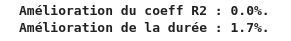

---

[**Description du jeux de données**](#fichier_données)
 * [Evaluation de valeurs manquants](#valeurs_manquants)
   * [Analyse remplissage colonnes et type de données](#remplissage_colonnes) 
   * [Analyse remplissage lignes](#remplissage_lignes) 
 * [Doublons lignes complètes](#Doublons_lignes_completes)

[**Compréhension et sélection des variables**](#Compr_selec_variables)
 * [Informations générales sur les bâtiments](#variables_info_general)
 * [Nombre de bâtiments et nombre d'étages](#variables_nombre_bati_etages)  
 * [Surface des bâtiments](#variables_surface)   
 * [Utilisation des bâtiments](#variables_utilisation)  
   * [Réduction du jeu de données aux bâtiments non résidentiels](#reduction_bati_non_residentiels) 
 * [Consommation d'énergie](#variables_consommation)
 * [Émissions](#variables_emissions)
 * [Energy Star Score](#variables_energyStar)
 * [Autres variables](#variables_autres)
 * [Synthèse](#synthese_comp_selec)
   * [Réduction du jeu de données, suppresion variables](#reduction_variables)
   * [Valeurs manquants](#valeurs_manquants)
   
[**Analyse exploratoire**](#analyse_exploratoire)
 * [Analyse Univariée](#analyse_univariée)  
   * [Variables qualitatives](#uni_variables_qualitatives) 
   * [Variables quantitatives](#uni_variables_quantitatives) 
 * [Analyse Multivariée](#analyse_multivariée)  
   * [Variables qualitatives](#multi_variables_qualitatives) 
   * [Variables quantitatives](#multi_variables_quantitatives) 

[**Feature engineering**](#feature_engineering)
 * [Variables cible](#variables_cible) 
 * [Âge de la propriété](#age_propriété) 
 * [Council District Code](#district) 
 * [Utilisations](#utilisations) 
 * [Consomation](#consomation) 
 * [Suppresion des variables](#vari_supprimer)  

[**Jeu de données pour la modélisation**](#donnees_modelisation)

<br>

---


<a id='CHARGEMENT_LIBRAIRIES'></a>

---

---

<font size="+1"> **CHARGEMENT DES LIBRAIRIES** </font>

---

In [1]:
#import sys
#!pip install folium

import os
import glob
import pandas as pd
import numpy as np
import csv
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import webbrowser
import scipy.stats as stats
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


#-------------------------------------------------------------
#Vérification des numéros des versions des packages installés
#-------------------------------------------------------------

print('Version des librairies utilisées : \n')

print('Pandas        : ' + pd.__version__)
print('NumPy         : ' + np.version.full_version)
print('Csv           : ' + csv.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)
print('Folium       : ' + folium.__version__)
print('Sklearn        : ' + sklearn.__version__)


import datetime
now  = datetime.datetime.now().isoformat()
print('Lancé le      : ' + now)


Version des librairies utilisées : 

Pandas        : 1.5.2
NumPy         : 1.23.5
Csv           : 1.0
Matplotlib    : 3.3.4
Seaborn       : 0.11.1
Folium       : 0.1.5
Sklearn        : 1.2.0
Lancé le      : 2023-02-14T09:18:22.902478



<a id='FONCTIONS_UTILISÉES'></a>


<br>


---
---

<font size="+1"> **FONCTIONS UTILISÉES DANS CE NOTEBOOK** </font>

---


In [2]:
#-----------------------------------------------------------------------------
# Informations complémentaires pour la description des fichiers de données 
#-----------------------------------------------------------------------------

def compl_info (df):
    nb_row = df.index.size
    nb_col = df.columns.size
    Types = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'}) 
    Null = pd.DataFrame(df.isna().sum()).T.rename(index={0:'null'}) 
    PercCount = pd.DataFrame(100-100*(df.isna().sum())/nb_row).T.rename(index={0:'Pourcentage remplissage'}) 
    infor = pd.concat ([Types,Null,PercCount], axis =0)
    return infor

In [3]:
#-----------------------------------------------------------------------------
# Informations complémentaires pour l'analyse des Statistiques descriptifs
#-----------------------------------------------------------------------------

def stat_des (df):
    Min = pd.DataFrame(df.min(axis=0)).T.rename(index={0:'Min'})
    Max = pd.DataFrame(df.max(axis=0)).T.rename(index={0:'Max'})
    Mean = pd.DataFrame(df.mean(axis=0)).T.rename(index={0:'Mean'})
    Median = pd.DataFrame(df.median(axis=0)).T.rename(index={0:'Median'})                
    Variance = pd.DataFrame(df.var(ddof=0, axis=0)).T.rename(index={0:'Variance'})
    Standard_deviation = pd.DataFrame(df.std(ddof=0, axis=0)).T.rename(index={0:'Standard_deviation'})
    Skewness = pd.DataFrame(df.skew(axis=0)).T.rename(index={0:'Skewness'})
    Kurtosis = pd.DataFrame(df.kurtosis(axis=0)).T.rename(index={0:'Kurtosis'})
    #Mode = pd.DataFrame(df.mode(axis=0)).rename(index={0:'Mode'})
    
    
    stat = pd.concat([Min, Max, Mean, Median, Variance, Standard_deviation, Skewness, Kurtosis], axis=0)
    return stat
                       

In [4]:
# ---------------------------------------------
#  DESCRIPTION VARIABLES QUALITATIVES NOMINALES
# ---------------------------------------------

def quali_tableau_repartition(dataframe, variable, tableau =True, graphRepart=True):
   
    """
    Affiche le tableau des 20 entrées les plus fréquences et un graphique de barres avec la frequence des mots
    Paramètres : dataframe : DataFrame, obligatoire
                 variable : variable à analyser, obligatoire
                 tableau : booléen, True = affiche le tableau des fréquences
                 graphRepart : booléen,  True = affiche le graphique de répartition en pourcentage
    """

    if tableau:
        df = dataframe[variable].value_counts().to_frame().reset_index() 
        df = df.rename(columns={'index':variable, variable:'nombre_entrees'})
        df['frequence (%)'] = 100*df['nombre_entrees']/((dataframe.shape[0]))
        display(df.head(10).style.hide(axis="index"))
        
    if graphRepart:
        plt.figure(figsize=(4,6))
        df_graph = df.sort_values('frequence (%)', ascending=False).head(20)
        sns.barplot(data= df_graph, x= 'frequence (%)', y= variable , palette = "viridis_r")
        plt.title("Répartition de " + variable)
        plt.show()
        

In [5]:

#----------------------------------------------
# SUPPRIMER DES SUFFIX DU NOM DES COLONNES
#----------------------------------------------
def strip_right(df, suffix):
    df.columns = df.columns.str.rstrip(suffix)


<a id='fichier_données'></a>

# <span style='background:#26467a'><span style='color:white'>**Description du jeux de données** </span></span>



---
---

<font size="+1">**Aperçu du jeu de données**</font>


In [6]:
# Définir le dossier qui contient les fichiers avec les données du projet

P4_source = '/home/raquelsp/Documents/Openclassrooms/P4_Seattle_buildings/P4_travail/P4_data/P4_source'

os.chdir(P4_source)

# Nombre et nom des fichiers csv
allFilesCsv = glob.glob('*.csv')   

print("L'information sur les variablese est contenue dans: "+str(len(allFilesCsv))+ " fichiers.\n")
print("Les fichiers contenant l'information sur les variables sont: "+str(allFilesCsv))


L'information sur les variablese est contenue dans: 1 fichiers.

Les fichiers contenant l'information sur les variables sont: ['2016_Building_Energy_Benchmarking.csv']


In [7]:

#-----------------------------------
# Chargement du  fichier des données
#-----------------------------------
source_BEB_2016 = pd.read_csv('2016_Building_Energy_Benchmarking.csv', low_memory=False,encoding='utf-8')

#-----------------------------------
# Taille du  fichier des données
#-----------------------------------
print("Le jeux de données contient " + str(source_BEB_2016.shape[0]) + " lignes et " + str(source_BEB_2016.shape[1]) + " colonnes.\n")

#-------------------------------
# Aperçu données Open Food Facts
#-------------------------------
pd.options.display.max_columns = None
source_BEB_2016.head(3)


Le jeux de données contient 3376 lignes et 46 colonnes.



,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19



<a id='valeurs_manquants'></a>

## <span style='background:#2a679a'><span style='color:white'>Evaluation de valeurs manquants</span>


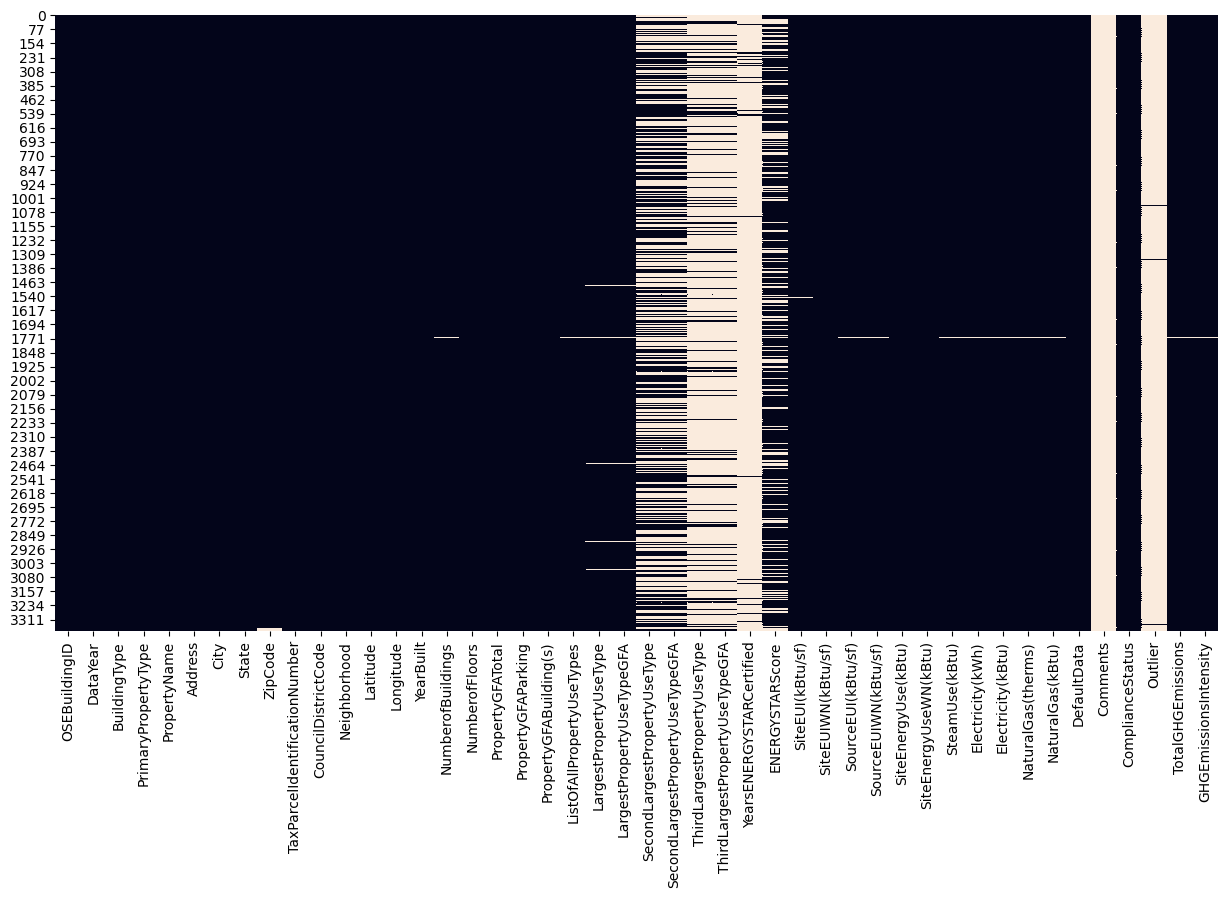

In [8]:

'''
#------------------------------
# Graphique valeurs manquantes
#------------------------------
'''
plt.figure(figsize=(15,8))
sns.heatmap(source_BEB_2016.isnull(), cbar=False, cmap="rocket")
plt.show()



<a id='remplissage_colonnes'></a>

### <span style='background:#358ab7'>Analyse remplissage colonnes et type de données</span>
  
    

In [9]:

#--------------------------------------------------------
# Colonnes ; types des données et pourcentage remplissage
#--------------------------------------------------------
info_BEB_2016 = compl_info(source_BEB_2016).T.sort_values("Pourcentage remplissage").reset_index()
info_BEB_2016 = info_BEB_2016.rename(columns={'index':'Variable'})

tot = source_BEB_2016.index.size * source_BEB_2016.columns.size #Number of total items
numNaN =info_BEB_2016["null"].sum() # Number of NaN
percentNaN = 100*numNaN/tot # Pourcentage NaN df

print("Sur un total de : " + str(tot) +" données possibles. Il y a " +str(numNaN)+ " Nan. Le "+ str(round(percentNaN, 2)) +("% des valeurs sont manquants. \n"))


Sur un total de : 155296 données possibles. Il y a 19952 Nan. Le 12.85% des valeurs sont manquants. 



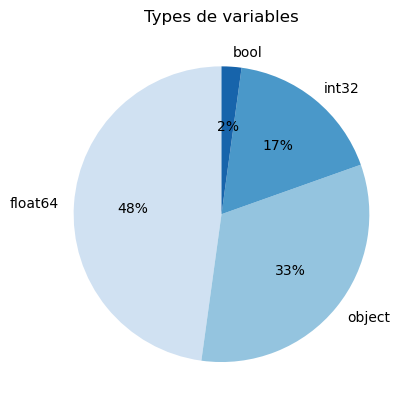

In [10]:
#Type de données

dTypes = info_BEB_2016['Type'].value_counts()
blues4 = sns.color_palette(palette="Blues", n_colors =4)

plt.pie(dTypes.values.tolist(), labels=['float64', 'object','int32', "bool"], colors = blues4, autopct='%.0f%%', startangle=90)
plt.title("Types de variables")
plt.show()

**Colonnes vides**

In [11]:

info_BEB_2016 = info_BEB_2016.sort_values(by=["Pourcentage remplissage"], ascending=True)

#Nombre colonnes vides
col0 = info_BEB_2016.loc[info_BEB_2016["Pourcentage remplissage"] == 0]

print("Il y a " + str(len(col0.index)) + " colonnes vides.\n")
col0

Il y a 1 colonnes vides.



,Variable,Type,null,Pourcentage remplissage
0,Comments,float64,3376,0.0


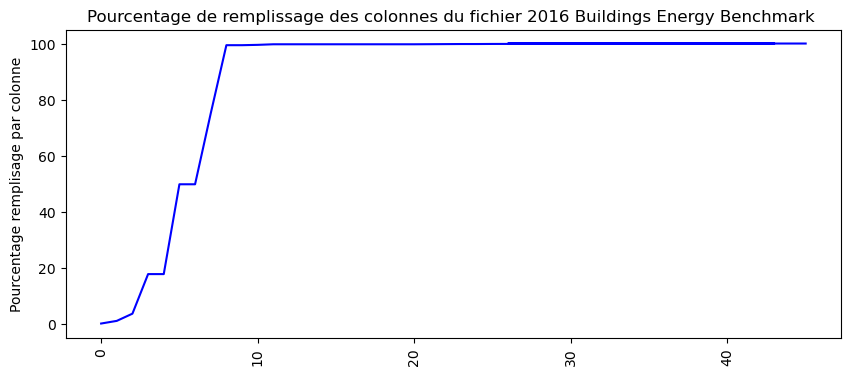

In [12]:

#-------
# Graph
#-------
empty_columns, ax = plt.subplots(figsize=(10,4))

empty_columns_gr = plt.plot(info_BEB_2016.index, info_BEB_2016['Pourcentage remplissage'], color = 'b')
ax.set_ylabel('Pourcentage remplisage par colonne')                          
ax.set_title("Pourcentage de remplissage des colonnes du fichier 2016 Buildings Energy Benchmark ")
plt.xticks(rotation = 90)
plt.tight_layout
plt.show()



<a id='remplissage_lignes'></a>

### <span style='background:#358ab7'>Analyse remplissage lignes</span>
    

In [13]:

#---------------------------------------------------------------
#Créer une copie du jeu de données pour l'analyse de remplissage
#---------------------------------------------------------------
BEB_2016 = source_BEB_2016.copy()

#Nombre de données par ligne
BEB_2016["Count Data"] = BEB_2016.count(axis=1) # axis = 1; lignes

#Lignes vides
BEB_2016.loc[BEB_2016["Count Data"] == 0]


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,Count Data


In [14]:

BEB_2016["Pourcent_rempl_lignes"] = BEB_2016["Count Data"]*100/BEB_2016.shape[1]

minPercentremp = round(BEB_2016["Pourcent_rempl_lignes"].min(),3)
maxPercentremp = round(BEB_2016["Pourcent_rempl_lignes"].max(),3)
print("Le pourcentage de remplissage minimale des lignes est " + str(minPercentremp) + "% et le pourcentage maximale de remplissage est de " + str(maxPercentremp) + "%.\n")


Le pourcentage de remplissage minimale des lignes est 44.681% et le pourcentage maximale de remplissage est de 93.617%.



Le pourcentage de remplissage minimale des lignes est 43.75%. Le pourcentage maximale de remplissage est de 91.67%.



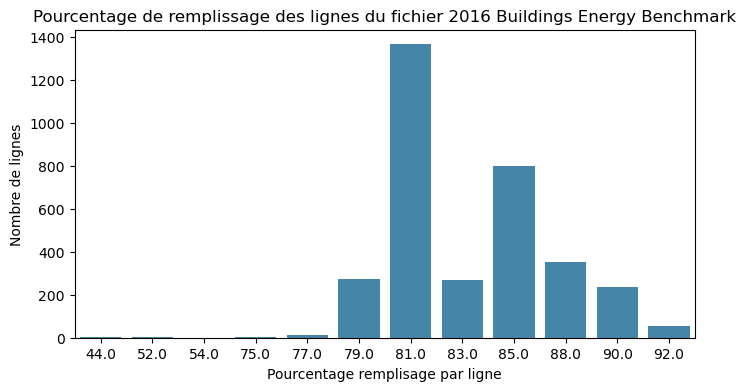

In [15]:

#---------------------------------
# Calcul du remplissage des lignes
#---------------------------------

BEB_2016["Pourcent_rempl_lignes"] = BEB_2016["Count Data"]*100/BEB_2016.shape[1]

minPercentremp = round(BEB_2016["Pourcent_rempl_lignes"].min(),2)
maxPercentremp = round(BEB_2016["Pourcent_rempl_lignes"].max(),2)
print("Le pourcentage de remplissage minimale des lignes est " + str(minPercentremp) + "%. Le pourcentage maximale de remplissage est de " + str(maxPercentremp) + "%.\n")


#-------------------------------------
#Visualisation remplissage des lignes
#-------------------------------------

plt.figure(figsize=(8,4))
sns.countplot(x=round(BEB_2016["Pourcent_rempl_lignes"],0), color ='#358ab7')

plt.title("Pourcentage de remplissage des lignes du fichier 2016 Buildings Energy Benchmark")
plt.ylabel("Nombre de lignes")
plt.xlabel("Pourcentage remplisage par ligne")
plt.show()



<a id='Doublons_lignes_completes'></a>

## <span style='background:#2a679a'><span style='color:white'>Doublons lignes complètes</span>
    

In [16]:

source_BEB_2016.duplicated().unique()


array([False])

<a id='Compr_selec_variables'></a>

---
---

# <span style='background:#26467a'><span style='color:white'>**Compréhension et sélection des variables** </span></span>
    


La description des colonnes du jeu de données est disponible [ici.](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy) 


Afin de faciliter l'analyse et la compréhension des variables, nous avons abordé leur étude par thème:

* [Informations générales sur les bâtiments](#variables_info_general)
* [Nombre de bâtiments et nombre d'étages](#variables_nombre_bati_etages)
* [Surface des bâtiments](#variables_surface)
* [Utilisation des bâtiments](#variables_utilisation)
* [Consomation d'énergie](#variables_consomation)
* [Émissions](#variables_emissions)
* [ENERGY STAR](#variables_energyStar)
* [Autres variables](#variables_autres)


<a id='variables_info_general'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Informations générales sur les bâtiments</span>
    


| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- |
| **OSEBuildingID** | identifiant unique attribué à chaque propriété, fins de suivi et d'identification | Number | **Conserver** pour avoir un ID exclusif pour chaque bâtiment, mais ça sera **inutile** pour la modélisation |
| **DataYear** | Année de régistre des données | Number | **Inutile**, toutes les entrées égal 2016 |
| **PropertyName** | Nom officiel ou commun de la propriété tel que saisi dans le EPA’s Portfolio Manager | Text | **Conserver** pour faciliter des vérifications pendant la phase d'exploration, mais ça sera **inutile** pour la modélisation |
| **Address** | Adresse de la propriété | Text | **Ignorer**, information moins précise que latitude+longitude |
| **City** | Ville | Text | **Inutile**, toutes les entrées Seattle |
| **State** | Etat | Text | **Inutile**, toutes les entrées WA |
| **ZipCode** | Code postal de propriété | Number | **Ignorer**, information moins précise que latitude+longitude |
| **TaxParcelIdentificationNumber** | Numéro de parcelle attribué par le bureau local d'évaluation fiscale | Text | **Inutile** , ID impôts |
| **CouncilDistrictCode** | "Council district" de la ville de Seattle dans lequel se trouve la propriété | Number | **Conserver** , améliorer comprension distribution spaciale |
| **Neighborhood** | Quartier de la propriété définie par le Département des Quartiers de la ville de Seattle | Text | **Conserver** , améliorer comprension distribution spaciale |
| **Latitude** | Latitude de propriété | Number | **Conserver** , améliorer comprension distribution spaciale |
| **Longitude** | Longitude de la propriété | Number | **Conserver** , améliorer comprension distribution spaciale |
| **YearBuilt** | Année au cours de laquelle une propriété a été construite ou a subi une rénovation complète | Number | **Conserver**, Explorer la relation entre la date de construction et l'efficacité énergétique |
| **BuildingType** |  Classification par type de bâtiment de la ville de Seattle | Text | **Inutile**, information "résidentiel / non résidentiel" sera extraite des données d'utilisation |



In [17]:

variables_info_general = ["OSEBuildingID", "PropertyName", "Address", "City", "State", "ZipCode", "TaxParcelIdentificationNumber", "CouncilDistrictCode", "Neighborhood", "Latitude", "Longitude", "YearBuilt", "BuildingType"]
info_BEB_2016.loc[info_BEB_2016['Variable'].isin(variables_info_general)]


,Variable,Type,null,Pourcentage remplissage
10,ZipCode,float64,16,99.526066
41,YearBuilt,int64,0,100.0
40,Longitude,float64,0,100.0
39,Latitude,float64,0,100.0
38,Neighborhood,object,0,100.0
37,CouncilDistrictCode,int64,0,100.0
36,TaxParcelIdentificationNumber,object,0,100.0
34,State,object,0,100.0
33,City,object,0,100.0
32,Address,object,0,100.0


Il y a 3353 addresses différentes.

Il y a 1 villes différentes.

Il y a 1 états différentes.

Il y a 55 codes postaux différents.

Il y a 7 distrits différents.

Il y a 14 quartiers différents.

Liste des quartiers de Seattle dans le jeu de données : ['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH', 'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH', 'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'DELRIDGE NEIGHBORHOODS']


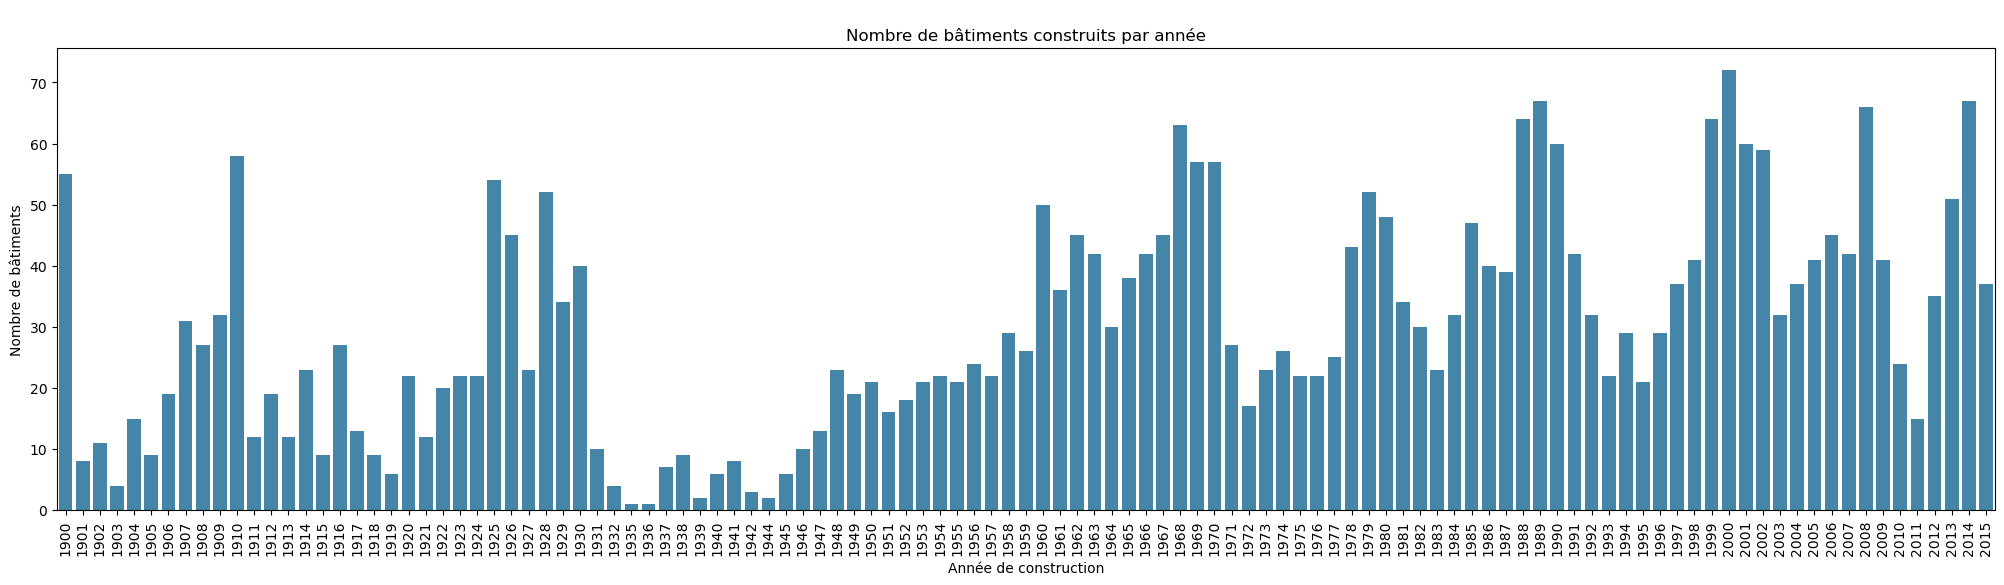

In [18]:

'''
OSEBuildingID
'''
# Vérification doublons ID bâtiment
source_BEB_2016[source_BEB_2016.duplicated(subset=['OSEBuildingID'], keep='first')] # pas de doublons
source_BEB_2016['OSEBuildingID'] = source_BEB_2016['OSEBuildingID'].astype('int32')
  
                                             #----------------------------#
                                             #----------------------------#
'''
PropertyName
'''
# Homogénéisation: passer tout en majuscules
source_BEB_2016['PropertyName'] = source_BEB_2016['PropertyName'].str.upper()

source_BEB_2016[source_BEB_2016.duplicated(subset=['PropertyName', 'TaxParcelIdentificationNumber'], keep=False)].sort_values(by=["PropertyName"], ascending=False)
# Il y a des lignes avec le nom de bâtiment mais il semble qu'elles correspondent à des ID de parcelle pour les impôts différentes
  
                                             #----------------------------#
                                             #----------------------------#
'''
Address
'''
# Homogénéisation: passer tout en majuscules
source_BEB_2016['Address'] = source_BEB_2016['Address'].str.upper()

print("Il y a " + str(source_BEB_2016['Address'].nunique()) + " addresses différentes.\n")
# Vérification doublons Address
source_BEB_2016[source_BEB_2016.duplicated(subset=['Address', 'PropertyName'], keep=False)].sort_values(by=["Address"], ascending=False)
# Il y a des lignes avec la même addresse mais les entrées correspondent à des bâtiments différents
  
                                             #----------------------------#
                                             #----------------------------#
'''
City
'''
print("Il y a " + str(source_BEB_2016['City'].nunique()) + " villes différentes.\n")

  
                                             #----------------------------#
                                             #----------------------------#
'''
State
'''
print("Il y a " + str(source_BEB_2016['State'].nunique()) + " états différentes.\n")
  
                                             #----------------------------#
                                             #----------------------------#
'''
ZipCode
'''

# Idéntifier les valeurs manquants
noZipCode = source_BEB_2016.loc[source_BEB_2016['ZipCode'].isna()]
noZipCode_address = noZipCode['Address']

# Chercher le ZipCode associé à l'addresse et compléter
source_BEB_2016.loc[source_BEB_2016['Address'] == '10510 5TH AVE NE' , 'ZipCode'] = 98125
source_BEB_2016.loc[source_BEB_2016['Address'] == '405 MLK JR WAY S' , 'ZipCode'] = 98144
source_BEB_2016.loc[source_BEB_2016['Address'] == '8729 15TH AVE NW' , 'ZipCode'] = 98117
source_BEB_2016.loc[source_BEB_2016['Address'] == '2806 NE 127TH ST' , 'ZipCode'] = 98125
source_BEB_2016.loc[source_BEB_2016['Address'] == '6020 28TH AVE NW' , 'ZipCode'] = 98107
source_BEB_2016.loc[source_BEB_2016['Address'] == '1471 NW 67TH ST' , 'ZipCode'] = 98117
source_BEB_2016.loc[source_BEB_2016['Address'] == '1403 W HOWE' , 'ZipCode'] = 98119
source_BEB_2016.loc[source_BEB_2016['Address'] == '1400 E GALER ST' , 'ZipCode'] = 98112
source_BEB_2016.loc[source_BEB_2016['Address'] == '2323 EAST CHERRY ST' , 'ZipCode'] = 98122
source_BEB_2016.loc[source_BEB_2016['Address'] == '4420 S GENESEE' , 'ZipCode'] = 98118
source_BEB_2016.loc[source_BEB_2016['Address'] == '6920 34TH AVE SW' , 'ZipCode'] = 98126
source_BEB_2016.loc[source_BEB_2016['Address'] == '1600 S DAKOTA ST' , 'ZipCode'] = 98108
source_BEB_2016.loc[source_BEB_2016['Address'] == '719 8TH AVE S' , 'ZipCode'] = 98104
source_BEB_2016.loc[source_BEB_2016['Address'] == '1920 1ST AVE W' , 'ZipCode'] = 98101
source_BEB_2016.loc[source_BEB_2016['Address'] == '8319 8TH AVE S' , 'ZipCode'] = 98108
source_BEB_2016.loc[source_BEB_2016['Address'] == '2820 S MYRTLE ST' , 'ZipCode'] = 98108

# passer de float64 à int32
source_BEB_2016['ZipCode'] = source_BEB_2016['ZipCode'].astype('int32')

print("Il y a " + str(source_BEB_2016['ZipCode'].nunique()) + " codes postaux différents.\n")
  
                                             #----------------------------#
                                             #----------------------------#
'''
TaxParcelIdentificationNumber
'''
source_BEB_2016[source_BEB_2016.duplicated(subset=['TaxParcelIdentificationNumber', 'PropertyName'], keep=False)].sort_values(by=["PropertyName"], ascending=False)
# Il y a des lignes avec le même ID de parcelle pour les impôts mais les entrées correspondent à des bâtiments différents

                                             #----------------------------#
                                             #----------------------------#
'''
CouncilDistrictCode
'''
source_BEB_2016['CouncilDistrictCode'].unique()
# Les valeurs renseingés correspondent bien aux "districts" de Seattle
source_BEB_2016['CouncilDistrictCode'] = source_BEB_2016['CouncilDistrictCode'].astype('int32')

print("Il y a " + str(source_BEB_2016['CouncilDistrictCode'].nunique()) + " distrits différents.\n")
                                             #----------------------------#
                                             #----------------------------#
'''
Neighborhood
'''
# Homogénéisation: passer tout en majuscules
source_BEB_2016['Neighborhood'] = source_BEB_2016['Neighborhood'].str.upper()
print("Il y a " + str(source_BEB_2016['Neighborhood'].nunique()) + " quartiers différents.\n")
print("Liste des quartiers de Seattle dans le jeu de données : " +str(list(source_BEB_2016['Neighborhood'].unique())))

# Deux noms pour le même quartier
source_BEB_2016['Neighborhood'] = source_BEB_2016['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

                                             #----------------------------#
                                             #----------------------------#

'''
YearBuilt
'''
source_BEB_2016['YearBuilt'] = source_BEB_2016['YearBuilt'].astype('int32')
plt.figure(figsize=(25,6))
sns.countplot(x=source_BEB_2016['YearBuilt'], color ='#358ab7')

plt.title("\nNombre de bâtiments construits par année")
plt.ylabel("Nombre de bâtiments")
plt.xlabel("Année de construction")
plt.xticks(rotation = 90)
plt.show()


In [19]:

'''
BuildingType
'''
# Homogénéisation: passer tout en majuscules
source_BEB_2016['BuildingType'] = source_BEB_2016['BuildingType'].str.upper()
list_BuildingType = source_BEB_2016['BuildingType'].unique().tolist()
print("Liste des types de bâtiments :" +str(list_BuildingType))

# Analyse de la liste d'utilisations des bâtiments "Multifamily"
verif_multifamily = source_BEB_2016[source_BEB_2016['BuildingType'].isin(['MULTIFAMILY MR (5-9)','MULTIFAMILY LR (1-4)', 'MULTIFAMILY HR (10+)'])][['BuildingType',"PrimaryPropertyType", "ListOfAllPropertyUseTypes", "LargestPropertyUseType"]]
verif_multifamily['PrimaryPropertyType'].unique()


Liste des types de bâtiments :['NONRESIDENTIAL', 'NONRESIDENTIAL COS', 'MULTIFAMILY MR (5-9)', 'SPS-DISTRICT K-12', 'CAMPUS', 'MULTIFAMILY LR (1-4)', 'MULTIFAMILY HR (10+)', 'NONRESIDENTIAL WA']


array(['Mid-Rise Multifamily', 'Low-Rise Multifamily',
       'High-Rise Multifamily', 'Senior Care Community',
       'Mixed Use Property', 'Other', 'Small- and Mid-Sized Office',
       'University', 'Hotel', 'Residence Hall'], dtype=object)


* Il y a des proprietées décrites comme "Multifamily" dont l'utilisation principale n'est pas "Multifamily".
* Pour restreindre l'étude aux propriétés non résidentielles, j'utiliserai un filtre combinant le type d'utilisation et le type de bâtiment.


In [20]:

#--------------------------------------------------------
# Carte distribution bâtiments sur une carte de Seattle :
#--------------------------------------------------------

Seattle = folium.Map(location=[source_BEB_2016['Latitude'].mean(), source_BEB_2016['Longitude'].mean()], zoom_start=12)

# NONRESIDENTIAL buildings
nonResidential = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'NONRESIDENTIAL']
for i in range(0, len(nonResidential)):
    Seattle.simple_marker([nonResidential.iloc[i]['Latitude'], nonResidential.iloc[i]['Longitude']], popup=nonResidential.iloc[i]['Address'], marker_color='black')

# NONRESIDENTIAL COS buildings 
nonResidentialCOS = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'NONRESIDENTIAL COS']
for i in range(0, len(nonResidentialCOS)):
    Seattle.simple_marker([nonResidentialCOS.iloc[i]['Latitude'], nonResidentialCOS.iloc[i]['Longitude']], popup=nonResidentialCOS.iloc[i]['Address'], marker_color='darkblue')

# NONRESIDENTIAL WA buildings
nonResidentialWA = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'NONRESIDENTIAL WA']
for i in range(0, len(nonResidentialWA)):
    Seattle.simple_marker([nonResidentialWA.iloc[i]['Latitude'], nonResidentialWA.iloc[i]['Longitude']], popup=nonResidentialWA.iloc[i]['Address'], marker_color='darkpurple')

# CAMPUS buildings 
campus = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'CAMPUS']
for i in range(0, len(campus)):
    Seattle.simple_marker([campus.iloc[i]['Latitude'], campus.iloc[i]['Longitude']], popup=campus.iloc[i]['Address'], marker_color='blue')

# SPS-DISTRICT K-12 buildings 
schoolarBuildings = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'SPS-DISTRICT K-12']
for i in range(0, len(schoolarBuildings)):
    Seattle.simple_marker([schoolarBuildings.iloc[i]['Latitude'], schoolarBuildings.iloc[i]['Longitude']], popup=schoolarBuildings.iloc[i]['Address'], marker_color='cadetblue')

# MULTIFAMILY HR (10+) buildings 
multifamilyHR = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'MULTIFAMILY HR (10+)']
for i in range(0, len(multifamilyHR)):
    Seattle.simple_marker([multifamilyHR.iloc[i]['Latitude'], multifamilyHR.iloc[i]['Longitude']], popup=multifamilyHR.iloc[i]['Address'], marker_color='lightgreen')

# MULTIFAMILY MR (5-9) buildings 
multifamilyMR = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'MULTIFAMILY MR (5-9))']
for i in range(0, len(multifamilyMR)):
    Seattle.simple_marker([multifamilyMR.iloc[i]['Latitude'], multifamilyMR.iloc[i]['Longitude']], popup=multifamilyMR.iloc[i]['Address'], marker_color='green')

# MULTIFAMILY LR (1-4) buildings 
multifamilyLR = source_BEB_2016.loc[source_BEB_2016['BuildingType'] == 'MULTIFAMILY LR (1-4)']
for i in range(0, len(multifamilyLR)):
    Seattle.simple_marker([multifamilyLR.iloc[i]['Latitude'], multifamilyLR.iloc[i]['Longitude']], popup=multifamilyLR.iloc[i]['Address'], marker_color='darkgreen')

Seattle.create_map(path='seattle.html')
webbrowser.open('seattle.html', new=2)  # open in new tab

Seattle

<a id='variables_nombre_bati_etages'></a>


---

## <span style='background:#2a679a'><span style='color:white'> Nombre de bâtiments et nombre d'étages</span>
    


| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- |
| **NumberofBuildings** | Nombre de bâtiments inclus dans le rapport de la propriété.<br> Dans les cas où une propriété est déclarée comme un campus, plusieurs bâtiments peuvent être inclus dans un rapport | Number | **Conserver** ; Utile pour remettre à l'échelle les autres varialbes par bâtiment |
| **NumberofFloors** | Nombre d'étages | Number | **Conserver** ; Utile pour remettre à l'échelle les autres varialbes par bâtiment |



In [21]:

variables_nombre_bati_etages = ["NumberofBuildings", "NumberofFloors"]
info_BEB_2016.loc[info_BEB_2016['Variable'].isin(variables_nombre_bati_etages)]


,Variable,Type,null,Pourcentage remplissage
21,NumberofBuildings,float64,8,99.763033
42,NumberofFloors,int64,0,100.0


In [22]:

'''
NumberofBuildings
'''

# Vérification valeurs "Number of Buildings"
print("Liste de valeurs pour la variable 'Number of Buildings' " + str(sorted(source_BEB_2016['NumberofBuildings'].unique().tolist())) +("\n"))

# vérifier les NaN et 0
source_BEB_2016.loc[source_BEB_2016['NumberofBuildings'].isna()]
source_BEB_2016.loc[source_BEB_2016['NumberofBuildings']== 0]

'''# Après Vérification à ces adresses il y a ont bien un bâtiment ==> on transformera '0' en '1'.'''
source_BEB_2016['NumberofBuildings'] = source_BEB_2016['NumberofBuildings'].replace(np.nan, 1)
source_BEB_2016['NumberofBuildings'] = source_BEB_2016['NumberofBuildings'].replace(0, 1)

# vérifier les propriétés à 27 bâtiments
#source_BEB_2016.loc[source_BEB_2016['NumberofBuildings'] == 27.0] # c'est un campus universitaire "SSCC MAIN CAMPUS"

# vérifier les propriétés à 111 bâtiments
#source_BEB_2016.loc[source_BEB_2016['NumberofBuildings'] == 111.0] # c'est un campus universitaire "UNIVERSITY OF WASHINGTON - SEATTLE CAMPUS"

# passer de float64 à int32
source_BEB_2016['NumberofBuildings'] = source_BEB_2016['NumberofBuildings'].astype('int32')

                                             #----------------------------#
                                             #----------------------------#
'''
NumberofFloors
'''
# Vérification valeurs "Number of floors"
print("Liste de valeurs pour la variable 'Number of floors' " + str(sorted(source_BEB_2016['NumberofFloors'].unique().tolist())) +("\n")) 

# vérifier les 20 plus hauts bâtiments
source_BEB_2016.sort_values("NumberofFloors", ascending=False).head(20)
'''# Après Vérification à ces bâtiments correspondent bien à les bâtiments les plus haut construits jusqu'en 2016.'''
'''# Exception : bâtiment de 99 étages, correspond à une église. Vérification dans Google Street, ce bâtiment a au maximum 2 étages. On remplacera 99 >> 2.'''
source_BEB_2016['NumberofFloors'] = source_BEB_2016['NumberofFloors'].replace(99, 2)
source_BEB_2016['NumberofFloors'] = source_BEB_2016['NumberofFloors'].astype('int32')
                                           

Liste de valeurs pour la variable 'Number of Buildings' [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 27.0, nan, 16.0, 23.0, 111.0]

Liste de valeurs pour la variable 'Number of floors' [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 46, 47, 49, 55, 56, 63, 76, 99]



<a id='variables_surface'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Surface des bâtiments</span>
    


| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- |
| **PropertyGFATotal** | Superficie brute totale du bâtiment et du parking | Number  | **Ignorer**, la variable n'apporte pas d'informations supplémentaires |
| **PropertyGFAParking** | Espace total de tous les types de stationnement (entièrement clos, partiellement clos et ouvert) | Number | **Conserver** |
| **PropertyGFABuilding(s)** | Superficie brute totale (GFA Gross Floor Area) entre les surfaces extérieures des murs d'enceinte d'un bâtiment. Cela comprend toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace des locataires, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc | Number | **Conserver** |


In [23]:

variables_surface = ["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)"]
info_BEB_2016.loc[info_BEB_2016['Variable'].isin(variables_surface)]


,Variable,Type,null,Pourcentage remplissage
43,PropertyGFATotal,int64,0,100.0
35,PropertyGFAParking,int64,0,100.0
44,PropertyGFABuilding(s),int64,0,100.0


In [24]:

# Vérification. PropertyGFATotal corresponds à la somme de "PropertyGFAParking" et "PropertyGFABuilding(s)"
surface_variables = source_BEB_2016[["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]].head(20)
surface_variables["Test1"] = surface_variables["PropertyGFATotal"] - surface_variables["PropertyGFAParking"] - surface_variables["PropertyGFABuilding(s)"]
surface_variables.loc[surface_variables["Test1"] !=0]



,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,Test1



 * Les trois variables montrent un taux de remplissage de 100% et le bon type de données.
 * PropertyGFATotal corresponds sans exception à la somme de "PropertyGFAParking" et "PropertyGFABuilding(s)"


<a id='variables_utilisation'></a>

---

## <span style='background:#2a679a'><span style='color:white'>Utilisation des bâtiments</span>



| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- |
|**PrimaryPropertyType** | L'utilisation principale d'une propriété (par exemple, un bureau, un magasin de détail). L'utilisation principale est définie comme une fonction qui représente plus de 50% d'une propriété. Il s'agit du champ Property Type - EPA Calculated field from Portfolio Manager | Text | **Ignorer**, information similaire à "utilisation la plus importante" |
| **ListOfAllPropertyUseTypes** | Liste de toutes les utilisations de la propriété | Text | **Ignorer**, peu de bâtiments avec 3 types ou plus d'utilisation |
| **LargestPropertyUseType** | L'utilisation la plus importante d'une propriété (par exemple, un bureau, un magasin de détail) par GFA  | Text | **Transformer** |
| **LargestPropertyUseTypeGFA** | Superficie brute totale (GFA Gross Floor Area) de l'utilisation la plus importante d'une propriété | Number | **Transformer** |
| **SecondLargestPropertyUseType** | Deuxième utilisation plus importante d'une propriété par GFA  | Text | **Transformer** |
| **SecondLargestPropertyUseTypeGFA** | Superficie brute totale (GFA Gross Floor Area) de la deuxième utilisation plus importante d'une propriété | Number | **Transformer** |
| **ThirdLargestPropertyUseType** | Troisième utilisation plus importante d'une propriété par GFA  | Text | **Transformer** |
| **ThirdLargestPropertyUseTypeGFA** | Superficie brute totale (GFA Gross Floor Area) de la troisième utilisation plus importante d'une propriété | Number | **Transformer** |


In [25]:

variables_utilisation = ["PrimaryPropertyType", "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA"]
info_BEB_2016.loc[info_BEB_2016['Variable'].isin(variables_utilisation)]


,Variable,Type,null,Pourcentage remplissage
3,ThirdLargestPropertyUseType,object,2780,17.654028
4,ThirdLargestPropertyUseTypeGFA,float64,2780,17.654028
5,SecondLargestPropertyUseType,object,1697,49.733412
6,SecondLargestPropertyUseTypeGFA,float64,1697,49.733412
8,LargestPropertyUseTypeGFA,float64,20,99.407583
9,LargestPropertyUseType,object,20,99.407583
19,ListOfAllPropertyUseTypes,object,9,99.733412
30,PrimaryPropertyType,object,0,100.0


In [26]:

'''
PrimaryPropertyType
'''

# Vérification valeurs "Primary Property Type"
print("Il y a " + str(len(source_BEB_2016['PrimaryPropertyType'].unique().tolist())) + " valeurs différents. Liste de valeurs pour la variable 'Primary Property Type' \n")
pprint(str(source_BEB_2016['PrimaryPropertyType'].unique().tolist()))

                                             #----------------------------#
                                             #----------------------------#


Il y a 24 valeurs différents. Liste de valeurs pour la variable 'Primary Property Type' 

("['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 "
 "School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage "
 "Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical "
 "Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution "
 "Center', 'Worship Facility', 'Low-Rise Multifamily', 'Supermarket / Grocery "
 "Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'High-Rise "
 "Multifamily', 'Office']")


In [27]:

'''
ListOfAllPropertyUseTypes
'''
# Vérification valeurs "Primary Property Type"
print("Il y a " + str(len(source_BEB_2016['ListOfAllPropertyUseTypes'].unique().tolist())) +" valeurs différents.\n")

# Remplacement NaN. 
source_BEB_2016[source_BEB_2016["ListOfAllPropertyUseTypes"].isna()][["BuildingType", "PrimaryPropertyType", "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA"]]
                                    

Il y a 467 valeurs différents.



,BuildingType,PrimaryPropertyType,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
578,NONRESIDENTIAL,Small- and Mid-Sized Office,NaN,NaN,NaN,NaN,NaN,NaN
758,MULTIFAMILY LR (1-4),Low-Rise Multifamily,NaN,NaN,NaN,NaN,NaN,NaN
1768,MULTIFAMILY LR (1-4),Low-Rise Multifamily,NaN,NaN,NaN,NaN,NaN,NaN
1792,MULTIFAMILY LR (1-4),Low-Rise Multifamily,NaN,NaN,NaN,NaN,NaN,NaN
2321,MULTIFAMILY LR (1-4),Low-Rise Multifamily,NaN,NaN,NaN,NaN,NaN,NaN
2474,MULTIFAMILY LR (1-4),Low-Rise Multifamily,NaN,NaN,NaN,NaN,NaN,NaN
2480,MULTIFAMILY LR (1-4),Low-Rise Multifamily,NaN,NaN,NaN,NaN,NaN,NaN
2670,NONRESIDENTIAL,Mixed Use Property,NaN,NaN,NaN,NaN,NaN,NaN
3348,MULTIFAMILY LR (1-4),Low-Rise Multifamily,NaN,NaN,NaN,NaN,NaN,NaN



* Les lignes sans information pour "ListOfAllPropertyUseTypes" ont des données pour "PrimaryPropertyType".
* Ces lignes ne sont non plus renseignées pour "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType".

* On imputera le valeur de "PrimaryPropertyType" dans "ListOfAllPropertyUseTypes" et "LargestPropertyUseType".

* Comme il existe des variables permettant de renseigner en détail jusqu'à trois utilisations principales et que moins de 18% des bâtiments ont trois ou plus utilisations différentes, nous ignorerons cette variable.


In [28]:

#  Imputation du valeur en "PrimaryPropertyType" dans "ListOfAllPropertyUseTypes" et "LargestPropertyUseType"
lignes_nanListAllUse = source_BEB_2016[source_BEB_2016["ListOfAllPropertyUseTypes"].isna()].index

source_BEB_2016["ListOfAllPropertyUseTypes"] = source_BEB_2016["ListOfAllPropertyUseTypes"].fillna(source_BEB_2016["PrimaryPropertyType"])

source_BEB_2016.loc[lignes_nanListAllUse, "LargestPropertyUseType"] = source_BEB_2016["PrimaryPropertyType"]

# Lignes correspondant à des bâtiments résidentiels
Residential_buildings = source_BEB_2016.loc[source_BEB_2016["BuildingType"].isin(['MULTIFAMILY MR (5-9)','MULTIFAMILY LR (1-4)', 'MULTIFAMILY HR (10+)'])\
                                            & source_BEB_2016["ListOfAllPropertyUseTypes"].str.contains("Multifamily")]

                                             #----------------------------#
                                             #----------------------------#


**Parmi les lignes contenant 'Multifamily' dans la colonne "ListOfAllPropertyUseTypes" <br>
            il y a certaines pour las quelles la colonne "BuildingType" renseinge NONRESIDENTIAL <br>
            nous donnons la priorité à la catégorie attribuée dans "BuildingType"** 

<a id='reduction_bati_non_residentiels'></a>

### <span style='background:#358ab7'><span style='color:white'>**Réduction du jeu de données aux bâtiments non résidentiels**</span></span>


In [29]:

non_residential_BEB_2016 = source_BEB_2016.drop(index= Residential_buildings.index.tolist()).reset_index()
non_residential_BEB_2016.shape


(1701, 47)

<a id='suite_variables_utilisation'></a>

### <span style='background:#358ab7'><span style='color:white'>**Suite Utilisation des bâtiments**</span></span>


In [30]:

info_non_residential_BEB_2016 = compl_info(non_residential_BEB_2016).T.sort_values("Pourcentage remplissage").reset_index()
info_non_residential_BEB_2016 = info_non_residential_BEB_2016.rename(columns={'index':'Variable'})


In [31]:

variables_utilisation = ["PrimaryPropertyType", "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseType",\
                         "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA"]
info_non_residential_BEB_2016.loc[info_non_residential_BEB_2016['Variable'].isin(variables_utilisation)]


,Variable,Type,null,Pourcentage remplissage
3,ThirdLargestPropertyUseType,object,1347,20.811287
4,ThirdLargestPropertyUseTypeGFA,float64,1347,20.811287
5,SecondLargestPropertyUseType,object,828,51.322751
6,SecondLargestPropertyUseTypeGFA,float64,828,51.322751
8,LargestPropertyUseTypeGFA,float64,6,99.647266
9,LargestPropertyUseType,object,4,99.764844
29,PrimaryPropertyType,object,0,100.0
45,ListOfAllPropertyUseTypes,object,0,100.0


In [32]:


'''
LargestPropertyUseType
'''

# Vérification valeurs "Largest Property Use Type"
print("Il y a " + str(len(non_residential_BEB_2016['LargestPropertyUseType'].unique().tolist())) +" valeurs différents.\n")

# Remplacement NaN. 
non_residential_BEB_2016[non_residential_BEB_2016["LargestPropertyUseType"].isna()][["BuildingType","ListOfAllPropertyUseTypes", "PrimaryPropertyType", "LargestPropertyUseType",\
                                                                                     "LargestPropertyUseTypeGFA" ,"SecondLargestPropertyUseType",\
                                                                                     "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType", \
                                                                                     "ThirdLargestPropertyUseTypeGFA"]]
                                    

Il y a 59 valeurs différents.



,BuildingType,ListOfAllPropertyUseTypes,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
347,NONRESIDENTIAL,"Fitness Center/Health Club/Gym, Office, Other ...",Self-Storage Facility,NaN,NaN,NaN,NaN,NaN,NaN
824,NONRESIDENTIAL,Hotel,Hotel,NaN,NaN,NaN,NaN,NaN,NaN
1367,NONRESIDENTIAL,Office,Small- and Mid-Sized Office,NaN,NaN,NaN,NaN,NaN,NaN
1385,NONRESIDENTIAL,Restaurant,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN



* Les lignes sans information pour "LargestPropertyUseType" ont des données pour "PrimaryPropertyType".

* Ces lignes ne sont non plus renseignées pour "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType".

* On imputera le valeur de "PrimaryPropertyType" dans "LargestPropertyUseType". 


In [33]:

#  Imputation du valeur en "PrimaryPropertyType" dans "LargestPropertyUseType"
lignes_nanLargestUse = non_residential_BEB_2016[non_residential_BEB_2016["LargestPropertyUseType"].isna()].index

non_residential_BEB_2016["LargestPropertyUseType"] = non_residential_BEB_2016["LargestPropertyUseType"].fillna(non_residential_BEB_2016["PrimaryPropertyType"])

                                             #----------------------------#
                                             #----------------------------#


In [34]:

'''
SecondLargestPropertyUseType
'''
# Vérification valeurs "Second Largest Property Use Type"
print("Il y a " + str(len(non_residential_BEB_2016['SecondLargestPropertyUseType'].unique().tolist())) +" valeurs différents pour la variable 'Second Largest Property Use Type'.\n")

                                            
'''
ThirdLargestPropertyUseType
'''
# Vérification valeurs "Third Largest Property Use Type"
print("Il y a " + str(len(non_residential_BEB_2016['ThirdLargestPropertyUseType'].unique().tolist())) +" valeurs différents pour la variable 'Third Largest Property Use Type'.\n")


Il y a 49 valeurs différents pour la variable 'Second Largest Property Use Type'.

Il y a 40 valeurs différents pour la variable 'Third Largest Property Use Type'.



<br>

---

 <font size="+1">**Superficie dédiée à la l'utilisation la plus importante**</font><br>

In [35]:

'''
LargestPropertyUseTypeGFA
'''

# Vérification valeurs "Largest Property Use Type"
oneUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["SecondLargestPropertyUseType"].isna()] 
# lignes correspondant aux bâtiments avec un seul type d'utilisation
# la "List of all property use types" a été vérifié pour confirmer que les proprietés ont bien 1 seul type d'utilisation

# Vérification superficie de l'utilisation principale = surface totale (puisqu'il y a un seul type d'utilisation)
verif_surface_largestUse = oneUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","ListOfAllPropertyUseTypes", "SiteEUI(kBtu/sf)", "SiteEnergyUse(kBtu)"]]
verif_surface_largestUse = verif_surface_largestUse.loc[verif_surface_largestUse["LargestPropertyUseTypeGFA"].notnull()]

# Idéntification des entrées pour lesquelles la superifice déclaré pour la unique utilisation du bâtiment ne coincide pas avec la supericie totale
verif_surface_largestUse["Diff_largest_total"] = verif_surface_largestUse["PropertyGFATotal"] - verif_surface_largestUse["LargestPropertyUseTypeGFA"]
problem_verif_surface_largestUse = verif_surface_largestUse.loc[verif_surface_largestUse["Diff_largest_total"] !=0]


print("Parmi les " + str(oneUsageType.shape[0]) + " bâtiments avec un seul type d'utilisation.\nIl y a " + str(problem_verif_surface_largestUse.shape[0]) + " bâtiments dont la superifice déclaré pour la unique utilisation du bâtiment ne coincide pas avec la supericie totale.\n")


Parmi les 828 bâtiments avec un seul type d'utilisation.
Il y a 318 bâtiments dont la superifice déclaré pour la unique utilisation du bâtiment ne coincide pas avec la supericie totale.



In [36]:

#On conserve la valeur de la PropertyGFATotal. On remplace LargestPropertyUseTypeGFA par PropertyGFATotal
non_residential_BEB_2016.loc[problem_verif_surface_largestUse.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFATotal"]

# Remplacement NaN
oneUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["SecondLargestPropertyUseType"].isna()] 
nan_largestSurface = oneUsageType.loc[oneUsageType["LargestPropertyUseTypeGFA"].isna()]

non_residential_BEB_2016.loc[nan_largestSurface.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFATotal"]


<br>

---

 <font size="+1">**Superficie de l'utilisation seconde**</font><br>

In [37]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
No SecondLargestPropertyUseType
'''
notwoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["SecondLargestPropertyUseType"].isna()] 

non_residential_BEB_2016.loc[notwoUsageType.index, "SecondLargestPropertyUseTypeGFA"] = 0


In [38]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Idéntification problèmes "Second Largest Property Use Type GFA"
'''
# lignes correspondant aux bâtiments avec deux types d'utilisation, la "List of all property use types" a été vérifié 
twoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna() & non_residential_BEB_2016["SecondLargestPropertyUseType"].notnull()]
verif_surface_SecondUse = twoUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",\
                                        "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType"]]

# Vérification surface utilisation secondaire = surface totale - surface utilisation principale
verif_surface_SecondUse["Diff_total"] = verif_surface_SecondUse["PropertyGFATotal"] - verif_surface_SecondUse["LargestPropertyUseTypeGFA"]- verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]

# Idéntification des entrées où il y a des problèmes
problem_verif_surface_SecondUse = verif_surface_SecondUse.loc[verif_surface_SecondUse["Diff_total"] !=0]

print("Parmi les " + str(twoUsageType.shape[0]) + " bâtiments avec deux types d'utilisation.\nIl y a "\
      + str(problem_verif_surface_SecondUse.shape[0]) + " bâtiments dont la somme de la superifice déclaré aux deux utilisations ne coincide pas avec la supericie totale.\n")


Parmi les 519 bâtiments avec deux types d'utilisation.
Il y a 333 bâtiments dont la somme de la superifice déclaré aux deux utilisations ne coincide pas avec la supericie totale.




**De nombreuses sources d'erreur ont été identifiées :**
 * Le parking figure dans la liste des usages, mais la surface déclarée comme parking = 0 et la surface d'utilisation secondaire = 0
 * Le parking figure dans la liste des usages, mais la surface déclarée comme parking = 0 et la difference ("Superficie Totale" - "Utilisation principale" - "Utilisation seconde") > 0
 * La seconde utilisation déclarée est "parking" mais la superificie parking est = 0
 * La première utilisation déclarée est "parking" mais la superificie parking est = 0
 * La superficie déclarée pour le parking corresponds avec celle de l'utilisation seconde
 * La superficie utilisation principale == superficie utilisation seconde et la somme de ces deux suppérieure à la superficie totale

**Actions mises en œuvre pour corriger les cas problématiques restants**
 * La somme des superficies atribuées à l'utilisation principale et seconde est inférieur à la superficie totale = éxces de surface totale
    * Répartition de la surface excédentaire entre la surface de l'utilisation principale et la surface de la seconde utilisation
 * La somme des superficies atribuées à l'utilisation principale et seconde est supérieur à la superficie totale = déficit de surface totale   
    * Déduction du déficit de surface entre la surface de l'utilisation principale et la surface de la deuxième utilisation
     

In [39]:
'''
SecondLargestPropertyUseTypeGFA
'''
'''
Parking non déclaré
'''
parking_must = problem_verif_surface_SecondUse.loc[problem_verif_surface_SecondUse["ListOfAllPropertyUseTypes"].str.contains("Parking")\
                                                   & (problem_verif_surface_SecondUse["PropertyGFAParking"]==0) & (verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]==0)\
                                                   & (verif_surface_SecondUse["Diff_total"] < 0)]

# Excés de superficie utilisation principale + seconde
non_residential_BEB_2016.loc[parking_must.index, "PropertyGFATotal"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[parking_must.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFABuilding(s)"]
non_residential_BEB_2016.loc[parking_must.index, "PropertyGFAParking"] = (non_residential_BEB_2016["PropertyGFATotal"]-non_residential_BEB_2016["PropertyGFABuilding(s)"])
non_residential_BEB_2016.loc[parking_must.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"]-non_residential_BEB_2016["LargestPropertyUseTypeGFA"])

# Manque de superficie utilisation principale + seconde
parking_must2 = problem_verif_surface_SecondUse.loc[problem_verif_surface_SecondUse["ListOfAllPropertyUseTypes"].str.contains("Parking") \
                                                    & (problem_verif_surface_SecondUse["PropertyGFAParking"]==0) & (verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]==0)\
                                                    & (verif_surface_SecondUse["Diff_total"] > 0)]
non_residential_BEB_2016.loc[parking_must2.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"]-non_residential_BEB_2016["LargestPropertyUseTypeGFA"])


In [40]:

'''
Idéntification problèmes "Second Largest Property Use Type GFA"
'''
twoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna() & non_residential_BEB_2016["SecondLargestPropertyUseType"].notnull()]
verif_surface_SecondUse = twoUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",\
                                        "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType"]]

verif_surface_SecondUse["Diff_total"] = verif_surface_SecondUse["PropertyGFATotal"] - verif_surface_SecondUse["LargestPropertyUseTypeGFA"]- verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]
problem_verif_surface_SecondUse = verif_surface_SecondUse.loc[verif_surface_SecondUse["Diff_total"] !=0]


In [41]:
'''
SecondLargestPropertyUseTypeGFA
'''
'''
manque superficie Parking
'''
parking_manque = problem_verif_surface_SecondUse.loc[problem_verif_surface_SecondUse["ListOfAllPropertyUseTypes"].str.contains("Parking")\
                                                     & (problem_verif_surface_SecondUse["PropertyGFAParking"] == 0) & (problem_verif_surface_SecondUse["Diff_total"] > 0)]

non_residential_BEB_2016.loc[parking_manque.index, "PropertyGFABuilding(s)"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[parking_manque.index, "PropertyGFAParking"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"])
non_residential_BEB_2016.loc[parking_manque.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"])



In [42]:
'''
SecondLargestPropertyUseTypeGFA
'''
'''
Parking non déclaré
2nd use = parking mais superficie parking = 0
'''
# Deuxiéme utilisation déclarée = parking, mais pas de superficie de parking déclarée
parking_0_second = problem_verif_surface_SecondUse.loc[problem_verif_surface_SecondUse["SecondLargestPropertyUseType"].str.contains("Parking")\
                                                       & (problem_verif_surface_SecondUse["PropertyGFAParking"] == 0)]

# Superficie utilisations  > superficie totale
parking_0_second1 = parking_0_second.loc[(parking_0_second["LargestPropertyUseTypeGFA"]+parking_0_second["SecondLargestPropertyUseTypeGFA"])> parking_0_second["PropertyGFATotal"]]

non_residential_BEB_2016.loc[parking_0_second1.index, "PropertyGFAParking"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[parking_0_second1.index, "PropertyGFABuilding(s)"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFAParking"])
non_residential_BEB_2016.loc[parking_0_second1.index, "LargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"])

# Superficie utilisations  < superficie totale
parking_0_second2 = parking_0_second.loc[(parking_0_second["LargestPropertyUseTypeGFA"]+parking_0_second["SecondLargestPropertyUseTypeGFA"])< parking_0_second["PropertyGFATotal"]]

non_residential_BEB_2016.loc[parking_0_second2.index, "PropertyGFABuilding(s)"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[parking_0_second1.index, "PropertyGFAParking"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFABuilding(s)"]
non_residential_BEB_2016.loc[parking_0_second1.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFAParking"]


In [43]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Parking non déclaré et Principale utilisation déclarée = parking
'''
# Principale utilisation déclarée = parking, mais pas de superficie de parking déclarée
parking_0_largest = problem_verif_surface_SecondUse.loc[problem_verif_surface_SecondUse["ListOfAllPropertyUseTypes"].str.contains("Parking")\
                                                        & (problem_verif_surface_SecondUse["PropertyGFAParking"] == 0)]


# Superficie utilisation principale >= superficie totale  et utilisation seconde = parking
parking_0_largest1 = parking_0_largest.loc[(parking_0_largest["LargestPropertyUseTypeGFA"]>= parking_0_largest["PropertyGFATotal"])\
                                           &(problem_verif_surface_SecondUse["SecondLargestPropertyUseType"].str.contains("Parking"))]

non_residential_BEB_2016.loc[parking_0_largest1.index, "PropertyGFAParking"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[parking_0_largest1.index, "PropertyGFABuilding(s)"] = (non_residential_BEB_2016["PropertyGFATotal"]- non_residential_BEB_2016["PropertyGFAParking"])
non_residential_BEB_2016.loc[parking_0_largest1.index, "LargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"]- non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"])


# Superficie utilisation principale >= superficie totale  et utilisation principale = parking
parking_0_largest2 = parking_0_largest.loc[(parking_0_largest["LargestPropertyUseTypeGFA"]>= parking_0_largest["PropertyGFATotal"])\
                                           &(problem_verif_surface_SecondUse["LargestPropertyUseType"].str.contains("Parking"))]

non_residential_BEB_2016.loc[parking_0_largest2.index, "PropertyGFATotal"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[parking_0_largest2.index, "PropertyGFABuilding(s)"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[parking_0_largest2.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFABuilding(s)"]
non_residential_BEB_2016.loc[parking_0_largest2.index, "PropertyGFAParking"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFABuilding(s)"]


In [44]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
L'écart n'est pas associé au parking
'''
#somme superficie utilisation secondaire + diference > superificie utilisation principale
add_dif_largest = problem_verif_surface_SecondUse.loc[(~problem_verif_surface_SecondUse["ListOfAllPropertyUseTypes"].str.contains("Parking"))\
                                                      &(problem_verif_surface_SecondUse["PropertyGFAParking"] == 0) & (problem_verif_surface_SecondUse["Diff_total"] > 0)\
                                                      & ((problem_verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]+problem_verif_surface_SecondUse["Diff_total"])\
                                                         > problem_verif_surface_SecondUse["LargestPropertyUseTypeGFA"])]

#création d'une colonne pour corriger 
non_residential_BEB_2016["add_diff"] = non_residential_BEB_2016["PropertyGFATotal"]-non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]

non_residential_BEB_2016.loc[add_dif_largest.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["add_diff"]

non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= "add_diff") # supprésion de la colonne pour corriger la superficie usage secondaire


In [45]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Superficie parking = superficie utilisation seconde >> LargestPropertyUseTypeGFA doit être PropertyGFABuilding(s)
'''

problem_in_largest = problem_verif_surface_SecondUse.loc[(problem_verif_surface_SecondUse["ListOfAllPropertyUseTypes"].str.contains("Parking"))\
                                                         & (problem_verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"] == problem_verif_surface_SecondUse["PropertyGFAParking"])]

non_residential_BEB_2016.loc[problem_in_largest.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFABuilding(s)"]


In [46]:

'''
Idéntification problèmes "Second Largest Property Use Type GFA"
'''
twoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna() & non_residential_BEB_2016["SecondLargestPropertyUseType"].notnull()]
verif_surface_SecondUse = twoUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",\
                                        "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType"]]

verif_surface_SecondUse["Diff_total"] = verif_surface_SecondUse["PropertyGFATotal"] - verif_surface_SecondUse["LargestPropertyUseTypeGFA"]- verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]
problem_verif_surface_SecondUse = verif_surface_SecondUse.loc[verif_surface_SecondUse["Diff_total"] !=0]


In [47]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Utilisation secondaire = parking
 
'''
problem_in_distrib = problem_verif_surface_SecondUse.loc[(problem_verif_surface_SecondUse["SecondLargestPropertyUseType"].str.contains("Parking"))\
                                                         & (problem_verif_surface_SecondUse["Diff_total"]<=0)]

# Superficie utilisation principale > superficie totale
problem_in_distrib1 = problem_in_distrib.loc[problem_in_distrib["LargestPropertyUseTypeGFA"] > problem_in_distrib["PropertyGFATotal"]]


non_residential_BEB_2016["correct_LargestUseGFA"] = non_residential_BEB_2016["PropertyGFATotal"] # création d'une colonne pour la correction
non_residential_BEB_2016.loc[problem_in_distrib1.index, "PropertyGFATotal"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[problem_in_distrib1.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["correct_LargestUseGFA"]
non_residential_BEB_2016.loc[problem_in_distrib1.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"])
non_residential_BEB_2016.loc[problem_in_distrib1.index, "PropertyGFAParking"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFABuilding(s)"])
non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["correct_LargestUseGFA"]) # supprésion de la colonne pour corriger les superficies

# Superficie utilisation principale + superficie utilisation seconde < superficie totale
problem_in_distrib2 = problem_in_distrib.loc[problem_in_distrib["LargestPropertyUseTypeGFA"] > problem_in_distrib["PropertyGFATotal"]]
non_residential_BEB_2016.loc[problem_in_distrib2.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"])


In [48]:

'''
Idéntification problèmes "Second Largest Property Use Type GFA"
'''
twoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna() & non_residential_BEB_2016["SecondLargestPropertyUseType"].notnull()]
verif_surface_SecondUse = twoUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",\
                                        "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType"]]

verif_surface_SecondUse["Diff_total"] = verif_surface_SecondUse["PropertyGFATotal"] - verif_surface_SecondUse["LargestPropertyUseTypeGFA"]- verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]
problem_verif_surface_SecondUse = verif_surface_SecondUse.loc[verif_surface_SecondUse["Diff_total"] !=0]


In [49]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Somme superficies utilisation principale et seconde > superficie totale
et
LargestPropertyUseType = parking
'''
exces_superf_princip_parking = problem_verif_surface_SecondUse.loc[(problem_verif_surface_SecondUse["Diff_total"]<0) & (problem_verif_surface_SecondUse["LargestPropertyUseType"].str.contains("Parking"))]

non_residential_BEB_2016.loc[exces_superf_princip_parking.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFAParking"]
non_residential_BEB_2016.loc[exces_superf_princip_parking.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFAParking"])


In [50]:

'''
Idéntification problèmes "Second Largest Property Use Type GFA"
'''
twoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna() & non_residential_BEB_2016["SecondLargestPropertyUseType"].notnull()]
verif_surface_SecondUse = twoUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",\
                                        "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType"]]

verif_surface_SecondUse["Diff_total"] = verif_surface_SecondUse["PropertyGFATotal"] - verif_surface_SecondUse["LargestPropertyUseTypeGFA"]- verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]
problem_verif_surface_SecondUse = verif_surface_SecondUse.loc[verif_surface_SecondUse["Diff_total"] !=0]


In [51]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Somme superficies utilisation principale et seconde > superficie totale
et
superficie utilisation principale == superficie utilisation seconde
'''
exces_superf_identiques = problem_verif_surface_SecondUse.loc[(problem_verif_surface_SecondUse["Diff_total"]<0) & (problem_verif_surface_SecondUse["LargestPropertyUseTypeGFA"] == problem_verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"])]

# Superficie utilisation principale > superficie totale
exces_superf_identiques1 = exces_superf_identiques.loc[exces_superf_identiques["LargestPropertyUseTypeGFA"] > exces_superf_identiques["PropertyGFATotal"]]

non_residential_BEB_2016["correct_LargestUseGFA"] = non_residential_BEB_2016["PropertyGFATotal"] # création d'une colonne pour la correction
non_residential_BEB_2016.loc[exces_superf_identiques1.index, "PropertyGFATotal"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[exces_superf_identiques1.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["correct_LargestUseGFA"]
non_residential_BEB_2016.loc[exces_superf_identiques1.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"])
non_residential_BEB_2016.loc[exces_superf_identiques1.index, "PropertyGFAParking"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFABuilding(s)"])
non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["correct_LargestUseGFA"]) # supprésion de la colonne pour corriger les superficies

# Superficie utilisation principale + superficie utilisation seconde < superficie totale
exces_superf_identiques2 = exces_superf_identiques.loc[exces_superf_identiques["LargestPropertyUseTypeGFA"] > exces_superf_identiques["PropertyGFATotal"]]
non_residential_BEB_2016.loc[exces_superf_identiques2.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"])



In [52]:

'''
Idéntification problèmes "Second Largest Property Use Type GFA"
'''
twoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna() & non_residential_BEB_2016["SecondLargestPropertyUseType"].notnull()]
verif_surface_SecondUse = twoUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",\
                                        "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType"]]

verif_surface_SecondUse["Diff_total"] = verif_surface_SecondUse["PropertyGFATotal"] - verif_surface_SecondUse["LargestPropertyUseTypeGFA"]- verif_surface_SecondUse["SecondLargestPropertyUseTypeGFA"]
problem_verif_surface_SecondUse = verif_surface_SecondUse.loc[verif_surface_SecondUse["Diff_total"] !=0]


In [53]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Somme superficies utilisation principale et seconde < superficie totale
'''
manque_superf = problem_verif_surface_SecondUse.loc[(problem_verif_surface_SecondUse["Diff_total"]>0)]

# la répartition de la surface excédentaire entre la surface de l'utilisation principale et la surface de la seconde utilisation
non_residential_BEB_2016["Diff_total"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"]- non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]

non_residential_BEB_2016["extra_largestGFA"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"] + round((non_residential_BEB_2016["Diff_total"]/2),0)
non_residential_BEB_2016["extra_secondGFA"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] + round((non_residential_BEB_2016["Diff_total"]/2),0)

non_residential_BEB_2016.loc[manque_superf.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["extra_largestGFA"]
non_residential_BEB_2016.loc[manque_superf.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["extra_secondGFA"]

non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["extra_largestGFA", "extra_secondGFA", "Diff_total"]) # supprésion de la colonne pour corriger les superficies


In [54]:

'''
SecondLargestPropertyUseTypeGFA
'''
'''
Somme superficies utilisation principale et seconde > superficie totale
'''
exces_superf = problem_verif_surface_SecondUse.loc[(problem_verif_surface_SecondUse["Diff_total"]<0)]

# Déduction du déficit de surface entre la surface de l'utilisation principale et la surface de la deuxième utilisation
non_residential_BEB_2016["Diff_total"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"]- non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]

non_residential_BEB_2016["reduct_largestGFA"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - round((non_residential_BEB_2016["Diff_total"]/2),0)
non_residential_BEB_2016["reduct_secondGFA"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] - round((non_residential_BEB_2016["Diff_total"]/2),0)

non_residential_BEB_2016.loc[exces_superf.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["reduct_largestGFA"]
non_residential_BEB_2016.loc[exces_superf.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["reduct_secondGFA"]

non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["reduct_largestGFA", "reduct_secondGFA", "Diff_total"]) # supprésion de la colonne pour corriger les superficies



In [55]:

'''
SecondLargestPropertyUseType
'''
'''
Remplacement NaN
'''
twoUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna() & non_residential_BEB_2016["SecondLargestPropertyUseType"].notnull()] 
nan_twoUsageType = twoUsageType.loc[twoUsageType["SecondLargestPropertyUseTypeGFA"].isna()]

non_residential_BEB_2016.loc[nan_largestSurface.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"])


In [56]:

variables_utilisation = ["PrimaryPropertyType", "ListOfAllPropertyUseTypes", "LargestPropertyUseType", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA"]
info_non_residential_BEB_2016 = compl_info(non_residential_BEB_2016).T.sort_values("Pourcentage remplissage").reset_index()
info_non_residential_BEB_2016 = info_non_residential_BEB_2016.rename(columns={'index':'Variable'})

info_non_residential_BEB_2016.loc[info_non_residential_BEB_2016['Variable'].isin(variables_utilisation)]


,Variable,Type,null,Pourcentage remplissage
3,ThirdLargestPropertyUseType,object,1347,20.811287
4,ThirdLargestPropertyUseTypeGFA,float64,1347,20.811287
5,SecondLargestPropertyUseType,object,828,51.322751
22,SecondLargestPropertyUseTypeGFA,float64,0,100.0
24,ListOfAllPropertyUseTypes,object,0,100.0
28,PrimaryPropertyType,object,0,100.0
34,LargestPropertyUseType,object,0,100.0
46,LargestPropertyUseTypeGFA,float64,0,100.0


<br>

---

 <font size="+1">**Superficie dédiée à la troisième utilisation la plus importante**</font><br>

In [57]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
No ThirdLargestPropertyUseType
'''
nothreeUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].isna()] 

non_residential_BEB_2016.loc[nothreeUsageType.index, "ThirdLargestPropertyUseTypeGFA"] = 0


In [58]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
Idéntification problèmes "Third Largest Property Use Type GFA"
'''
# lignes correspondant aux bâtiments avec trois types d'utilisation, la "List of all property use types" a été vérifié 
threeUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].notnull()] 
verif_surface_tiersdUse = threeUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA","ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]]

# Vérification surface utilisation secondaire = surface totale - surface utilisation principale
verif_surface_tiersdUse["Diff_total"] = verif_surface_tiersdUse["PropertyGFATotal"] - verif_surface_tiersdUse["LargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["SecondLargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["ThirdLargestPropertyUseTypeGFA"]

# Idéntification des entrées où il y a des problèmes
problem_verif_surface_tiersUse = verif_surface_tiersdUse.loc[verif_surface_tiersdUse["Diff_total"] !=0]

print("Parmi les " + str(threeUsageType.shape[0]) + " bâtiments avec trois types d'utilisation.\n Il y a " + str(problem_verif_surface_tiersUse.shape[0]) + " bâtiments dont la superifice déclaré pour l'ensemble des utilisations dela propriété ne coincide pas avec la supericie totale.\n")


Parmi les 354 bâtiments avec trois types d'utilisation.
 Il y a 298 bâtiments dont la superifice déclaré pour l'ensemble des utilisations dela propriété ne coincide pas avec la supericie totale.




 * Dans certains cas la difference de la somme des trois utilisations principales et la superficie totale est due à l'existence d'autres utilisations dans la propriété

**De nombreuses sources d'erreur ont été identifiées :**
 * La superficie dédiée à la troisième utilisation n'est pas déclarée et la difference de la somme des trois utilisations principales est inferièure à la superficie totale
     * La troisième utilisation est "Swimming Pool" et la deuxième est "Parking"
     * La troisième utilisation est "Swimming Pool" et la deuxième est autre que "Parking"
     * La troisième et deuxième utilisations sont "Parking"
     * La troisième utilisation est "Parking"
 
 * La superficie dédiée à la troisième utilisation n'est pas déclarée et la difference de la somme des trois utilisations principales est superièure à la superficie totale
     * La troisième utilisation est "Swimming Pool" 
     * La troisième et deuxième utilisations sont "Parking"
     * La troisième utilisation est "Parking"
     * La superficie déclarée pour la troisième utilisation = 0  et celle déclarée pour la deuxième utilisation < difference de la somme des trois utilisations principales est superièure à la superficie totale

 * La somme des superficies des trois utilisations principales est inférieure à la superficie totale + l'une des utilisations décrites est parking + Pas de superficie parking
     * L'une des utilisations est "Parking"
     * Aucune des utilisations est "Parking"
     
**Actions mises en œuvre pour corriger les cas problématiques restants**
 * La somme des trois utilisations principales est inferièure à la superficie totale
    * Repartition du exces de surface entre buildings et parking en respectant les proportions
 * La superficie dédiée à la troisième utilisation n'est pas déclarée et la difference de la somme des trois utilisations principales est superièure à la superficie totale 
    * Déduction du déficit de surface de buildings et parking en respectant les proportions
     

In [59]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
No ThirdLargestPropertyUseTypeGFA = 0
'''
diff_neg_sans_tiers = problem_verif_surface_tiersUse.loc[(problem_verif_surface_tiersUse["ThirdLargestPropertyUseTypeGFA"] == 0) &(problem_verif_surface_tiersUse["Diff_total"] < 0)]

# CASE 1
#--------------
# tiersUse = swimmingPool > secondUse = Parking > supprimer tiersUse & ajouter "with swimming Pool" à l'utilisation principale
# ET
# largestUseGFA = building  > secondUseGFA = Parking > 
case1 = diff_neg_sans_tiers.loc[(diff_neg_sans_tiers["SecondLargestPropertyUseType"]== "Parking") & (diff_neg_sans_tiers["ThirdLargestPropertyUseType"]== "Swimming Pool")]

non_residential_BEB_2016.loc[case1.index, "ThirdLargestPropertyUseType"] = "NaN"
non_residential_BEB_2016.loc[case1.index, "LargestPropertyUseType"] = (non_residential_BEB_2016["LargestPropertyUseType"].astype(str) + ' with Swimming Pool')
non_residential_BEB_2016.loc[case1.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFABuilding(s)"]
non_residential_BEB_2016.loc[case1.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFAParking"]


# CASE 2
#--------------
# tiersUse = swimmingPool > supprimer tiersUse & ajouter "with swimming Pool" à l'utilisation principale
# ET
# Déduction du déficit de surface entre la surface de l'utilisation principale et la surface de la deuxième utilisation
case2 = diff_neg_sans_tiers.loc[diff_neg_sans_tiers["ThirdLargestPropertyUseType"]== "Swimming Pool"]

non_residential_BEB_2016.loc[case2.index, "ThirdLargestPropertyUseType"] = "NaN"
non_residential_BEB_2016.loc[case2.index, "LargestPropertyUseType"] = (non_residential_BEB_2016["LargestPropertyUseType"].astype(str) + ' with Swimming Pool')

non_residential_BEB_2016["Diff_total"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] - non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"]

non_residential_BEB_2016["reduct_largestGFA"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - round((non_residential_BEB_2016["Diff_total"]/2),0)
non_residential_BEB_2016["reduct_secondGFA"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] - round((non_residential_BEB_2016["Diff_total"]/2),0)

non_residential_BEB_2016.loc[case2.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["reduct_largestGFA"]
non_residential_BEB_2016.loc[case2.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["reduct_secondGFA"]

non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["reduct_largestGFA", "reduct_secondGFA", "Diff_total"]) # supprésion de la colonne pour corriger les superficies



# CASE 3
#--------------
# secondUSe = parking et tiersUse = parking 
# ET 
#LargestPropertyUseTypeGFA > PropertyGFATotal
# 
# >supprimer tiersUse 
# ET
# LargestPropertyUseTypeGFA > PropertyGFABuilding(s) ET SecondPropertyUseTypeGFA > PropertyGFAParking
case3 = diff_neg_sans_tiers.loc[(diff_neg_sans_tiers["SecondLargestPropertyUseType"]== "Parking") & (diff_neg_sans_tiers["ThirdLargestPropertyUseType"]== "Parking")]                                

non_residential_BEB_2016.loc[case3.index, "ThirdLargestPropertyUseType"] = "NaN"
non_residential_BEB_2016.loc[case3.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFABuilding(s)"]
non_residential_BEB_2016.loc[case3.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFAParking"]
non_residential_BEB_2016.loc[case3.index, "ThirdLargestPropertyUseTypeGFA"] = 0

# CASE 4
#--------------
# tiersUse = parking >supprimer tiersUse 
# ET
# Déduction du déficit de surface entre la surface de l'utilisation principale et la surface de la deuxième utilisation
case4 = diff_neg_sans_tiers.loc[(diff_neg_sans_tiers["ThirdLargestPropertyUseType"]== "Parking") & (diff_neg_sans_tiers["PropertyGFAParking"]== 0)]                                

non_residential_BEB_2016.loc[case4.index, "ThirdLargestPropertyUseType"] = "NaN"

non_residential_BEB_2016["Diff_total"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] - non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"]

non_residential_BEB_2016["reduct_largestGFA"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - round((non_residential_BEB_2016["Diff_total"]/2),0)
non_residential_BEB_2016["reduct_secondGFA"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] - round((non_residential_BEB_2016["Diff_total"]/2),0)

non_residential_BEB_2016.loc[case4.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["reduct_largestGFA"]
non_residential_BEB_2016.loc[case4.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["reduct_secondGFA"]

non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["reduct_largestGFA", "reduct_secondGFA", "Diff_total"]) # supprésion de la colonne pour corriger les superficies
non_residential_BEB_2016['LargestPropertyUseType']= non_residential_BEB_2016['LargestPropertyUseType'].str.replace("with Swimming Pool with Swimming Pool", "with Swimming Pool")



In [60]:

'''
Idéntification problèmes "Third Largest Property Use Type GFA"
'''
threeUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].notnull()] 
verif_surface_tiersdUse = threeUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA","ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]]
verif_surface_tiersdUse["Diff_total"] = verif_surface_tiersdUse["PropertyGFATotal"] - verif_surface_tiersdUse["LargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["SecondLargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["ThirdLargestPropertyUseTypeGFA"]
problem_verif_surface_tiersUse = verif_surface_tiersdUse.loc[verif_surface_tiersdUse["Diff_total"] !=0]


In [61]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
No ThirdLargestPropertyUseTypeGFA = 0
'''
diff_posit_sans_tiers = problem_verif_surface_tiersUse.loc[(problem_verif_surface_tiersUse["ThirdLargestPropertyUseTypeGFA"] == 0) &(problem_verif_surface_tiersUse["Diff_total"] > 0)]


# CASE 1b
#--------------
# tiersUse = swimmingPool > supprimer tiersUse & ajouter "with swimming Pool" à l'utilisation principale
# ET
# largestUseGFA = TOTAl - second
case1b = diff_posit_sans_tiers.loc[(diff_posit_sans_tiers["ThirdLargestPropertyUseType"]== "Swimming Pool")]

non_residential_BEB_2016.loc[case1b.index, "ThirdLargestPropertyUseType"] = "NaN"
non_residential_BEB_2016.loc[case1b.index, "LargestPropertyUseType"] = (non_residential_BEB_2016["LargestPropertyUseType"].astype(str) + ' with Swimming Pool')

non_residential_BEB_2016.loc[case1b.index, "LargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"]-non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"])



# CASE 2b
#--------------
# secondUSe = parking et tiersUse = parking >supprimer tiersUse 
# ET
# secondUseGFA = surface parking
case2b = diff_posit_sans_tiers.loc[(diff_posit_sans_tiers["SecondLargestPropertyUseType"]== "Parking") & (diff_posit_sans_tiers["ThirdLargestPropertyUseType"]== "Parking")]

non_residential_BEB_2016.loc[case2b.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["LargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[case2b.index, "PropertyGFAParking"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[case2b.index, "LargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[case2b.index, "PropertyGFABuilding(s)"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFAParking"]
non_residential_BEB_2016.loc[case2b.index, "ThirdLargestPropertyUseType"] == 'NaN'



# CASE 3b
#--------------
# tiersUse = parking 
# ET
# Asigner la difference à la surface parking et à tiersUse 

case3b = diff_posit_sans_tiers.loc[(diff_posit_sans_tiers["ThirdLargestPropertyUseType"]== "Parking") & (diff_posit_sans_tiers["SecondLargestPropertyUseType"]!= "Parking")]

non_residential_BEB_2016.loc[case3b.index, "ThirdLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"])
non_residential_BEB_2016.loc[case3b.index, "PropertyGFAParking"] = non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[case3b.index, "PropertyGFABuilding(s)"] = (non_residential_BEB_2016["PropertyGFATotal"]  -non_residential_BEB_2016["PropertyGFAParking"])
case3b


# CASE 4b
#--------------
# tiersUseGFA = 0 et  secondUseGFA< difference superficie utilisations et total
# 
# Asigner secondUseGFA à tiersUseGFA
# ET
# Asigner la différence à secondUseGFA
case4b = diff_posit_sans_tiers.loc[(diff_posit_sans_tiers["SecondLargestPropertyUseTypeGFA"] < diff_posit_sans_tiers["Diff_total"]) & (diff_posit_sans_tiers["SecondLargestPropertyUseTypeGFA"]!= 0)]                                

non_residential_BEB_2016.loc[case4b.index, "ThirdLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]
non_residential_BEB_2016.loc[case4b.index, "SecondLargestPropertyUseTypeGFA"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"])



In [62]:

'''
Idéntification problèmes "Third Largest Property Use Type GFA"
'''
threeUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].notnull()] 
verif_surface_tiersdUse = threeUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA","ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]]
verif_surface_tiersdUse["Diff_total"] = verif_surface_tiersdUse["PropertyGFATotal"] - verif_surface_tiersdUse["LargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["SecondLargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["ThirdLargestPropertyUseTypeGFA"]
problem_verif_surface_tiersUse = verif_surface_tiersdUse.loc[verif_surface_tiersdUse["Diff_total"] !=0]


In [63]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
Somme superficies ensemble utilisations inférieure à la superficie totale
l'une des utilisations décrites est parking
Pas de superficie parking
'''
parking_butNo_surface = problem_verif_surface_tiersUse.loc[(problem_verif_surface_tiersUse["Diff_total"] > 0) & (problem_verif_surface_tiersUse["ListOfAllPropertyUseTypes"].str.contains("Parking")) & (problem_verif_surface_tiersUse["PropertyGFAParking"] == 0)]


# CASE A
#--------------
# si l'une des utilisations décrites est parking, on ajoute l'éxces de supercie à cette utilisation
# ET
# on asigne cette valeur à la superficie parking
# ET
# on reste cette superficie à PropertyGFABuilding(s)

caseAs = parking_butNo_surface.loc[(parking_butNo_surface["SecondLargestPropertyUseType"]== "Parking")]
non_residential_BEB_2016.loc[caseAs.index, "PropertyGFAParking"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"]- non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"])
non_residential_BEB_2016.loc[caseAs.index, "SecondLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFAParking"]
non_residential_BEB_2016.loc[caseAs.index, "PropertyGFABuilding(s)"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFAParking"])

caseAt = parking_butNo_surface.loc[(parking_butNo_surface["ThirdLargestPropertyUseType"]== "Parking")]
non_residential_BEB_2016.loc[caseAt.index, "PropertyGFAParking"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]- non_residential_BEB_2016["LargestPropertyUseTypeGFA"])
non_residential_BEB_2016.loc[caseAt.index, "ThirdLargestPropertyUseTypeGFA"] = non_residential_BEB_2016["PropertyGFAParking"]
non_residential_BEB_2016.loc[caseAt.index, "PropertyGFABuilding(s)"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFAParking"])


# CASE B
#----------
# les surfaces des trois utilisations sont décrites, pas de surface parking déclarée
#
# on asigne l'excés à parking 
# ET
# on reste cette superficie à PropertyGFABuilding(s)
caseB = parking_butNo_surface.loc[(parking_butNo_surface["LargestPropertyUseTypeGFA"]!=0) & (parking_butNo_surface["SecondLargestPropertyUseTypeGFA"]!=0) & (parking_butNo_surface["ThirdLargestPropertyUseTypeGFA"]!=0)]
non_residential_BEB_2016.loc[caseB.index, "PropertyGFAParking"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"]- non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]- non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"])
non_residential_BEB_2016.loc[caseB.index, "PropertyGFABuilding(s)"] = (non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["PropertyGFAParking"])

#On crée une nouvelle colonne dans non_residential_BEB_2016 pour prendre en compte qu'il y a plus de trois utilisations
non_residential_BEB_2016["OtherUseGFA"] = 0
non_residential_BEB_2016.loc[caseB.index, "OtherUseGFA"] = non_residential_BEB_2016["PropertyGFAParking"]


In [64]:

## Nouvelle colonne dans non_residential_BEB_2016 il faudra la supprimer à la fin
'''
Idéntification problèmes "Third Largest Property Use Type GFA"
'''
threeUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].notnull()] 
verif_surface_tiersdUse = threeUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA","ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType","OtherUseGFA"]]
verif_surface_tiersdUse["Diff_total"] = verif_surface_tiersdUse["PropertyGFATotal"] - verif_surface_tiersdUse["LargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["SecondLargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["ThirdLargestPropertyUseTypeGFA"]
problem_verif_surface_tiersUse = verif_surface_tiersdUse.loc[(verif_surface_tiersdUse["Diff_total"] !=0) & (verif_surface_tiersdUse["OtherUseGFA"] ==0)]


In [65]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
Pas de problème, il y a peut être plus d'utilisations
'''
exces_surface_manque_parking = problem_verif_surface_tiersUse.loc[(problem_verif_surface_tiersUse["Diff_total"]>0)\
                                                           &(problem_verif_surface_tiersUse["Diff_total"] < problem_verif_surface_tiersUse["ThirdLargestPropertyUseTypeGFA"])]


non_residential_BEB_2016.loc[exces_surface_manque_parking.index, "OtherUseGFA"] = (non_residential_BEB_2016["PropertyGFATotal"]- non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]- non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"])


In [66]:

## Nouvelle colonne dans non_residential_BEB_2016 il faudra la supprimer à la fin
'''
Idéntification problèmes "Third Largest Property Use Type GFA"
'''
threeUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].notnull()] 
verif_surface_tiersdUse = threeUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA","ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType","OtherUseGFA"]]
verif_surface_tiersdUse["Diff_total"] = verif_surface_tiersdUse["PropertyGFATotal"] - verif_surface_tiersdUse["LargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["SecondLargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["ThirdLargestPropertyUseTypeGFA"]
problem_verif_surface_tiersUse = verif_surface_tiersdUse.loc[(verif_surface_tiersdUse["Diff_total"] !=0) & (verif_surface_tiersdUse["OtherUseGFA"] ==0)]


In [67]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
Les surfaces des trois utilisations principales sont déclarées mais leur addition est inférieure à la superficie totale
'''
exces_surface = problem_verif_surface_tiersUse.loc[(problem_verif_surface_tiersUse["Diff_total"]>0)]

#On reparti l'exces de surface entre buildings et parking en respectant les proportions
non_residential_BEB_2016["Diff_total"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"]- non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] - non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"]

non_residential_BEB_2016["add_PropertyGFAParking"] = non_residential_BEB_2016["PropertyGFAParking"] + round((non_residential_BEB_2016["Diff_total"]*(non_residential_BEB_2016["PropertyGFAParking"]/non_residential_BEB_2016["PropertyGFATotal"])),1)
non_residential_BEB_2016["add_PropertyGFABuildings"] = non_residential_BEB_2016["PropertyGFABuilding(s)"] + round((non_residential_BEB_2016["Diff_total"]*(non_residential_BEB_2016["PropertyGFABuilding(s)"]/non_residential_BEB_2016["PropertyGFATotal"])),1)


non_residential_BEB_2016.loc[exces_surface.index, "PropertyGFAParking"] = non_residential_BEB_2016["add_PropertyGFAParking"]
non_residential_BEB_2016.loc[exces_surface.index, "PropertyGFABuilding(s)"] = non_residential_BEB_2016["add_PropertyGFABuildings"]
non_residential_BEB_2016.loc[exces_surface.index, "PropertyGFATotal"] = (non_residential_BEB_2016["PropertyGFAParking"] + non_residential_BEB_2016["PropertyGFABuilding(s)"])

non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["add_PropertyGFAParking", "add_PropertyGFABuildings", "Diff_total"]) # supprésion de la colonne pour corriger les superficies


non_residential_BEB_2016.loc[exces_surface_manque_parking.index, "OtherUseGFA"] = (non_residential_BEB_2016["PropertyGFATotal"]- non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]- non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"])


In [68]:

## Nouvelle colonne dans non_residential_BEB_2016 il faudra la supprimer à la fin
'''
Idéntification problèmes "Third Largest Property Use Type GFA"
'''
threeUsageType = non_residential_BEB_2016.loc[non_residential_BEB_2016["ThirdLargestPropertyUseType"].notnull()] 
verif_surface_tiersdUse = threeUsageType[["PropertyGFAParking", "PropertyGFATotal", "PropertyGFABuilding(s)","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA","ListOfAllPropertyUseTypes", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType","OtherUseGFA"]]
verif_surface_tiersdUse["Diff_total"] = verif_surface_tiersdUse["PropertyGFATotal"] - verif_surface_tiersdUse["LargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["SecondLargestPropertyUseTypeGFA"]- verif_surface_tiersdUse["ThirdLargestPropertyUseTypeGFA"]
problem_verif_surface_tiersUse = verif_surface_tiersdUse.loc[(verif_surface_tiersdUse["Diff_total"] !=0) & (verif_surface_tiersdUse["OtherUseGFA"] ==0)]


In [69]:

'''
ThirdLargestPropertyUseTypeGFA
'''
'''
Les surfaces des trois utilisations principales sont déclarées mais leur addition est supérieure à la superficie totale
'''
manque_surface = problem_verif_surface_tiersUse.loc[(problem_verif_surface_tiersUse["Diff_total"]<0)]

#On deduit la manque de surface de buildings et parking en respectant les proportions
non_residential_BEB_2016["Diff_total"] = non_residential_BEB_2016["PropertyGFATotal"] - non_residential_BEB_2016["LargestPropertyUseTypeGFA"]- non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"] - non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"]

non_residential_BEB_2016["reste_PropertyGFAParking"] = non_residential_BEB_2016["PropertyGFAParking"] - round((non_residential_BEB_2016["Diff_total"]*(non_residential_BEB_2016["PropertyGFAParking"]/non_residential_BEB_2016["PropertyGFATotal"])),1)
non_residential_BEB_2016["reste_PropertyGFABuildings"] = non_residential_BEB_2016["PropertyGFABuilding(s)"] - round((non_residential_BEB_2016["Diff_total"]*(non_residential_BEB_2016["PropertyGFABuilding(s)"]/non_residential_BEB_2016["PropertyGFATotal"])),1)

non_residential_BEB_2016.loc[manque_surface.index, "PropertyGFAParking"] = non_residential_BEB_2016["reste_PropertyGFAParking"]
non_residential_BEB_2016.loc[manque_surface.index, "PropertyGFABuilding(s)"] = non_residential_BEB_2016["reste_PropertyGFABuildings"]
non_residential_BEB_2016.loc[manque_surface.index, "PropertyGFATotal"] = (non_residential_BEB_2016["PropertyGFAParking"] + non_residential_BEB_2016["PropertyGFABuilding(s)"])

non_residential_BEB_2016.loc[exces_surface_manque_parking.index, "OtherUseGFA"] = (non_residential_BEB_2016["PropertyGFATotal"]- non_residential_BEB_2016["LargestPropertyUseTypeGFA"] - non_residential_BEB_2016["SecondLargestPropertyUseTypeGFA"]- non_residential_BEB_2016["ThirdLargestPropertyUseTypeGFA"])


non_residential_BEB_2016 = non_residential_BEB_2016.drop(columns= ["reste_PropertyGFAParking", "reste_PropertyGFABuildings", "Diff_total", "OtherUseGFA"]) # supprésion de la colonne pour corriger les superficies


In [70]:

# Après toutes les modifications on vérifie que la superifice total corresponds bien à la superficie de parking + bâtiments

#nombre de cas ou ça ne corresponds pas
non_residential_BEB_2016[non_residential_BEB_2016['PropertyGFATotal'] != (non_residential_BEB_2016['PropertyGFABuilding(s)'] + non_residential_BEB_2016['PropertyGFAParking'])].shape[0]


0

<a id='variables_consommation'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Consommation d'énergie</span>



| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- |
| **SiteEUI(kBtu/sf)** | Intensité de la consommation d'énergie du site (EUI) divisée par sa superficie brute totale. La consommation d'énergie du site est la quantité annuelle d'énergie consommée par la propriété sur place, telle qu'elle est indiquée sur les factures de services publics. L'IUE du site est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré | Number | **Ignorer** |
| **SiteEUIWN(kBtu/sf)** | Intensité de la consommation d'énergie du site (EUI) normalisée en fonction des conditions météorologiques (WN) divisée par sa superficie brute totale. L'énergie du site WN est la consommation d'énergie que la propriété aurait consommée pendant 30 ans dans des conditions météorologiques moyennes. Cette variable est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré | Number | **Ignorer** |
| **SourceEUI(kBtu/sf)** | Intensité de la consommation d'énergie à la source (EUI) divisée par sa superficie brute totale. La consommation d'énergie à la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes liées à la production, au transport et à la distribution. La EUI à la source  est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré | Number | **Ignorer** |
| **SourceEUIWN(kBtu/sf)** | Intensité de la consommation d'énergie à la source (EUI) normalisée en fonction des conditions météorologiques (WN) divisée par sa superficie brute totale.  La consommation d'énergie à la source WN est l'énergie utilisée par la propriété pendant 30 ans dans des conditions météorologiques moyennes. La EUI à la source WN  est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré | Number | **Ignorer** |
| **SiteEnergyUse(kBtu)** | La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie. Mesurée en milliers d'unités thermiques britanniques (kBtu) | Number | **Ignorer** |
| **SiteEnergyUseWN(kBtu)** | La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé pendant 30 ans dans des conditions météorologiques moyennes. Mesurée en milliers d'unités thermiques britanniques (kBtu) | Number | **Variable à modéliser** |
| **SteamUse(kBtu)** | La quantité annuelle de vapeur de quartier consommée par la propriété. Mesurée en milliers d'unités thermiques britanniques (kBtu) | Number | **Transformer** |
| **Electricity(kWh)** | La quantité annuelle d'électricité consommée par la propriété sur place, incluant l'électricité achetée au réseau et celle produite par des systèmes renouvelables sur place. Mesurée en kWh | Number | **Ignorer** |
| **Electricity(kBtu)** | La quantité annuelle d'électricité consommée par la propriété sur place, incluant l'électricité achetée au réseau et celle produite par des systèmes renouvelables sur place. Mesurée en milliers d'unités thermiques britanniques (kBtu) | Number | **Transformer** |
| **NaturalGas(therms)** | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété. Mesurée en thermes | Number | **Ignorer**. Le facteur de conversion utilisé pour le calcul de "TotalGHGEmissions" est en "kg CO2e/MBtu. " |
| **NaturalGas(kBtu)** | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété. Mesurée en milliers d'unités thermiques britanniques (kBtu) |  Number | **Transformer** |


In [71]:

variables_consomation = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", "SteamUse(kBtu)", "Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)"]
test_consommation = non_residential_BEB_2016[variables_consomation]
info_non_residential_BEB_2016.loc[info_non_residential_BEB_2016['Variable'].isin(variables_consomation)]


,Variable,Type,null,Pourcentage remplissage
7,SiteEUI(kBtu/sf),float64,3,99.823633
8,SiteEUIWN(kBtu/sf),float64,3,99.823633
9,SiteEnergyUseWN(kBtu),float64,3,99.823633
11,SourceEUI(kBtu/sf),float64,2,99.882422
12,SiteEnergyUse(kBtu),float64,2,99.882422
13,SteamUse(kBtu),float64,2,99.882422
14,Electricity(kWh),float64,2,99.882422
15,Electricity(kBtu),float64,2,99.882422
16,NaturalGas(therms),float64,2,99.882422
17,NaturalGas(kBtu),float64,2,99.882422



**Supprimer les lignes dans lesquelles la variable à modéliser " SiteEnergyUseWN(kBtu) " = NaN**


<a id='variables_emissions'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Émissions</span>


| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- |
| **TotalGHGEmissions**  | La quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde nitreux rejetés dans l'atmosphère en raison de la consommation d'énergie de la propriété. **Mesurée en tonnes métriques d'équivalent dioxyde de carbone**. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lb CO2e / MWh jusqu'à ce que le facteur 2016 soit disponible. Facteur de vapeur Enwave = 170,17 lb CO2e / MMBtu. Facteur gaz provenant de l'EPA Portfolio Manager = 53,11 kg CO2e / MBtu | Text | **Variable à modéliser** |
| **GHGEmissionsIntensity** | Émissions totales de gaz à effet de serre divisée par la superficie brute totale. Mesurées en équivalent de kilogrammes de dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de GHG provenant du portefeuille de ressources de production de Seattle City Light | Text | **Ignorer**. Ça ne corresponds pas à la division de TotalGHGEmissions par la superficie brute totale (PropertyGFATotal ou PropertyGFABuilding(s))|


In [72]:

variables_emissions = ["TotalGHGEmissions", "GHGEmissionsIntensity"]
info_non_residential_BEB_2016.loc[info_non_residential_BEB_2016['Variable'].isin(variables_emissions)]


,Variable,Type,null,Pourcentage remplissage
10,GHGEmissionsIntensity,float64,2,99.882422
19,TotalGHGEmissions,float64,2,99.882422


In [73]:

#Vérification. GHGEmissionsIntensity corresponds à la division de TotalGHGEmissions par la superficie brute totale (PropertyGFATotal ou PropertyGFABuilding(s))
testEmissions = non_residential_BEB_2016[["PropertyGFATotal", "TotalGHGEmissions", "GHGEmissionsIntensity"]]
testEmissions["GHG_surf"] = testEmissions["TotalGHGEmissions"] / testEmissions["PropertyGFATotal"]
testEmissions["Test"] = testEmissions["GHGEmissionsIntensity"] - testEmissions["GHG_surf"]

print("Sur les " +str(non_residential_BEB_2016.shape[0]) + " lignes du jeu de données, il y a " + str(len(testEmissions.loc[testEmissions["Test"] !=0])) +" lignes pour lesquelles 'GHGEmissionsIntensity' ne coincide pas avec la valeur calculée en divisant 'TotalGHGEmissions' sur la superficie brute totale 'PropertyGFATotal'.\n") 


testEmissions[["Test", "GHGEmissionsIntensity", "GHG_surf", "TotalGHGEmissions", "PropertyGFATotal"]]


Sur les 1701 lignes du jeu de données, il y a 1695 lignes pour lesquelles 'GHGEmissionsIntensity' ne coincide pas avec la valeur calculée en divisant 'TotalGHGEmissions' sur la superficie brute totale 'PropertyGFATotal'.



,Test,GHGEmissionsIntensity,GHG_surf,TotalGHGEmissions,PropertyGFATotal
0,2.827173,2.83,0.002827,249.98,88434.0
1,2.857143,2.86,0.002857,295.86,103566.0
2,2.187815,2.19,0.002185,2089.28,956110.0
3,4.665329,4.67,0.004671,286.43,61320.0
4,2.877124,2.88,0.002876,505.01,175580.0
...,...,...,...,...,...
1696,1.698297,1.70,0.001703,20.94,12294.0
1697,2.007989,2.01,0.002011,32.17,16000.0
1698,16.973010,16.99,0.016990,223.54,13157.0
1699,1.568487,1.57,0.001513,22.11,14616.0



**Supprimer les lignes dans lesquelles la variable à modéliser "TotalGHGEmissions" = NaN**


<a id='variables_energyStar'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Energy Star Score</span>



| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- |
| **YearsENERGYSTARCertified** | Années où la propriété a reçu la certification ENERGY STAR | Number | **Inutile**  |
| **ENERGYSTARScore** | Classement de 1 à 100, réalisé par une EPA (Environmental Protection Agency), qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales permettant de contrôler les différences de climat, d'utilisations et foncitionnement des bâtiments. Un score de 50 représente la médiane nationale | Text | **À utiliser dans un deuxième temps** |


In [74]:

variables_energyStar = ["YearsENERGYSTARCertified", "ENERGYSTARScore"]
info_non_residential_BEB_2016.loc[info_non_residential_BEB_2016['Variable'].isin(variables_energyStar)]


,Variable,Type,null,Pourcentage remplissage
2,YearsENERGYSTARCertified,object,1603,5.761317
6,ENERGYSTARScore,float64,580,65.90241


In [75]:


'''
YearsENERGYSTARCertified
'''
non_residential_BEB_2016['YearsENERGYSTARCertified'] = non_residential_BEB_2016['YearsENERGYSTARCertified'].str.replace(r'(\w{4}(?!$))', r'\1, ', regex=True)
print("Liste de valeurs dans la variable 'YearsENERGYSTARCertified' "+ str(non_residential_BEB_2016['YearsENERGYSTARCertified'].unique().tolist()) + ".\n")

                                             #----------------------------#
                                             #----------------------------#
'''
ENERGYSTARScore
'''
print("Liste de valeurs dans la variable 'ENERGYSTARScore' "+ str(non_residential_BEB_2016['ENERGYSTARScore'].unique().tolist()) + ".\n")
# Les valeurs sont bien des valeurs numériques entre 0-100


Liste de valeurs dans la variable 'YearsENERGYSTARCertified' [nan, '2016', '2014', '2012', '2017, 2015', '2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008', '2010, 2009, 2007', '2017, 2010, 2007', '2016, 2015', '2015, 2014, 2012, 2011, 2009', '2012, 2009, 2008', '2016, 2015, 2014, 2013, 2011, 2010, 2009, 2007, 2000', '2016, 2009, 2008', '2016, 2014, 2012', '2016, 2015, 2014, 2012, 2008', '2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004', '2015, 2014, 2013', '2014, 2013, 2011, 2010, 2009, 2008, 2007', '2016, 2015, 2014, 2013', '2017, 2016, 2015, 2014, 2013, 2011, 2008', '2017, 2016, 2015, 2014, 2013, 2008', '2016, 2015, 2013, 2012, 2010', '2015, 2013, 2012, 2010', '2016, 2011, 2010, 2009, 2008', '2007', '2010', '2017, 2016, 2015, 2009, 2008', '2017, 2013, 2009, 2008', '2015', '2017', '2017, 2011, 2010, 2007', '2017, 2016, 2014, 2013, 2012, 2011, 2010, 2009, 2007', '2017, 2015, 2014, 2012, 2010, 2008', '2009, 2005', '2017, 2015, 2014, 2013', '2016, 

<a id='variables_autres'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Autres variables</span>


| **Variable** | **Description** | **Type théorique** | **Utilisation** |
| --- | --- | --- | --- | 
| **DefaultData** | La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété. (données pré-remplies dans Portfolio Manager)| Boolean (T/F) | **Supprimer** True  = 'Error - Correct Default Data'(ComplianceStatus) |
| **Comments** | Commentaires d'un propriétaire ou d'un agent de l'immeuble pour mettre en contexte la consommation d'énergie du bâtiment | Text | **Inutile**, remplissage 0% |
| **ComplianceStatus** | Si une propriété a satisfait les exigences du benchmarking énergétique pour l'année de rapport en cours | Text | **Inutile** pour la modélisation, utile pour sélectionner les entrées à retenir |
| **Outlier** | Si une propriété est une valeur aberrante élevée ou faible (O / N) | Text | **Conserver** |


In [76]:

variables_autres = ["DefaultData", "Comments", "ComplianceStatus", "Outlier"]
info_non_residential_BEB_2016.loc[info_non_residential_BEB_2016['Variable'].isin(variables_autres)]


,Variable,Type,null,Pourcentage remplissage
0,Comments,float64,1701,0.0
1,Outlier,object,1684,0.999412
20,DefaultData,bool,0,100.0
21,ComplianceStatus,object,0,100.0


In [77]:

'''
ComplianceStatus
'''
print("Liste de valeurs dans la variable 'ComplianceStatus' "+ str(non_residential_BEB_2016['ComplianceStatus'].unique().tolist()) + ".\n")

# La liste des valeurs possibles suggère que cette variable est liée à "DefaultData"
Defaut_false = non_residential_BEB_2016.loc[non_residential_BEB_2016['DefaultData'] == False]
print("Les valeurs "+ str(Defaut_false['ComplianceStatus'].unique().tolist()) + " sont associées aux valeurs 'False' de la variable 'DefaultData'.\n")

Defaut_true = non_residential_BEB_2016.loc[non_residential_BEB_2016['DefaultData'] == True]
print("Les valeurs "+ str(Defaut_true['ComplianceStatus'].unique().tolist()) + " sont associées aux valeurs 'True' de la variable 'DefaultData'.\n")

  
                                             #----------------------------#
                                             #----------------------------#
'''
Outlier
'''
print("Liste de valeurs dans la variable 'Outlier' "+ str(non_residential_BEB_2016['Outlier'].unique().tolist()))

# Remplace nan par 'not'
non_residential_BEB_2016['Outlier'] = non_residential_BEB_2016['Outlier'].fillna('Not')


Liste de valeurs dans la variable 'ComplianceStatus' ['Compliant', 'Error - Correct Default Data', 'Missing Data', 'Non-Compliant'].

Les valeurs ['Compliant', 'Missing Data', 'Non-Compliant'] sont associées aux valeurs 'False' de la variable 'DefaultData'.

Les valeurs ['Error - Correct Default Data'] sont associées aux valeurs 'True' de la variable 'DefaultData'.

Liste de valeurs dans la variable 'Outlier' [nan, 'High outlier', 'Low outlier']



---

 * La vairable "ComplianceStatus" sera supprimmée, mais elle est utile pour sélectionner les entrées à retenir. On ne gardera que les entrées satisfaisant les exigences du benchmarking énergétique pour l'année de rapport en cours
 * La variable "Comments" est à supprimer
 * La variable "Outliers" est à corriger
 * La varialbe "Default Data" peut être supprimée car il existe équivalente entre 'DefaultData' = True et 'ComplianceStatus' = 'Error - Correct Default Data'



<a id='synthese_comp_selec'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Synthèse</span>


<font size="+1"><span style='color:#ba0f29'>Synthèse colonnes **à supprimer**</span></font><br>
<br>

| **Variable à supprimer** | **Argument** |
| --- | --- |
| OSEBuildingID | Conserver pour avoir un ID exclusif pour chaque bâtiment, mais ça sera inutile pour la modélisation |
| Address |  Information moins précise que latitude+longitude |
| ZipCode |  information moins précise que latitude+longitude |
| DataYear | Toutes les entrées égal 2016 |
| PropertyName | Conserver pour faciliter des vérifications pendant la phase d'exploration, mais ça sera inutile pour la modélisation |
| City | Toutes les entrées Seattle |
| State | Toutes les entrées WA |
| TaxParcelIdentificationNumber | ID impôts |
| BuildingType | Information "résidentiel / non résidentiel" sera extraite des données d'utilisation |
| PropertyGFATotal | La variable n'apporte pas d'informations supplémentaires |
| PrimaryPropertyType | Information similaire à "utilisation la plus importante" |
| ListOfAllPropertyUseTypes | Peu de bâtiments avec 3 types ou plus d'utilisation |
| SiteEUI(kBtu/sf) |  |
| SiteEUIWN(kBtu/sf) |  |
| SiteEnergyUse(kBtu) |  |
| SourceEUI(kBtu/sf) |  |
| SourceEUIWN(kBtu/sf) |  |
| Electricity(kWh) |  |
| NaturalGas(therms) |  |
| GHGEmissionsIntensity | Ça ne corresponds pas à la division de TotalGHGEmissions par la superficie brute totale (PropertyGFATotal ou PropertyGFABuilding(s)) |
| YearsENERGYSTARCertified |  |
| DefaultData | True  = 'Error - Correct Default Data'(ComplianceStatus) |
| ComplianceStatus |  |
| Comments | Remplissage 0% |
| Outlier | Conserver pour faciliter des vérifications pendant la phase d'exploration, mais ça sera inutile pour la modélisation |


---
---



<font size="+1"><span style='color:#ba0f29'>Synthèse colonnes **à conserver**</span></font><br>
<br>

| **Variable** | **Commentaires** |
| --- | --- |
| **CouncilDistrictCode** | Améliorer comprension distribution spaciale |
| **Neighborhood** | Améliorer comprension distribution spaciale |
| **Latitude** | Améliorer comprension distribution spaciale |
| **Longitude** | Améliorer comprension distribution spaciale |
| **YearBuilt** | Explorer la relation entre l'âge et l'efficacité énergétique |
| **NumberofBuildings** | Utile pour remettre à l'échelle les autres varialbes par bâtiment |
| **NumberofFloors** | Utile pour remettre à l'échelle les autres varialbes par bâtiment |
| **PropertyGFABuilding(s)** | |
| **PropertyGFAParking** |  |
| **LargestPropertyUseType** | 1 |
| **LargestPropertyUseTypeGFA** | 1 |
| **SecondLargestPropertyUseType** | 1 |
| **SecondLargestPropertyUseTypeGFA** | 1 |
| **ThirdLargestPropertyUseType** | 1 |
| **ThirdLargestPropertyUseTypeGFA** | 1 |
| **SteamUse(kBtu)** | 2 |
| **Electricity(kBtu)** | 2 |
| **NaturalGas(kBtu)** | 2 |
| **SiteEnergyUseWN(kBtu)** | **Variable cible** |
| **TotalGHGEmissions** | **Variable cible** |


**1** Ce qui sera utile c'estla surface dédiée à chaque utilisation<br>
**2** Les informations utiles sont la consomation totale et la proportion de chaque type d'energie


<a id='reduction_variables'></a>

---

### <span style='background:#358ab7'><span style='color:white'>**Réduction du jeu de données, suppresion variables**</span></span>


In [78]:

# Supprimer les propriétés ne satisfaisant pas les exigences du benchmarking énergétique pour l'année de rapport en cours
rows_drop_notCompliant = non_residential_BEB_2016.loc[non_residential_BEB_2016["ComplianceStatus"] != 'Compliant'].index.tolist()
reduit_BEB_2016 = non_residential_BEB_2016.drop(index= rows_drop_notCompliant).reset_index(drop=True)
reduit_BEB_2016.shape


(1580, 47)

In [79]:

# Supprimer les lignes sans information pour les variables cible
rows_drop = reduit_BEB_2016.loc[(reduit_BEB_2016["SiteEnergyUseWN(kBtu)"].isna()) | (reduit_BEB_2016["TotalGHGEmissions"].isna())].index.tolist()

reduit_BEB_2016 = reduit_BEB_2016.drop(index= rows_drop).reset_index(drop=True)
reduit_BEB_2016.shape


(1579, 47)

In [80]:

# Supprimmer les colonnes à ignorer
colonnes_suppr = ["index", "Address", "ZipCode", "DataYear","City", "State","TaxParcelIdentificationNumber","BuildingType","PropertyGFATotal","PrimaryPropertyType","ListOfAllPropertyUseTypes","SiteEUI(kBtu/sf)","SiteEUIWN(kBtu/sf)","SiteEnergyUse(kBtu)","SourceEUI(kBtu/sf)","SourceEUIWN(kBtu/sf)","Electricity(kWh)","NaturalGas(therms)","GHGEmissionsIntensity","YearsENERGYSTARCertified","DefaultData","Comments", "ComplianceStatus"]

analyse_BEB_2016 = reduit_BEB_2016.drop(columns= colonnes_suppr)
print(analyse_BEB_2016.shape)
analyse_BEB_2016.head()


(1579, 24)


,OSEBuildingID,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,TotalGHGEmissions
0,1,MAYFLOWER PARK HOTEL,7,DOWNTOWN,47.61220,-122.33799,1927,1,12,0.0,88434.0,Hotel,88434.0,NaN,0.0,NaN,0.0,60.0,7456910.0,2003882.00,3946027.0,1276453.0,Not,249.98
1,2,PARAMOUNT HOTEL,7,DOWNTOWN,47.61317,-122.33393,1996,1,11,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8664479.0,0.00,3242851.0,5145082.0,Not,295.86
2,3,5673-THE WESTIN SEATTLE,7,DOWNTOWN,47.61393,-122.33810,1969,1,41,196718.0,759392.0,Hotel,956110.0,NaN,0.0,NaN,0.0,43.0,73937112.0,21566554.00,49526664.0,1493800.0,Not,2089.28
3,5,HOTEL MAX,7,DOWNTOWN,47.61412,-122.33664,1926,1,10,0.0,61320.0,Hotel,61320.0,NaN,0.0,NaN,0.0,56.0,6946800.5,2214446.25,2768924.0,1811213.0,Not,286.43
4,8,WARWICK SEATTLE HOTEL (ID8),7,DOWNTOWN,47.61375,-122.34047,1980,1,18,62000.0,113580.0,Hotel with Swimming Pool,113580.0,Parking,62000.0,NaN,0.0,75.0,14656503.0,0.00,5368607.0,8803998.0,Not,505.01


<a id='valeurs_manquants'></a>

---

### <span style='background:#358ab7'><span style='color:white'>**Valeurs manquants**</span></span>


In [81]:

#--------------------------------------------------------
# Colonnes ; types des données et pourcentage remplissage
#--------------------------------------------------------
info_analyse_BEB_2016 = compl_info(analyse_BEB_2016).T.sort_values("Pourcentage remplissage").reset_index()
info_analyse_BEB_2016 = info_analyse_BEB_2016.rename(columns={'index':'Variable'})

tot = analyse_BEB_2016.index.size * analyse_BEB_2016.columns.size #Number of total items
numNaN =info_analyse_BEB_2016["null"].sum() # Number of NaN
percentNaN = 100*numNaN/tot # Pourcentage NaN df

print("Sur un total de : " + str(tot) +" données possibles. Il y a " +str(numNaN)+ " Nan. Le "+ str(round(percentNaN, 2)) +("% des valeurs sont manquants. \n"))


Sur un total de : 37896 données possibles. Il y a 2508 Nan. Le 6.62% des valeurs sont manquants. 



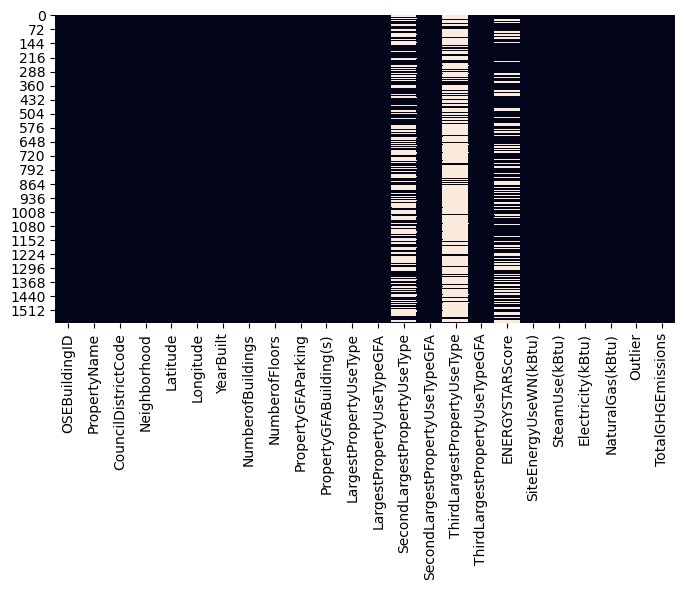

In [82]:

'''
#------------------------------
# Graphique valeurs manquantes
#------------------------------
'''
plt.figure(figsize=(8,4))
sns.heatmap(analyse_BEB_2016.isnull(), cbar=False, cmap="rocket")
plt.show()


<a id='analyse_exploratoire'></a>

---
---

# <span style='background:#26467a'><span style='color:white'>**Analyse exploratoire** </span></span>


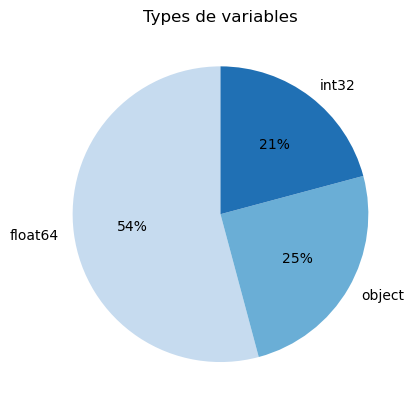

In [83]:
#Type de données

dTypes = info_analyse_BEB_2016['Type'].value_counts()
blues3 = sns.color_palette(palette="Blues", n_colors =3)

plt.pie(dTypes.values.tolist(), labels=['float64', 'object','int32'], colors = blues3, autopct='%.0f%%', startangle=90)
plt.title("Types de variables")
plt.show()

<a id='analyse_univariée'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Analyse Univariée</span>

<a id='uni_variables_qualitatives'></a>

### <span style='background:#358ab7'><span style='color:white'>**Variables qualitatives**</span></span>

In [84]:

#Selection des variables qualitatives
variables_qualitatives=analyse_BEB_2016.select_dtypes(include=['object']).drop(columns="PropertyName")


Neighborhood,nombre_entrees,frequence (%)
DOWNTOWN,353,22.355921
GREATER DUWAMISH,330,20.899303
MAGNOLIA / QUEEN ANNE,149,9.436352
LAKE UNION,143,9.056365
NORTHEAST,121,7.663078
EAST,117,7.409753
NORTHWEST,82,5.193160
NORTH,66,4.179861
BALLARD,63,3.989867
CENTRAL,49,3.103230


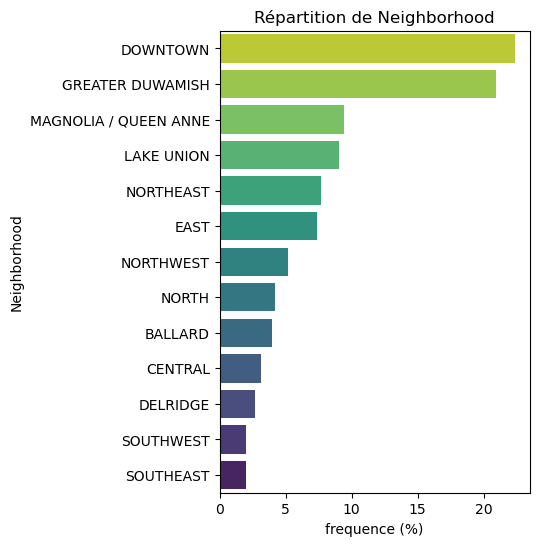

In [85]:

quali_tableau_repartition(variables_qualitatives, "Neighborhood")


LargestPropertyUseType,nombre_entrees,frequence (%)
Office,485,30.715643
Non-Refrigerated Warehouse,197,12.476251
Other,98,6.206460
Retail Store,93,5.889804
Hotel,71,4.496517
Worship Facility,69,4.369854
Distribution Center,54,3.419886
K-12 School,50,3.166561
Senior Care Community,44,2.786574
Supermarket/Grocery Store,41,2.596580


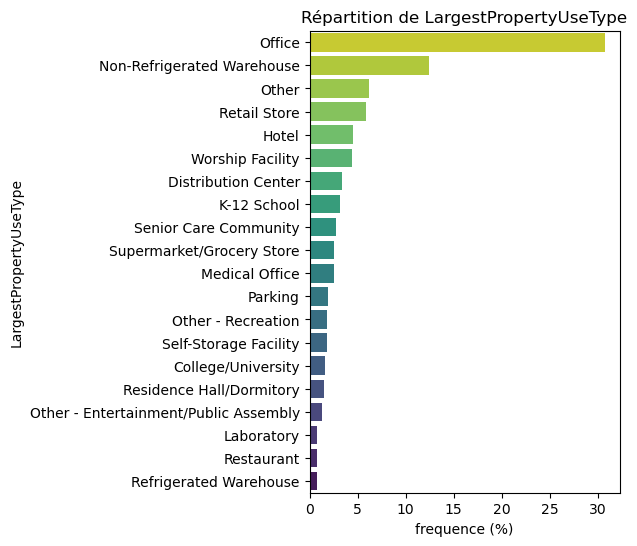

In [86]:

quali_tableau_repartition(variables_qualitatives, "LargestPropertyUseType")


SecondLargestPropertyUseType,nombre_entrees,frequence (%)
Parking,345,21.849272
Office,168,10.639645
Retail Store,84,5.319823
Other,43,2.723243
Restaurant,30,1.899937
Non-Refrigerated Warehouse,28,1.773274
Fitness Center/Health Club/Gym,16,1.013300
Multifamily Housing,12,0.759975
Data Center,12,0.759975
Other - Services,11,0.696643


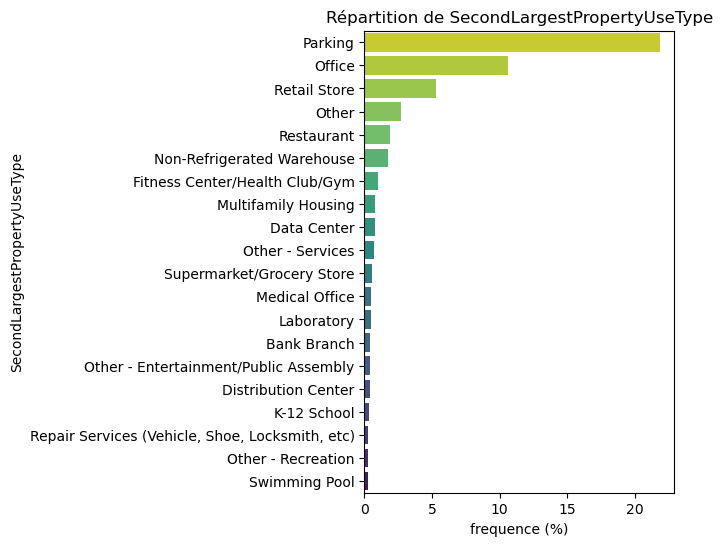

In [87]:

quali_tableau_repartition(variables_qualitatives, "SecondLargestPropertyUseType")


ThirdLargestPropertyUseType,nombre_entrees,frequence (%)
Office,50,3.166561
Retail Store,47,2.976567
Parking,41,2.596580
Other,39,2.469918
Restaurant,32,2.026599
Non-Refrigerated Warehouse,14,0.886637
Data Center,13,0.823306
Multifamily Housing,12,0.759975
NaN,12,0.759975
Medical Office,9,0.569981


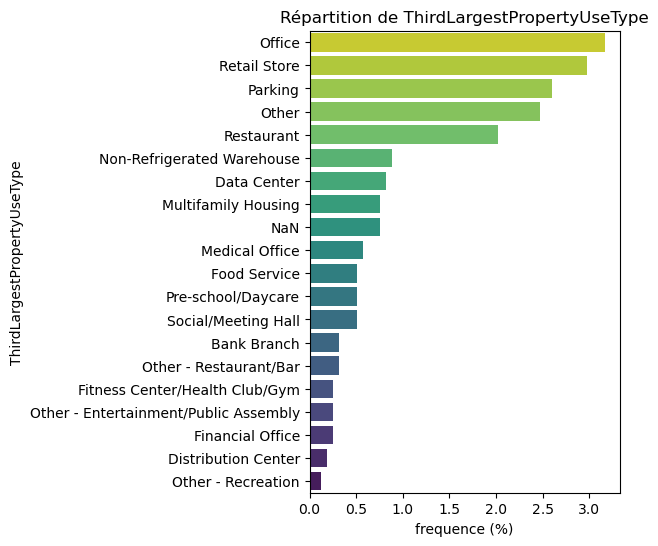

In [88]:

quali_tableau_repartition(variables_qualitatives, "ThirdLargestPropertyUseType")


In [89]:

# Listes utilisations
largestUse = analyse_BEB_2016["LargestPropertyUseType"].unique().tolist()
secondUse = analyse_BEB_2016["SecondLargestPropertyUseType"].unique().tolist()
thirdUse = analyse_BEB_2016["ThirdLargestPropertyUseType"].unique().tolist()

# Toutes les utilisations
ini_allUses = set(largestUse + secondUse + thirdUse)
print(len(ini_allUses))
ini_allUses


69


{'Adult Education',
 'Automobile Dealership',
 'Bank Branch',
 'Bar/Nightclub',
 'College/University',
 'Convenience Store without Gas Station',
 'Courthouse',
 'Data Center',
 'Distribution Center',
 'Enclosed Mall',
 'Fast Food Restaurant',
 'Financial Office',
 'Fire Station',
 'Fitness Center/Health Club/Gym',
 'Fitness Center/Health Club/Gym with Swimming Pool',
 'Food Sales',
 'Food Service',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'Hotel with Swimming Pool',
 'K-12 School',
 'Laboratory',
 'Library',
 'Lifestyle Center',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Movie Theater',
 'Multifamily Housing',
 'Museum',
 'NaN',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Lodging/Residential',
 'Other - Mall',
 'Other - Public Services',
 'Other - Recreation',
 'Other - Recreation with Swimming Pool',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Other - Technology/Science',
 

 * Les thèrmes dans *LargestPropertyUseType*, *SecondLargestPropertyUseType* et *ThirdLargestPropertyUseType* peuvent être homogénéisés
 * La liste des différentes utilisations est trop longue, nous allons la réduire pour la rendre plus facile à exploiter.

<a id='uni_variables_quantitatives'></a>

### <span style='background:#358ab7'><span style='color:white'>**Variables quantitatives**</span></span>

<font size="+1"><span style='color:#4aadd1'> **Variables cible**</span></font><br>

In [90]:

# Selection des variables cible 
variables_cible = analyse_BEB_2016[['SiteEnergyUseWN(kBtu)', "TotalGHGEmissions"]]
stat_des(variables_cible)


,SiteEnergyUseWN(kBtu),TotalGHGEmissions
Min,0.000000e+00,-0.800000
Max,4.716139e+08,16870.980000
Mean,8.400870e+06,193.250950
Median,2.830650e+06,50.320000
Variance,5.091688e+14,595989.864147
Standard_deviation,2.256477e+07,772.003798
Skewness,1.105078e+01,13.818249
Kurtosis,1.702191e+02,233.707619


**Émissions négatives**

In [91]:

analyse_BEB_2016.loc[analyse_BEB_2016["TotalGHGEmissions"] <0][["SiteEnergyUseWN(kBtu)","TotalGHGEmissions","PropertyName","SteamUse(kBtu)","Electricity(kBtu)", "NaturalGas(kBtu)", "Outlier"]]


,SiteEnergyUseWN(kBtu),TotalGHGEmissions,PropertyName,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier
1515,240132.0938,-0.8,BULLITT CENTER,0.0,-115417.0,0.0,Not


<br>

Recherche sur internet pour vérifier:
[Information trouvée ici](https://bullittcenter.org/2014/04/22/bullitt-center-far-exceeds-energy-goals-in-first-year-of-operations/) *Honored by World Architecture News as the “greenest commercial building in the world,” the Bullitt Center used 75 percent less energy than a new building that meets Seattle’s rigorous energy code. The building used 147,260 kWh of electricity compared to a baseline of 593,891 kWh for a similar building built to code (Source: Seattle City Light). During the same period, the Bullitt Center generated 252,560 kWh of clean, renewable energy from the solar panels on its roof.*

**Il est possible que ce ne soit pas une erreur mais une valeur aberrante.**

---


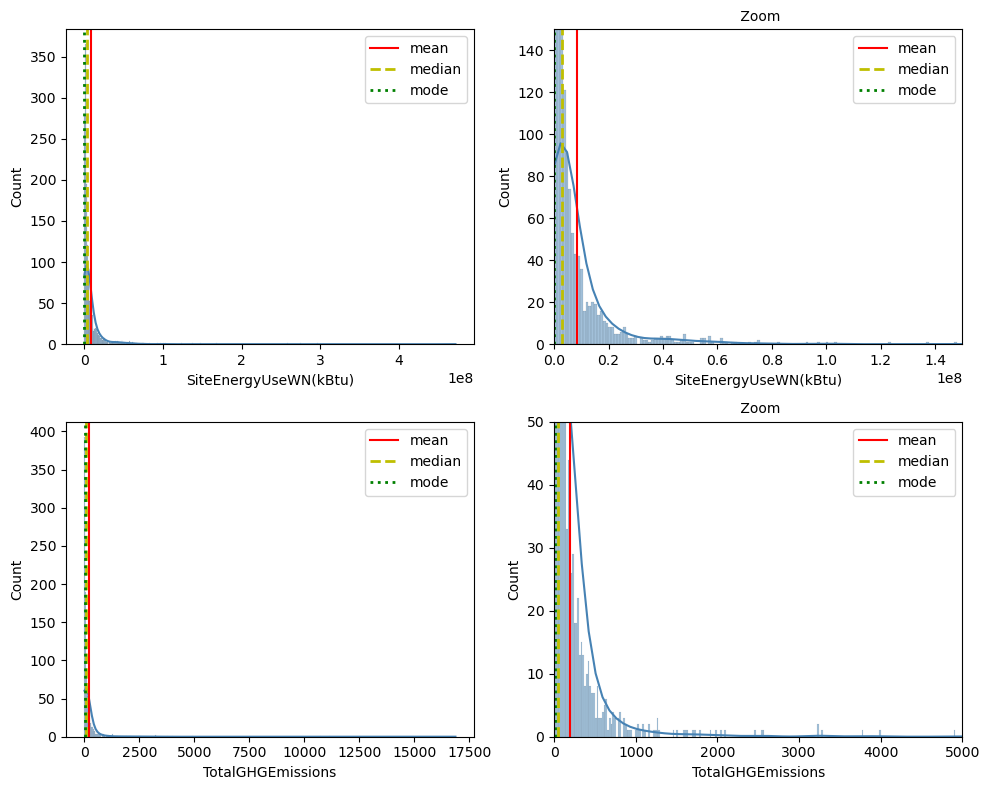

In [92]:

# Analyse graphique des valeurs des variables cible

list_variables_cible = variables_cible.columns.tolist()

#Nombre graphs
nombre_Graphs = len(list_variables_cible)

columns = 2  # nombre colonnes
rows = nombre_Graphs  # nombre lignes
pc = 1  # initialisation du compteur de plots


xlim_bas = [0,0]
xlim_haut = [150000000, 5000]
ylim_bas = [0,0]
ylim_haut = [150,50]

fig = plt.figure(figsize=(10,8))

for vari in range(nombre_Graphs):
        
    plt.subplot(rows, columns, pc)
    sns.histplot(data=variables_cible, x= list_variables_cible[vari], color='SteelBlue', kde=True)
    plt.xlabel(list_variables_cible[vari])
    plt.axvline(x= variables_cible[list_variables_cible[vari]].mean(), color='r', label = 'mean')
    plt.axvline(x= variables_cible[list_variables_cible[vari]].median(), color='y',ls='--', lw=2, label='median')
    plt.axvline(x= variables_cible[list_variables_cible[vari]].mode()[0], color='g',ls=':', lw=2, label ='mode')
    plt.legend()
    pc = pc + 1
    
    plt.subplot(rows, columns, pc)
    sns.histplot(data=variables_cible, x= list_variables_cible[vari], color='SteelBlue', kde=True)
    plt.xlabel(list_variables_cible[vari])
    plt.axvline(x= variables_cible[list_variables_cible[vari]].mean(), color='r', label = 'mean')
    plt.axvline(x= variables_cible[list_variables_cible[vari]].median(), color='y',ls='--', lw=2, label='median')
    plt.axvline(x= variables_cible[list_variables_cible[vari]].mode()[0], color='g',ls=':', lw=2, label ='mode')
    plt.xlim(xlim_bas[vari], xlim_haut[vari])
    plt.ylim(ylim_bas[vari], ylim_haut[vari])
    plt.title(' Zoom', fontsize=10)
    plt.grid(False)
    plt.legend()
    pc = pc + 1


plt.tight_layout()    
plt.show()


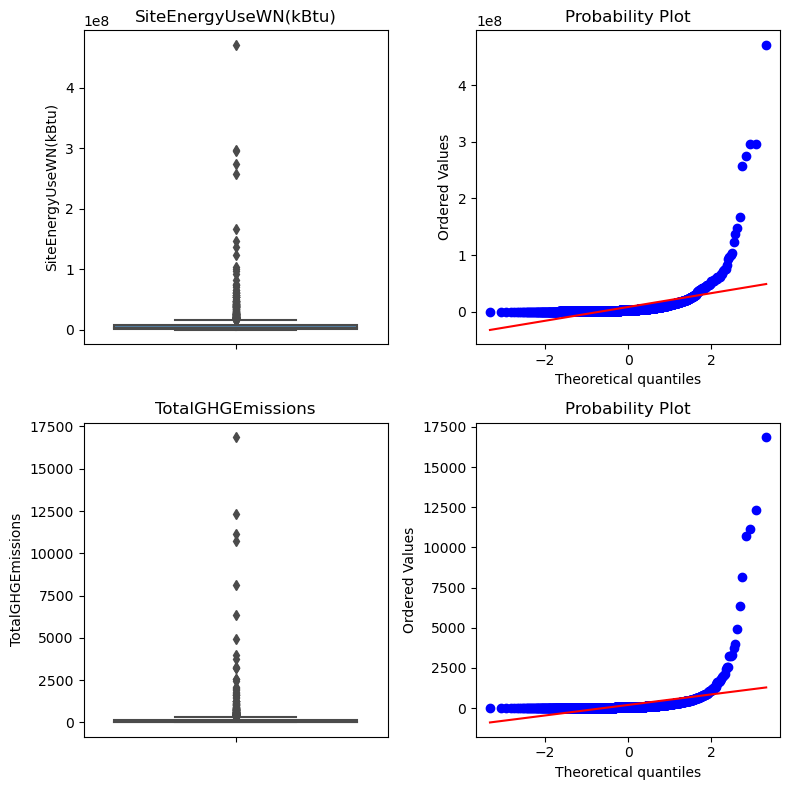

In [93]:

# SUITE: Analyse graphique des valeurs des variables cible
columns = 2  # nombre colonnes
rows = nombre_Graphs  # nombre lignes
pc = 1  # initialisation du compteur de plots


fig = plt.figure(figsize=(8,8))

for vari in range(nombre_Graphs):
    plt.subplot(rows, columns, pc)
    sns.boxplot(data=variables_cible, y= list_variables_cible[vari], color='SteelBlue')
    plt.title(list_variables_cible[vari])
    pc = pc + 1  
   
    plt.subplot(rows, columns, pc)
    stats.probplot(variables_cible[list_variables_cible[vari]], dist="norm", plot=plt)
    plt.title("Probability Plot")
    pc = pc + 1

plt.tight_layout()    
plt.show()


In [94]:

# Test normalité  des variables cible
# test D'Agostino and Pearson's, adapté à échantillons de taille moyenne et grande

#H0: distribution normale

for vari in variables_cible:
    alpha = 0.05
    k2, p = stats.normaltest(variables_cible[vari])
    if p < alpha:  
        print("p = {:g}. ".format(p) + "L'hypothèse nulle peut être réjetée. La distribution de la variable '{}' ne suit pas une distribution normale\n".format(vari))
    else:
        print("p = {:g}. ".format(p)+ "L'hypothèse nulle ne peut pas être réjetée. La distribution de la variable '{}' suit une distribution normale\n".format(vari))


p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'SiteEnergyUseWN(kBtu)' ne suit pas une distribution normale

p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'TotalGHGEmissions' ne suit pas une distribution normale



---

 * D'après le test D'Agostino et l'analyse graphique ; ces variables ne présentent pas une distribution normale
 
 * Le unités et amplitudes des distributions sont très differents; le variables doivent être standardisées

 * Les deux variables présentent une kurtosis positive et une importante asymétrie (skewness) positive.
 
 * L'analyse graphique de la distribution des données montre l'existence de valeurs aberrantes dans les deux cas. Pour éviter l'impact de ces valeurs aberrantes sur la permormance des modélisations, elles sont supprimées. Les valeurs de 150000KBtu pour la consommation et de 5000T pour l'émission sont fixées comme limites.


---
---


<font size="+1"><span style='color:#4aadd1'> **Variables quantitatives continues**</span></font><br>


In [95]:

# Création tableau avec les données assoicées aux variables quantitatives continues
# Les variables cible seront explorées séparement
variables_quantitatives_conti = analyse_BEB_2016.select_dtypes(include=['float64']).drop(columns=['SiteEnergyUseWN(kBtu)', "TotalGHGEmissions"])
stat_des(variables_quantitatives_conti)


,Latitude,Longitude,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
Min,47.509590,-122.411820,0.000000e+00,3.636000e+03,3.997000e+03,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,-1.154170e+05,0.000000e+00
Max,47.733870,-122.261800,5.473158e+05,9.320156e+06,9.320156e+06,8.829850e+05,4.597480e+05,100.000000,1.349435e+08,6.570744e+08,2.979090e+08
Mean,47.617062,-122.333402,1.659509e+04,1.102502e+05,9.926731e+04,2.178280e+04,3.328651e+03,63.816047,5.482839e+05,6.086752e+06,2.042871e+06
Median,47.612970,-122.333040,0.000000e+00,4.736800e+04,4.320000e+04,1.792000e+03,0.000000e+00,71.000000,0.000000e+00,1.749609e+06,5.037650e+05
Variance,0.002232,0.000545,2.553279e+09,8.677053e+10,7.775190e+10,3.418399e+09,3.401253e+08,828.991602,3.213487e+13,4.538200e+14,9.256666e+13
Standard_deviation,0.047248,0.023355,5.052998e+04,2.945684e+05,2.788403e+05,5.846708e+04,1.844249e+04,28.792214,5.668762e+06,2.130305e+07,9.621157e+06
Skewness,0.260767,-0.130075,4.926636e+00,2.051162e+01,2.374540e+01,5.982583e+00,1.510646e+01,-0.667185,1.855624e+01,2.041323e+01,2.150411e+01
Kurtosis,-0.150702,0.872443,3.079048e+01,6.088449e+02,7.600874e+02,5.276608e+01,3.038167e+02,-0.671746,3.844932e+02,5.728235e+02,5.988977e+02


In [96]:

analyse_BEB_2016.loc[analyse_BEB_2016["Electricity(kBtu)"] <0][["SiteEnergyUseWN(kBtu)","TotalGHGEmissions","PropertyName","SteamUse(kBtu)","Electricity(kBtu)", "NaturalGas(kBtu)", "Outlier"]]


,SiteEnergyUseWN(kBtu),TotalGHGEmissions,PropertyName,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier
1515,240132.0938,-0.8,BULLITT CENTER,0.0,-115417.0,0.0,Not


<br>

La valeur négative de la consommation d'électricité correspond à la même propriété qui a des émissions négatives.
Il est possible que ce ne soit pas une erreur mais une valeur aberrante.

---


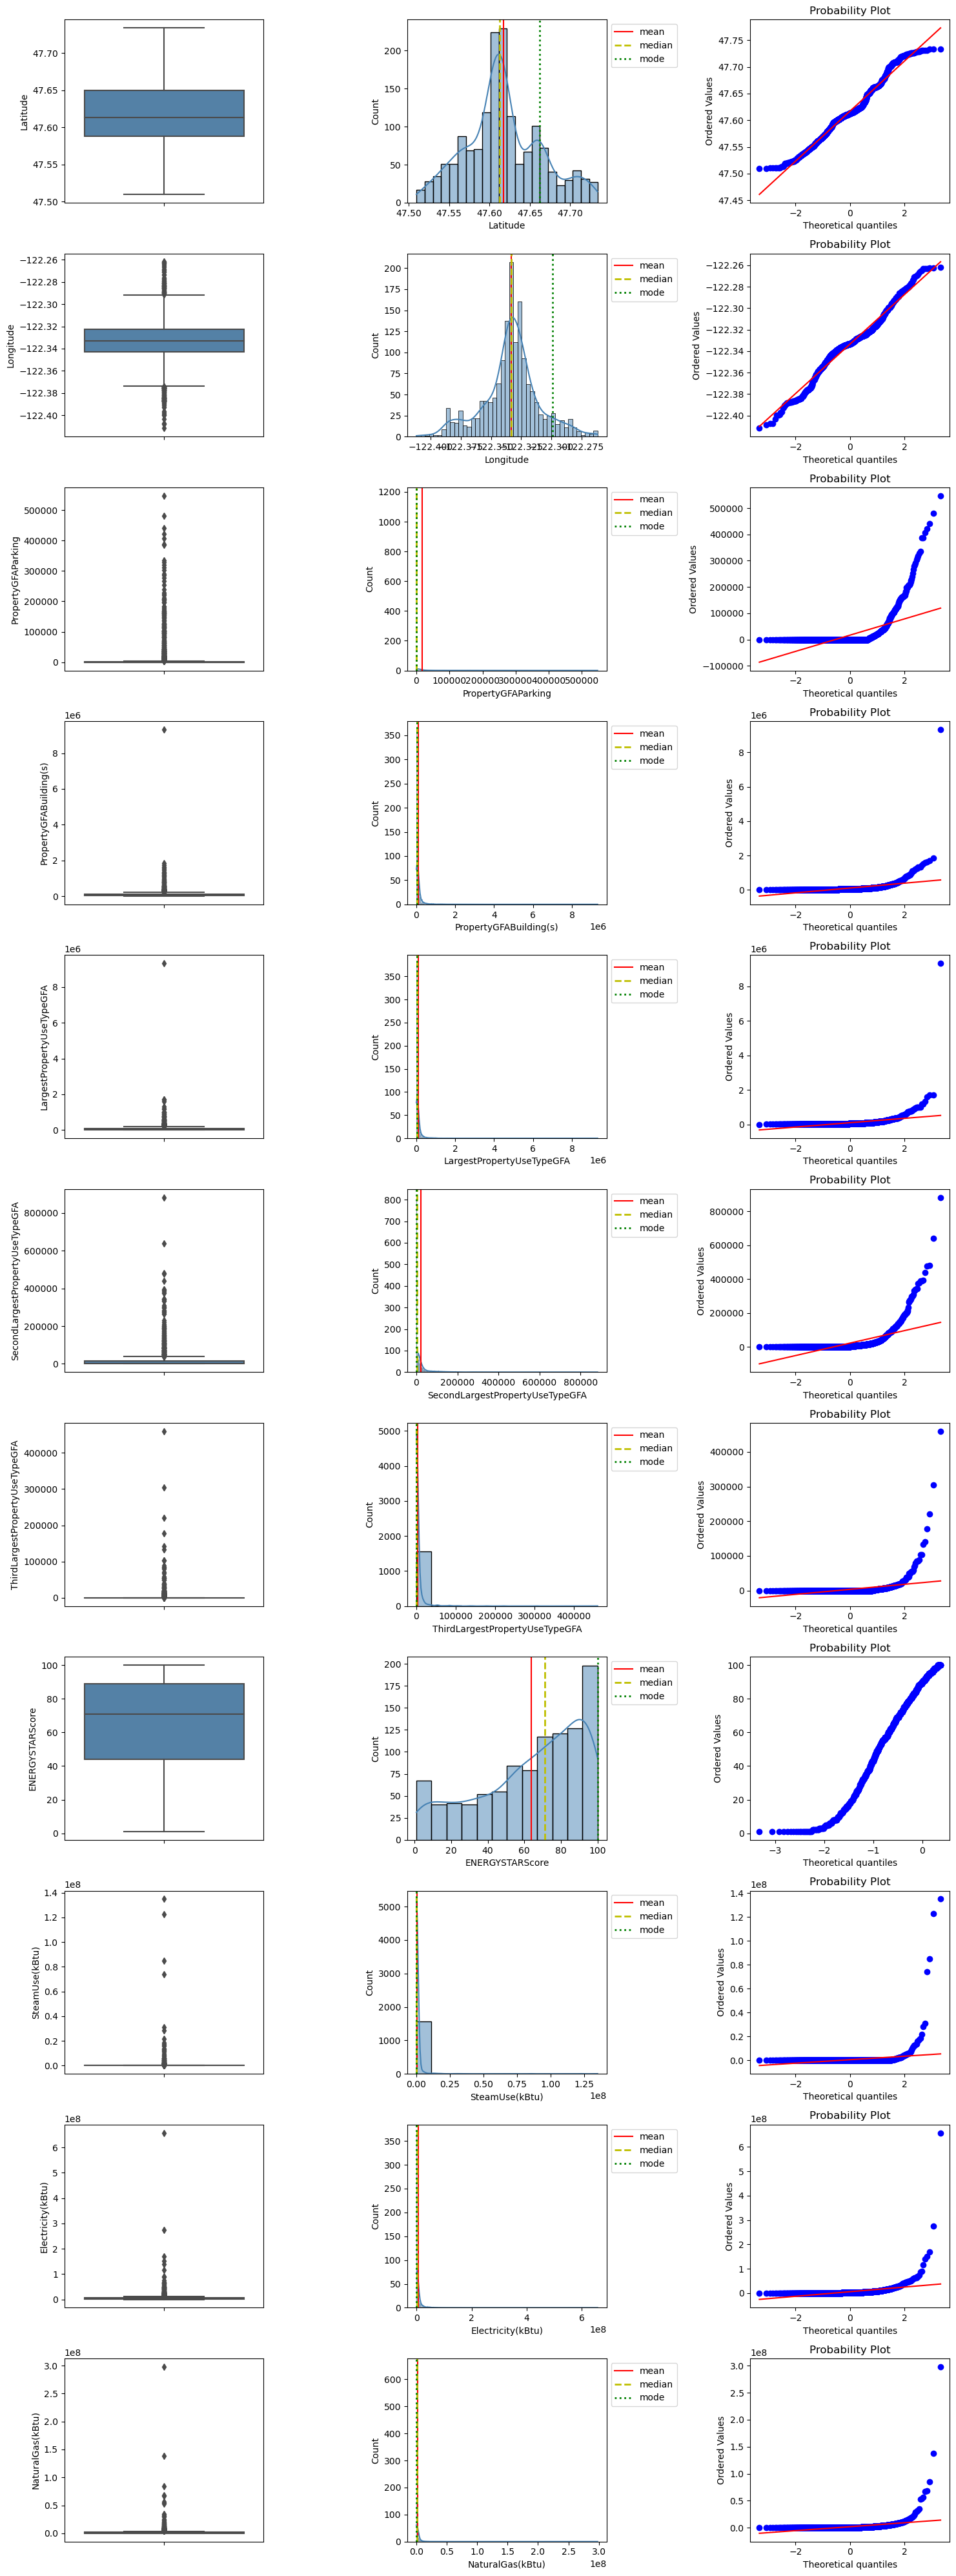

In [97]:

# Analyse graphique des valeurs des variables cible

list_variables_quantitatives_conti = variables_quantitatives_conti.columns.tolist()

#Nombre graphs
nombre_Graphs = len(list_variables_quantitatives_conti)

columns = 3  # nombre colonnes
rows = nombre_Graphs  # nombre lignes
pc = 1  # initialisation du compteur de plots

fig = plt.figure(figsize=(15,40))

for vari in range(nombre_Graphs):
    plt.subplot(rows, columns, pc)
    sns.boxplot(data=variables_quantitatives_conti, y= list_variables_quantitatives_conti[vari], color='SteelBlue')
    plt.xlabel("")
    plt.ylabel(list_variables_quantitatives_conti[vari])
    pc = pc + 1
    
    plt.subplot(rows, columns, pc)
    sns.histplot(data=variables_quantitatives_conti, x= list_variables_quantitatives_conti[vari], color='SteelBlue', kde=True)
    plt.xlabel(list_variables_quantitatives_conti[vari])
    plt.axvline(x= variables_quantitatives_conti[list_variables_quantitatives_conti[vari]].mean(), color='r', label = 'mean')
    plt.axvline(x= variables_quantitatives_conti[list_variables_quantitatives_conti[vari]].median(), color='y',ls='--', lw=2, label='median')
    plt.axvline(x= variables_quantitatives_conti[list_variables_quantitatives_conti[vari]].mode()[0], color='g',ls=':', lw=2, label ='mode')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    pc = pc + 1
    
    plt.subplot(rows, columns, pc)
    stats.probplot(variables_quantitatives_conti[list_variables_quantitatives_conti[vari]], dist="norm", plot=plt)
    plt.title("Probability Plot")
    pc = pc + 1

plt.tight_layout()    
plt.show()


In [98]:

# Test normalité  des variables 
# test D'Agostino and Pearson's, adapté à échantillons de taille moyenne et grande

#H0: distribution normale

for vari in variables_quantitatives_conti:
    alpha = 0.05
    k2, p = stats.normaltest(variables_quantitatives_conti[vari])
    if p < alpha:  
        print("p = {:g}. ".format(p) + "L'hypothèse nulle peut être réjetée. La distribution de la variable '{}' ne suit pas une distribution normale\n".format(vari))
    else:
        print("p = {:g}. ".format(p)+ "L'hypothèse nulle ne peut pas être réjetée. La distribution de la variable '{}' suit une distribution normale\n".format(vari))


p = 7.22361e-05. L'hypothèse nulle peut être réjetée. La distribution de la variable 'Latitude' ne suit pas une distribution normale

p = 2.08582e-07. L'hypothèse nulle peut être réjetée. La distribution de la variable 'Longitude' ne suit pas une distribution normale

p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'PropertyGFAParking' ne suit pas une distribution normale

p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'PropertyGFABuilding(s)' ne suit pas une distribution normale

p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'LargestPropertyUseTypeGFA' ne suit pas une distribution normale

p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'SecondLargestPropertyUseTypeGFA' ne suit pas une distribution normale

p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'ThirdLargestPropertyUseTypeGFA' ne suit pas une distribution normale

p = nan. L'hypothèse null

---

 * D'après le test D'Agostino et l'analyse graphique ; ces variables ne présentent pas une distribution normale
 
 * Le unités et amplitudes des distributions sont très differents; le variables doivent être standardisées

---
---


---

<font size="+1"><span style='color:#4aadd1'> **Variables quantitatives discrètes**</span></font><br>


In [99]:

# Création tableau avec les données assoicées aux variables quantitatives discrètes
variables_quantita_discretes = analyse_BEB_2016.select_dtypes(include=['int32']).drop(columns=['OSEBuildingID'])


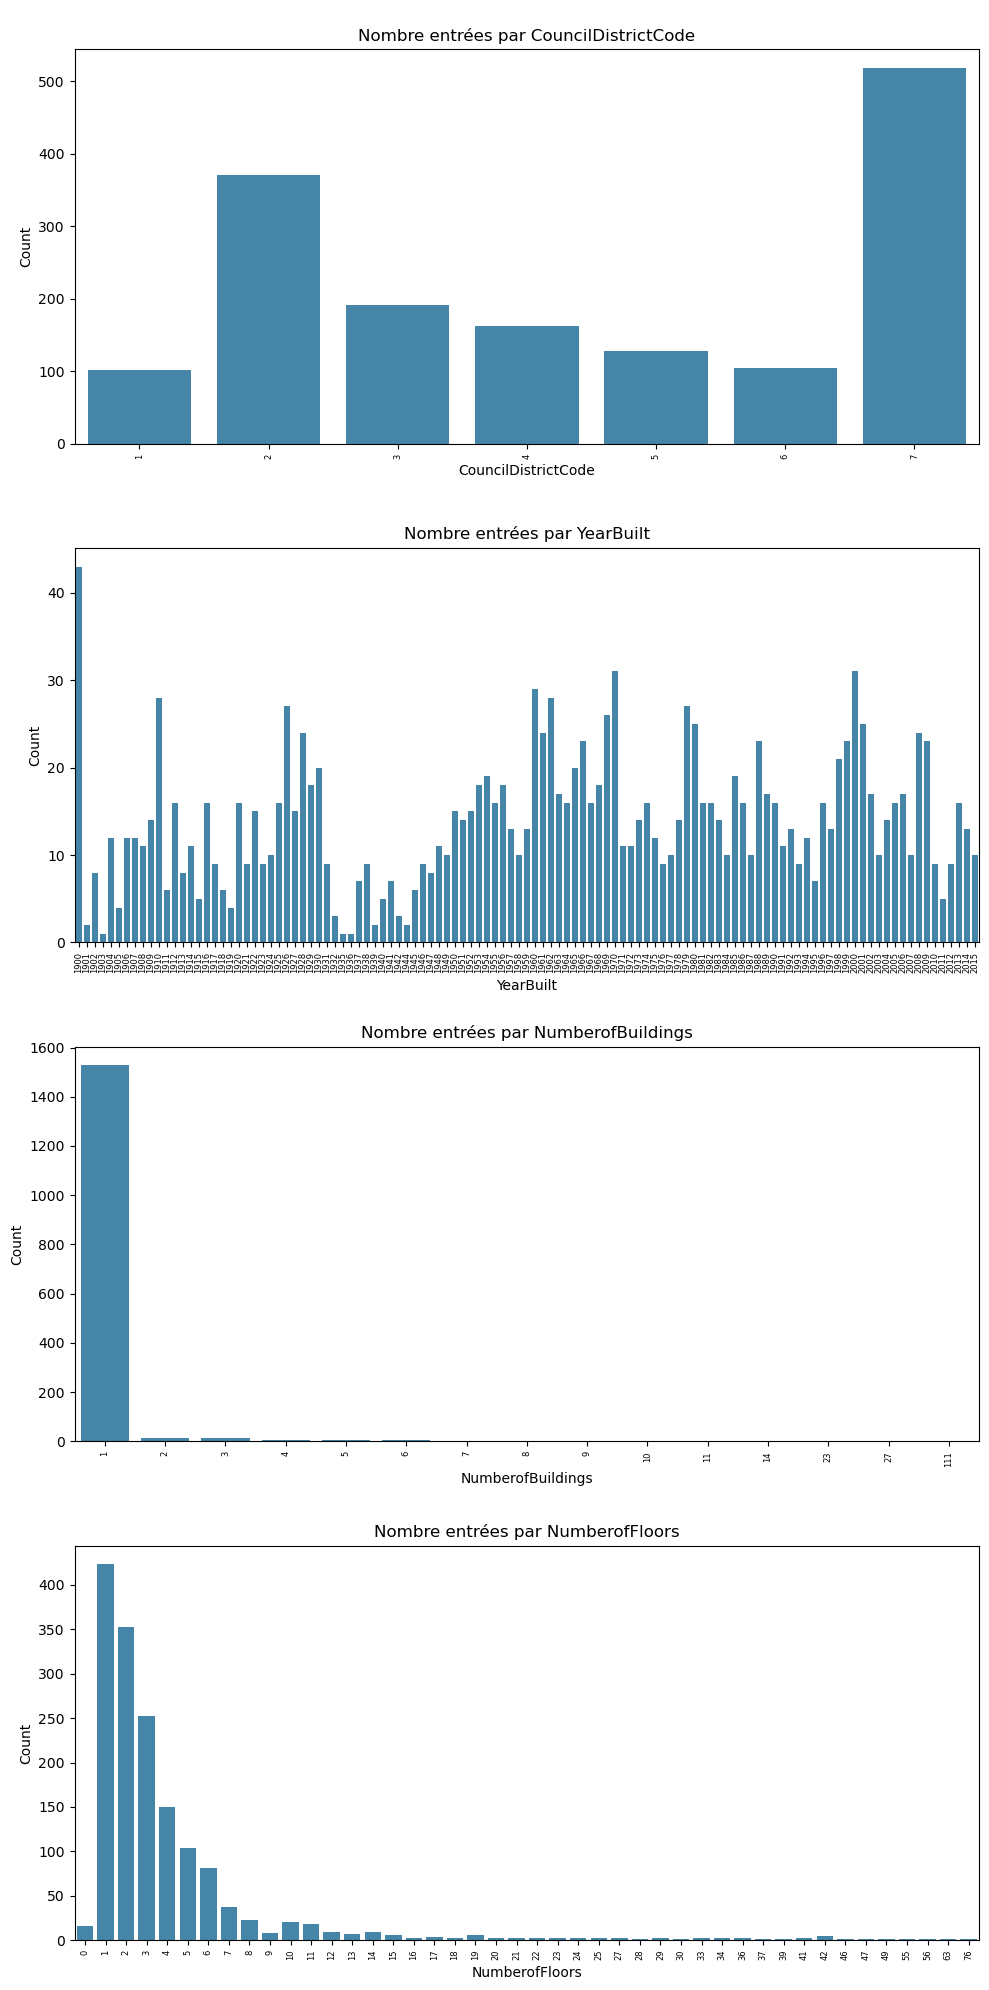

In [100]:

list_variables_quantita_discretes = variables_quantita_discretes.columns.tolist()

#Nombre graphs
nombre_Graphs = len(list_variables_quantita_discretes)

columns = 1  # nombre colonnes
rows = nombre_Graphs  # nombre lignes
pc = 1  # initialisation du compteur de plots

fig = plt.figure(figsize=(10,20))

for vari in range(nombre_Graphs):
    plt.subplot(rows, columns, pc)
    sns.countplot(x=variables_quantita_discretes[list_variables_quantita_discretes[vari]], color ='#358ab7',label='small')
    plt.title("\nNombre entrées par " + str(list_variables_quantita_discretes[vari]))
    plt.ylabel("Count")
    plt.xlabel(list_variables_quantita_discretes[vari])
    plt.xticks(rotation = 90, fontsize=6)
    pc = pc + 1  

plt.tight_layout()    
plt.show()


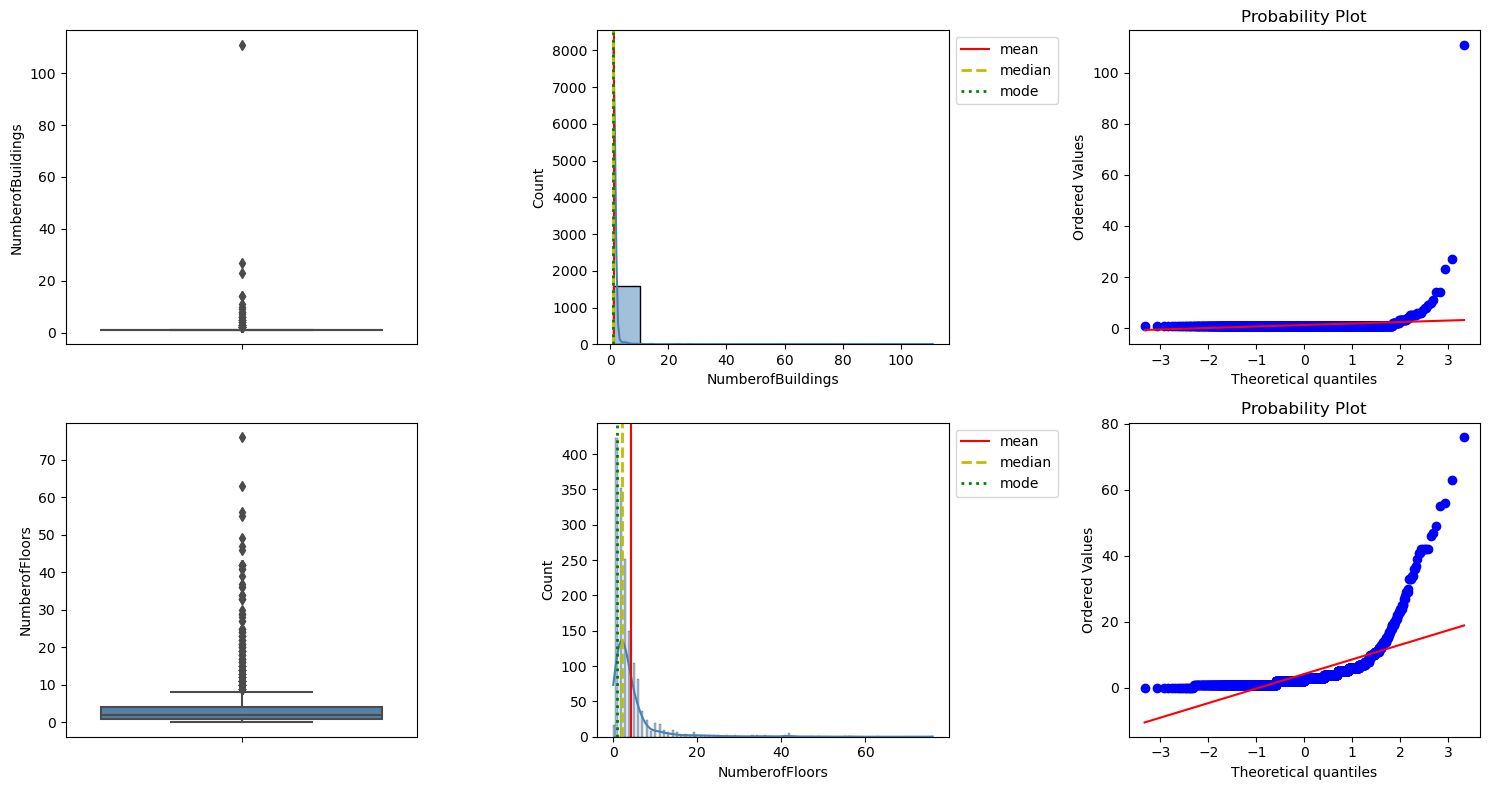

In [101]:

# Analyse graphique des valeurs des variables cible

variables_quantita_discr = analyse_BEB_2016.select_dtypes(include=['int32']).drop(columns=['OSEBuildingID', "CouncilDistrictCode", "YearBuilt"])


list_variables_quantitatives_discr = variables_quantita_discr.columns.tolist()

#Nombre graphs
nombre_Graphs = len(list_variables_quantitatives_discr)

columns = 3  # nombre colonnes
rows = nombre_Graphs  # nombre lignes
pc = 1  # initialisation du compteur de plots

fig = plt.figure(figsize=(15,8))

for vari in range(nombre_Graphs):
    plt.subplot(rows, columns, pc)
    sns.boxplot(data=variables_quantita_discr, y= list_variables_quantitatives_discr[vari], color='SteelBlue')
    plt.xlabel("")
    plt.ylabel(list_variables_quantitatives_discr[vari])
    pc = pc + 1
    
    plt.subplot(rows, columns, pc)
    sns.histplot(data=variables_quantita_discr, x= list_variables_quantitatives_discr[vari], color='SteelBlue', kde=True)
    plt.xlabel(list_variables_quantitatives_discr[vari])
    plt.axvline(x= variables_quantita_discr[list_variables_quantitatives_discr[vari]].mean(), color='r', label = 'mean')
    plt.axvline(x= variables_quantita_discr[list_variables_quantitatives_discr[vari]].median(), color='y',ls='--', lw=2, label='median')
    plt.axvline(x= variables_quantita_discr[list_variables_quantitatives_discr[vari]].mode()[0], color='g',ls=':', lw=2, label ='mode')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    pc = pc + 1
    
    plt.subplot(rows, columns, pc)
    stats.probplot(variables_quantita_discr[list_variables_quantitatives_discr[vari]], dist="norm", plot=plt)
    plt.title("Probability Plot")
    pc = pc + 1

plt.tight_layout()    
plt.show()

In [102]:

# Test normalité  des variables 
# test D'Agostino and Pearson's, adapté à échantillons de taille moyenne et grande

#H0: distribution normale

for vari in variables_quantita_discr:
    alpha = 0.05
    k2, p = stats.normaltest(variables_quantita_discr[vari])
    if p < alpha:  
        print("p = {:g}. ".format(p) + "L'hypothèse nulle peut être réjetée. La distribution de la variable '{}' ne suit pas une distribution normale\n".format(vari))
    else:
        print("p = {:g}. ".format(p)+ "L'hypothèse nulle ne peut pas être réjetée. La distribution de la variable '{}' suit une distribution normale\n".format(vari))


p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'NumberofBuildings' ne suit pas une distribution normale

p = 0. L'hypothèse nulle peut être réjetée. La distribution de la variable 'NumberofFloors' ne suit pas une distribution normale



---

 * D'après le test D'Agostino et l'analyse graphique ; ces variables ne présentent pas une distribution normale
 
 * Le unités et amplitudes des distributions sont très differents; le variables doivent être standardisées

---
---

<a id='analyse_multivariée'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Analyse Multivariée</span>

<a id='multi_variables_quantitatives'></a>

### <span style='background:#358ab7'><span style='color:white'>**Variables quantitatives**</span></span>

In [103]:

# Matrice de corrélation de toutes les variables quantitatives
vari_num_corr = analyse_BEB_2016.select_dtypes(include=['float64', 'int32']).corr().round(2)


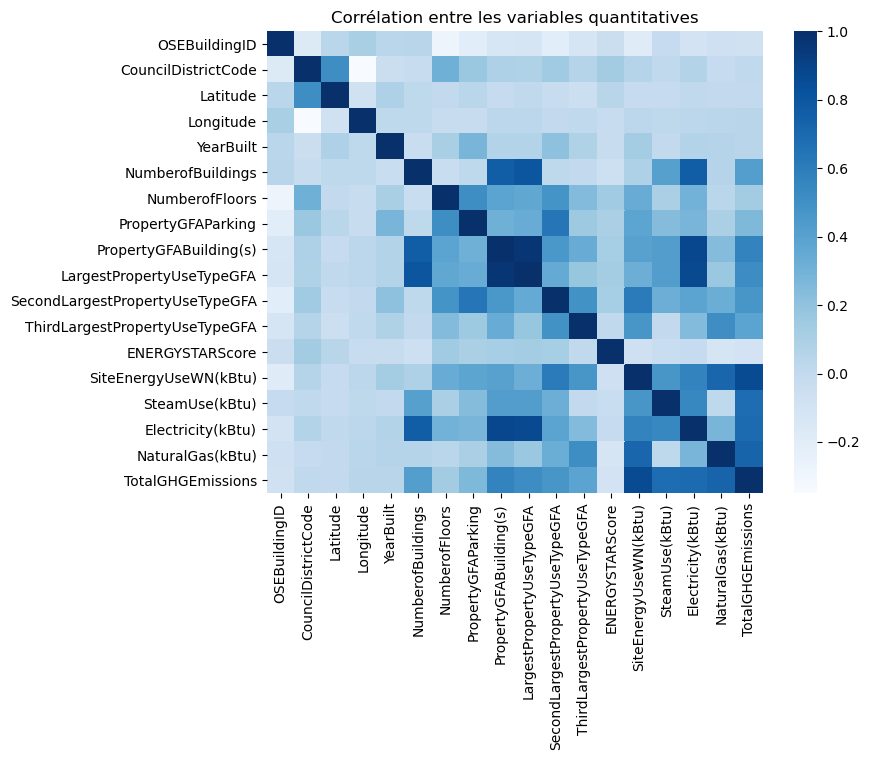

In [104]:
plt.figure(figsize=(8,6))
sns.heatmap(vari_num_corr, cmap="Blues")

plt.title("Corrélation entre les variables quantitatives")
plt.tight_layout                     
plt.show()

In [105]:

#Analyse facteur correlation supérieur à |0.85|

for vari in vari_num_corr.columns.tolist()[1:]:
    high_correl = vari_num_corr.loc[(vari_num_corr[vari]>0.85)|(vari_num_corr[vari]<-0.85)]
    if high_correl.shape[0] >1:
        print(str(vari) +" est correlée à " + str(high_correl.index.tolist()) + str(high_correl[vari].values.tolist()) + "\n")
    else:
        pass


PropertyGFABuilding(s) est correlée à ['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'Electricity(kBtu)'][1.0, 0.97, 0.88]

LargestPropertyUseTypeGFA est correlée à ['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'Electricity(kBtu)'][0.97, 1.0, 0.87]

SiteEnergyUseWN(kBtu) est correlée à ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'][1.0, 0.86]

Electricity(kBtu) est correlée à ['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'Electricity(kBtu)'][0.88, 0.87, 1.0]

TotalGHGEmissions est correlée à ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'][0.86, 1.0]



**Bilan correlation variables quantitatives**

* La **superficie des bâtiments** (PropertyGFABuilding(s)) est correlée à:<br>
        La superficie de l'utilisation principale (LargestPropertyUseTypeGFA), facteur de correlation 0.97<br>
        La consomation d'éléctricité (Electricity(kBtu)), facteur de correlation 0.88<br>
        
* La **consommation d'électricité** (Electricity(kBtu)) est correlée à:<br>
        La superficie de l'utilisation principaElectricity(kBtu)le (LargestPropertyUseTypeGFA), facteur de correlation 0.87 <br>       
        
* La **consommation totale d'énergie normalisée en fonction des conditions climatiques** (SiteEnergyUseWN(kBtu)) est correlée à:<br>
        Aux émmissions totales (TotalGHGEmissions), facteur de correlation 0.86<br>
<br>        


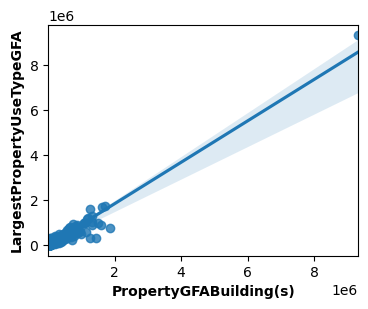

In [106]:

#Analyse Colinéarité PropertyGFABuilding(s) / LargestPropertyUseTypeGFA

plt.figure(figsize=(4,3))

sns.regplot(data=analyse_BEB_2016, x='PropertyGFABuilding(s)', y='LargestPropertyUseTypeGFA')
plt.xlabel('PropertyGFABuilding(s)', fontweight='bold')
plt.ylabel('LargestPropertyUseTypeGFA', fontweight='bold')
plt.show()

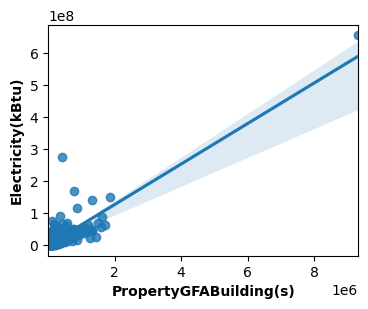

In [107]:

#Analyse Colinéarité PropertyGFABuilding(s) / Electricity(kBtu)

plt.figure(figsize=(4,3))

sns.regplot(data=analyse_BEB_2016, x='PropertyGFABuilding(s)', y='Electricity(kBtu)')
plt.xlabel('PropertyGFABuilding(s)', fontweight='bold')
plt.ylabel('Electricity(kBtu)', fontweight='bold')
plt.show()

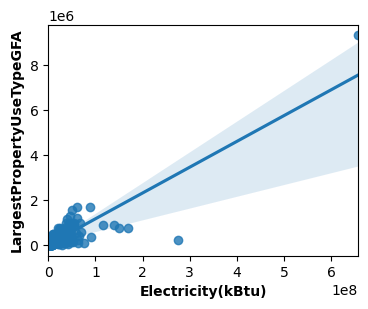

In [108]:

#Analyse Colinéarité Electricity(kBtu) / LargestPropertyUseTypeGFA

plt.figure(figsize=(4,3))

sns.regplot(data=analyse_BEB_2016, x='Electricity(kBtu)', y='LargestPropertyUseTypeGFA')
plt.xlabel('Electricity(kBtu)', fontweight='bold')
plt.ylabel('LargestPropertyUseTypeGFA', fontweight='bold')
plt.show()

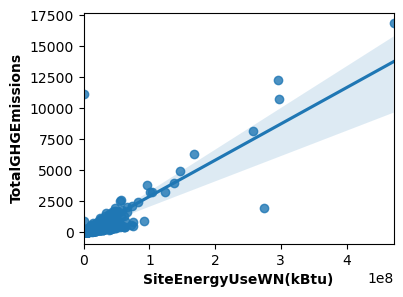

In [109]:

#Analyse Colinéarité SiteEnergyUseWN(kBtu) / TotalGHGEmissions

plt.figure(figsize=(4,3))

sns.regplot(data=analyse_BEB_2016, x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions')
plt.xlabel('SiteEnergyUseWN(kBtu)', fontweight='bold')
plt.ylabel('TotalGHGEmissions', fontweight='bold')
plt.show()

<a id='multi_variables_qualitatives'></a>

### <span style='background:#358ab7'><span style='color:white'>**Variables qualitatives**</span></span>

In [110]:

# Rélation "Disctrict Code" et "Neighborhood"
District_neighborhood = analyse_BEB_2016.groupby(["CouncilDistrictCode"])["Neighborhood"].unique().to_frame()
District_neighborhood


,Neighborhood
CouncilDistrictCode,
1,"[SOUTHWEST, DELRIDGE, GREATER DUWAMISH]"
2,"[GREATER DUWAMISH, DOWNTOWN, SOUTHEAST, EAST]"
3,"[DOWNTOWN, EAST, CENTRAL, LAKE UNION, SOUTHEAS..."
4,"[NORTHEAST, LAKE UNION, NORTH]"
5,"[NORTHWEST, NORTH, NORTHEAST]"
6,"[BALLARD, NORTHWEST, LAKE UNION]"
7,"[DOWNTOWN, EAST, MAGNOLIA / QUEEN ANNE, LAKE U..."


 * Aucune relation unique ne peut être établie entre les districts et les quartiers.
 * **Nous retenons les deux variables**

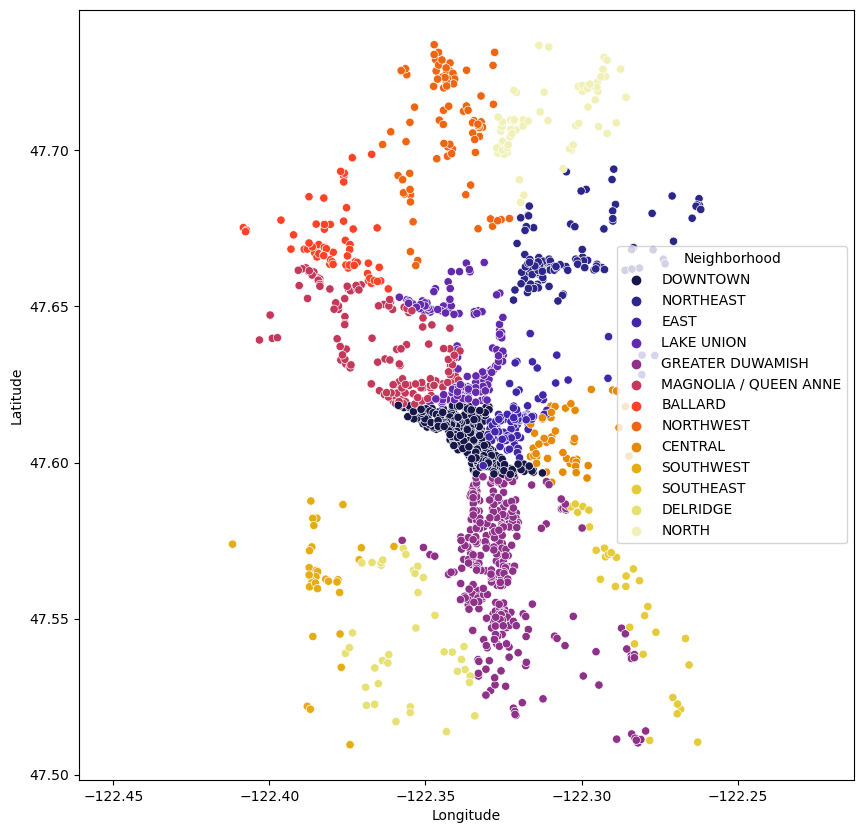

In [111]:

# Rélation "Neighborhood" et "Latitude"/"Longitude" 
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(data=analyse_BEB_2016,
    x = 'Longitude', y = 'Latitude', hue = 'Neighborhood',  palette = sns.color_palette('CMRmap', 13))
plt.axis('equal')
plt.show()


<a id='feature_engineering'></a>

---
---

# <span style='background:#26467a'><span style='color:white'>**Feature engineering** </span></span>


<a id='variables_cible'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Variables cible</span>

In [112]:
analyse_BEB_2016.shape

(1579, 24)

In [113]:

# Suppression valeurs aberrants
Lim_sup_conso = 150000000
Lim_sup_emi =  5000

OutL_analyse_BEB_2016 = analyse_BEB_2016[analyse_BEB_2016["SiteEnergyUseWN(kBtu)"] < Lim_sup_conso]

OutL_analyse_BEB_2016 = OutL_analyse_BEB_2016[analyse_BEB_2016["TotalGHGEmissions"] < Lim_sup_emi]

OutL_analyse_BEB_2016.shape


(1572, 24)

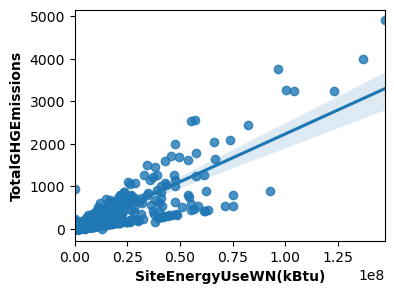

In [114]:

#Analyse Colinéarité après la suppresion des valeurs aberrants SiteEnergyUseWN(kBtu) / TotalGHGEmissions

plt.figure(figsize=(4,3))

sns.regplot(data=OutL_analyse_BEB_2016, x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions')
plt.xlabel('SiteEnergyUseWN(kBtu)', fontweight='bold')
plt.ylabel('TotalGHGEmissions', fontweight='bold')
plt.show()

<a id='consomation'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Consomation</span>


Pour éviter la fuite de données on transformera ces variables en pourcentage sur le total de la consomation de la proprieté


In [115]:

# Pourcentage de vapeur sur le total de la consomation énergetique
OutL_analyse_BEB_2016["SteamUse%"] = 100 * OutL_analyse_BEB_2016["SteamUse(kBtu)"] / (OutL_analyse_BEB_2016["SteamUse(kBtu)"]+OutL_analyse_BEB_2016["Electricity(kBtu)"]+OutL_analyse_BEB_2016["NaturalGas(kBtu)"])
OutL_analyse_BEB_2016["SteamUse%"] = OutL_analyse_BEB_2016["SteamUse%"].fillna(0)

# Pourcentage électricité sur le total de la consomation énergetique
OutL_analyse_BEB_2016["Electricity%"] = 100 * OutL_analyse_BEB_2016["Electricity(kBtu)"] / (OutL_analyse_BEB_2016["SteamUse(kBtu)"]+OutL_analyse_BEB_2016["Electricity(kBtu)"]+OutL_analyse_BEB_2016["NaturalGas(kBtu)"])
OutL_analyse_BEB_2016["Electricity%"] = OutL_analyse_BEB_2016["Electricity%"].fillna(0)

# Pourcentage de gaz sur le total de la consomation énergetique
OutL_analyse_BEB_2016["NaturalGas%"] = 100 * OutL_analyse_BEB_2016["NaturalGas(kBtu)"] / (OutL_analyse_BEB_2016["SteamUse(kBtu)"]+OutL_analyse_BEB_2016["Electricity(kBtu)"]+OutL_analyse_BEB_2016["NaturalGas(kBtu)"])
OutL_analyse_BEB_2016["NaturalGas%"] = OutL_analyse_BEB_2016["NaturalGas%"].fillna(0)


**Les variables SteamUse(kBtu); Electricity(kBtu) et NaturalGas(kBtu) sont à supprimer**

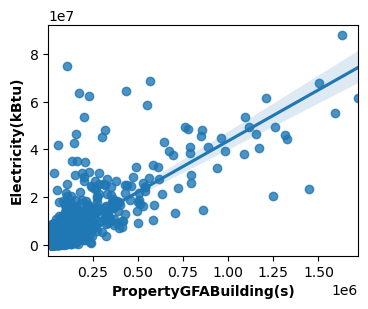

In [116]:

#Analyse Colinéarité PropertyGFABuilding(s) / Electricity(kBtu)

plt.figure(figsize=(4,3))

sns.regplot(data=OutL_analyse_BEB_2016, x='PropertyGFABuilding(s)', y='Electricity(kBtu)')
plt.xlabel('PropertyGFABuilding(s)', fontweight='bold')
plt.ylabel('Electricity(kBtu)', fontweight='bold')
plt.show()

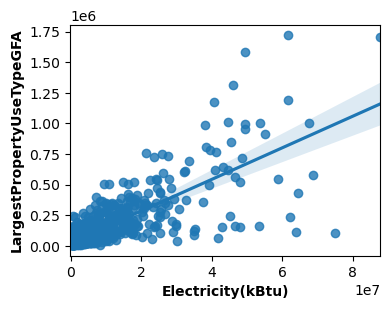

In [117]:

#Analyse Colinéarité Electricity(kBtu) / LargestPropertyUseTypeGFA

plt.figure(figsize=(4,3))

sns.regplot(data=OutL_analyse_BEB_2016, x='Electricity(kBtu)', y='LargestPropertyUseTypeGFA')
plt.xlabel('Electricity(kBtu)', fontweight='bold')
plt.ylabel('LargestPropertyUseTypeGFA', fontweight='bold')
plt.show()

<a id='age_propriété'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Âge de la propriété</span>

L'année de construction du bien ne nous intéresse pas en soi. 
Nous transformerons la variable pour conserver l'information du temps écoulé entre la construction du bâtiment et le recensement (âge).

In [118]:

OutL_analyse_BEB_2016["PropertyAge"] = 2016 - OutL_analyse_BEB_2016["YearBuilt"]


**La variable YearBuilt est à supprimer.**

<a id='district'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Council District Code</span>

Nous transformons cette variable catégorielle en variables booleenes pour améliorer l'efficacité de la modélisation.

In [119]:

OutL_analyse_BEB_2016 = pd.get_dummies(OutL_analyse_BEB_2016, prefix = "CouncilDistrict", prefix_sep='_', columns=['CouncilDistrictCode'], dtype = 'int32')


<a id='utilisations'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Utilisations</span>

L'objectif final est de transformer les variables disponibles en une série de colonnes représentant les utilisations et comme valeur la surface consacrée à cette utilisation dans chaque propriété.

In [120]:

# Unification et réduction des utilisations

use_types = { 'Adult Education': 'Education', 
              'College/University': 'Education',
              'K-12 School': 'Education',
              'Other - Education': 'Education',                       
              'Vocational School': 'Education',                   

              'Automobile Dealership': 'Auto_Dealership',
              'Bar/Nightclub': 'Nightclub',
             
              'Other - Entertainment/Public Assembly' : 'Services',
              'Convention Center' : 'Services',
              'Courthouse' : 'Services',
              'Library' : 'Services',
              'Social/Meeting Hall' : 'Services',
              'Other - Public Services' : 'Services',
              'Other - Services' : 'Services',
             
              'Data Center' : 'Data',
             
              'Distribution Center' :  'Distribution',
             
              'Fire Station' : 'Fire_Station',
             
              'Fitness Center/Health Club/Gym' :  'Gym',
              'Fitness Center/Health Club/Gym with Swimming Pool' : 'Gym_Pool',
             
              'Hotel' :  'Hotel',
              'Hotel with Swimming Pool' :  'Hotel_Pool',
             
              'Laboratory' :  'Laboratory',
             
              'Lifestyle Center' : 'Shopping', 
              'Other - Mall' : 'Shopping', 
              'Strip Mall' : 'Shopping', 
              'Wholesale Club/Supercenter' : 'Shopping', 
              'Convenience Store without Gas Station' : 'Shopping', 
              'Enclosed Mall' : 'Shopping', 
              'Supermarket/Grocery Store' : 'Shopping', 
              'Food Sales' : 'Shopping', 
              'Retail Store' : 'Shopping',
             
              'Manufacturing/Industrial Plant' :  'Industrial',
             
              'Hospital (General Medical & Surgical)' : 'Health',
              'Other/Specialty Hospital' : 'Health',
              'Urgent Care/Clinic/Other Outpatient' : 'Health',
             
              'Multifamily Housing' : 'Lodging',
              'Other - Lodging/Residential' : 'Lodging',
              'Residence Hall/Dormitory' : 'Lodging',
             
              'Movie Theater' : 'Movie',
              
              'Museum' :'Museum',
              
              'Non-Refrigerated Warehouse' : 'Non-Refrigerated_Warehouse',
              
              'Refrigerated Warehouse' : 'Refrigerated_Warehouse',
             
              'Bank Branch' : 'Offices',
              'Office' : 'Offices',
              'Small- and Mid-Sized Office' : 'Offices',
              'Financial Office' : 'Offices',
              'Medical Office' : 'Offices',
             
              'Other' : 'Other',
              'Other - Recreation' : 'O_Recreation',
              'Other - Recreation with Swimming Pool' : 'O_Recreation_Pool',
              'Other - Technology/Science' : 'O_Science',
              'Other - Utility' : 'O_Utility',

              'Parking' : 'Parking',
 
              'Performing Arts' : 'Performing',
 
              'Personal Services (Health/Beauty, Dry Cleaning, etc)' : 'Care',
              'Police Station' : 'Care',
              'Pre-school/Daycare' : 'Care',
              'Residential Care Facility' : 'Care',
              'Senior Care Community' : 'Care',
             
              'Prison/Incarceration' : 'Prison',
             
              'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Repair',

              'Food Service' : 'Restaurants',
              'Restaurant' : 'Restaurants',
              'Other - Restaurant/Bar' : 'Restaurants',
              'Fast Food Restaurant' : 'Restaurants',
             
              'Self-Storage Facility' : 'Self_Storage',
             
              'Swimming Pool' : 'Pool',
             
              'Worship Facility' : 'Worship_Facility'}  


print("Nombre d'utilisations initiales " + str(len(list(use_types.values()))))
print("Nombre d'utilisations post-réduction " + str(len(set(list(use_types.values())))))


Nombre d'utilisations initiales 68
Nombre d'utilisations post-réduction 35


In [121]:

#Homogéneisation et réduction des utilisations
variables_utilisation = ["LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType" ]

for vari in variables_utilisation:
    for cle, valeur in use_types.items():
        OutL_analyse_BEB_2016[vari] = OutL_analyse_BEB_2016[vari].replace(cle, valeur)

print(len(set(OutL_analyse_BEB_2016["LargestPropertyUseType"].unique().tolist()\
              + OutL_analyse_BEB_2016["SecondLargestPropertyUseType"].unique().tolist() + OutL_analyse_BEB_2016["ThirdLargestPropertyUseType"].unique().tolist())))
        

37


In [122]:

#Création d'un tableau avec les utilisations principales en colonne et la superficie dediée à l'utilisation comme valeur
tableau_largest = OutL_analyse_BEB_2016.pivot(index = 'OSEBuildingID', columns = 'LargestPropertyUseType', values = "LargestPropertyUseTypeGFA").reset_index()

#Création d'un tableau avec les utilisations secondes en colonne et la superficie dediée à l'utilisation comme valeur
tableau_second = OutL_analyse_BEB_2016.pivot(index = 'OSEBuildingID', columns = 'SecondLargestPropertyUseType', values = "SecondLargestPropertyUseTypeGFA").reset_index()

#Création d'un tableau avec les utilisations tiers en colonne et la superficie dediée à l'utilisation comme valeur
tableau_third = OutL_analyse_BEB_2016.pivot(index = 'OSEBuildingID', columns = 'ThirdLargestPropertyUseType', values = "ThirdLargestPropertyUseTypeGFA").reset_index()


In [123]:

# Réunir les tableaux avec les superficies par utilisation
Largest_second = pd.merge(tableau_largest,tableau_second, on ="OSEBuildingID", how='left')
Largest_second_third = pd.merge(Largest_second,tableau_third, on ="OSEBuildingID", how='left')

# Suppression des sufixes du nom des colonnes
strip_right(Largest_second_third, '_x') 
strip_right(Largest_second_third, '_y') 

# Groupement des colonnes par nom
Largest_second_third = Largest_second_third.groupby(level=0, axis=1).sum()



In [124]:

# Inserer ces colonnes dans le tableau contenant toutes les informations
OutL_analyse_BEB_2016 = pd.merge(OutL_analyse_BEB_2016,Largest_second_third, on ="OSEBuildingID", how='left')



**Ces colonnes sont à supprimmer :**
* **LargestPropertyUseType**
* **SecondLargestPropertyUseType**
* **ThirdLargestPropertyUseType**
* **LargestPropertyUseTypeGFA**
* **SecondLargestPropertyUseTypeGFA**
* **ThirdLargestPropertyUseTypeGFA**


<a id='vari_supprimer'></a>

---

## <span style='background:#2a679a'><span style='color:white'> Suppresion des variables</span>

In [125]:

OutL_analyse_BEB_2016[['PropertyName',"YearBuilt", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]].iloc[1232]


PropertyName                    5TH AVENUE MASTER METER
YearBuilt                                          1945
LargestPropertyUseType                        Education
SecondLargestPropertyUseType                        NaN
ThirdLargestPropertyUseType                         NaN
Name: 1232, dtype: object

In [126]:

source_BEB_2016.loc[source_BEB_2016["PropertyName"] == '5TH AVENUE MASTER METER']



,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
2325,25251,2016,CAMPUS,University,5TH AVENUE MASTER METER,3307 3RD AVE. W,Seattle,WA,98119,8900000555,7,MAGNOLIA / QUEEN ANNE,47.65019,-122.36173,1945,14,2,537000,0,537000,College/University,College/University,533826.0,NaN,NaN,NaN,NaN,NaN,NaN,169.699997,181.300003,266.799988,278.899994,90609640.0,96775464.0,0.0,6629278.0,22619097.0,679905.375,67990538.0,False,NaN,Compliant,NaN,3768.66,7.02


In [127]:

# Enregistrement d'un jeu de données avec toutes les informationes utiles pour la comprehension des eventuelles erreurs de prédiction
P4_cleaned = '/home/raquelsp/Documents/Openclassrooms/P4_Seattle_buildings/P4_travail/P4_data/P4_cleaned'
os.chdir(P4_cleaned)

OutL_analyse_BEB_2016.to_csv('index_BEB_2016.csv', sep='\t', encoding='utf_8', index=False)


In [128]:

variable_supr = ['OSEBuildingID', 'PropertyName',"YearBuilt", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType",
                 "LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseTypeGFA","NaN","nan","SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)", "Outlier"]


In [129]:

cleanned_BEB_2016 = OutL_analyse_BEB_2016.drop(columns= variable_supr)
print(cleanned_BEB_2016.shape)
cleanned_BEB_2016.head()


(1572, 56)


,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,SteamUse%,Electricity%,NaturalGas%,PropertyAge,CouncilDistrict_1,CouncilDistrict_2,CouncilDistrict_3,CouncilDistrict_4,CouncilDistrict_5,CouncilDistrict_6,CouncilDistrict_7,Auto_Dealership,Care,Data,Distribution,Education,Fire_Station,Gym,Gym_Pool,Health,Hotel,Hotel_Pool,Industrial,Laborator,Lodging,Movie,Museum,Nightclub,Non-Refrigerated_Warehouse,O_Recreation,O_Recreation_Pool,O_Science,O_Utilit,Offices,Other,Parking,Performing,Pool,Prison,Refrigerated_Warehouse,Repair,Restaurants,Self_Storage,Services,Shopping,Worship_Facilit
0,DOWNTOWN,47.61220,-122.33799,1,12,0.0,88434.0,60.0,7456910.0,249.98,27.730164,54.605997,17.663840,89,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DOWNTOWN,47.61317,-122.33393,1,11,15064.0,88502.0,61.0,8664479.0,295.86,0.000000,38.660907,61.339093,20,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83880.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15064.0,0.0,0.0,0.0,0.0,0.0,4622.0,0.0,0.0,0.0,0.0
2,DOWNTOWN,47.61393,-122.33810,1,41,196718.0,759392.0,43.0,73937112.0,2089.28,29.711310,68.230746,2.057944,47,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,956110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DOWNTOWN,47.61412,-122.33664,1,10,0.0,61320.0,56.0,6946800.5,286.43,32.591348,40.751933,26.656720,90,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DOWNTOWN,47.61375,-122.34047,1,18,62000.0,113580.0,75.0,14656503.0,505.01,0.000000,37.880171,62.119829,36,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:

#Type de données
info_cleanned_BEB_2016 = compl_info(cleanned_BEB_2016).T.sort_values("Pourcentage remplissage").reset_index()
info_cleanned_BEB_2016 = info_cleanned_BEB_2016.rename(columns={'index':'Variable'})

dTypes = info_cleanned_BEB_2016['Type'].value_counts()
dTypes


float64    45
int32      10
object      1
Name: Type, dtype: int64

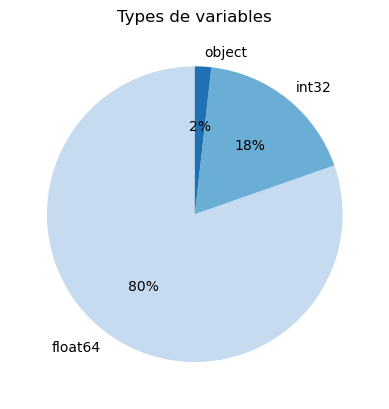

In [131]:

#Type de données
info_cleanned_BEB_2016 = compl_info(cleanned_BEB_2016).T.sort_values("Pourcentage remplissage").reset_index()
info_cleanned_BEB_2016 = info_cleanned_BEB_2016.rename(columns={'index':'Variable'})

dTypes = info_cleanned_BEB_2016['Type'].value_counts()
blues3 = sns.color_palette(palette="Blues", n_colors =3)

plt.pie(dTypes.values.tolist(), labels=['float64','int32', 'object'], colors = blues3, autopct='%.0f%%', startangle=90)
plt.title("Types de variables")
plt.show()


In [132]:
info_cleanned_BEB_2016.head()

,Variable,Type,null,Pourcentage remplissage
0,ENERGYSTARScore,float64,556,64.631043
1,Neighborhood,object,0,100.0
2,Hotel,float64,0,100.0
3,Hotel_Pool,float64,0,100.0
4,Industrial,float64,0,100.0


In [133]:

# Matrice de corrélation de toutes les variables quantitatives
cleanned_BEB_2016_corr = cleanned_BEB_2016.select_dtypes(include=['float64', 'int32']).corr().round(2)


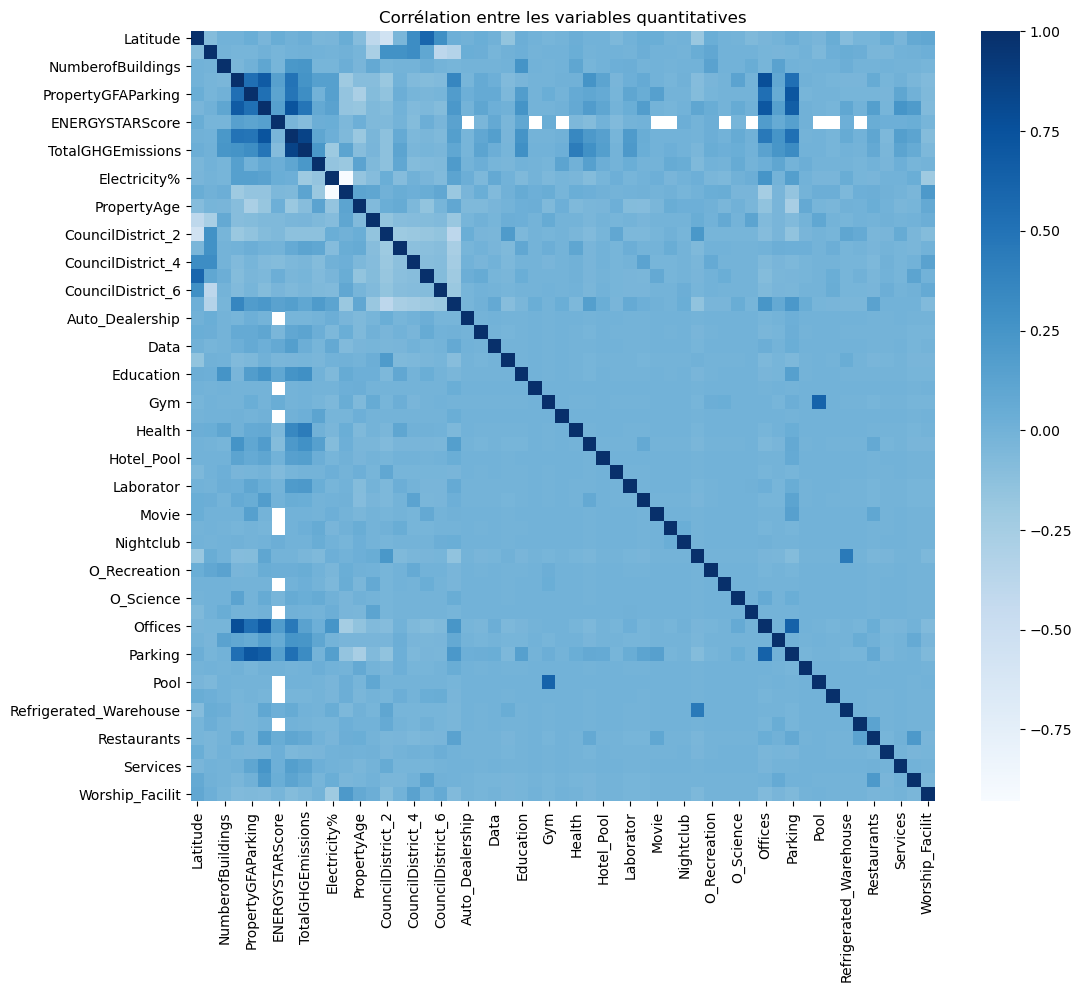

In [134]:
plt.figure(figsize=(12,10))
sns.heatmap(cleanned_BEB_2016_corr, cmap="Blues")

plt.title("Corrélation entre les variables quantitatives")
plt.tight_layout                     
plt.show()

In [135]:

#Analyse facteur correlation supérieur à |0.85|

for vari in cleanned_BEB_2016_corr.columns.tolist()[1:]:
    high_correl = cleanned_BEB_2016_corr.loc[(cleanned_BEB_2016_corr[vari]>0.85)|(cleanned_BEB_2016_corr[vari]<-0.85)]
    if high_correl.shape[0] >1:
        print(str(vari) +" est correlée à " + str(high_correl.index.tolist()) + str(high_correl[vari].values.tolist()) + "\n")
    else:
        pass


SiteEnergyUseWN(kBtu) est correlée à ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'][1.0, 0.86]

TotalGHGEmissions est correlée à ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'][0.86, 1.0]

Electricity% est correlée à ['Electricity%', 'NaturalGas%'][1.0, -0.93]

NaturalGas% est correlée à ['Electricity%', 'NaturalGas%'][-0.93, 1.0]



<a id='donnees_modelisation'></a>

---
---

# <span style='background:#26467a'><span style='color:white'>**Jeu de données pour la modélisation** </span></span>


**Jeu de données à utiliser pour la suite de l'étude**

In [136]:
cleanned_BEB_2016.shape

(1572, 56)

In [137]:

# Définir le dossier qui contiendra le fichier avec les données post-EDA
P4_cleaned = '/home/raquelsp/Documents/Openclassrooms/P4_Seattle_buildings/P4_travail/P4_data/P4_cleaned'
os.chdir(P4_cleaned)

cleanned_BEB_2016.to_csv('BEB_2016.csv', sep='\t', encoding='utf_8', index=False)


*Note* : <br>
La modélisation des données de consommation d'énergie est réalisée dans le notebook **SanchezPellicer_Raquel_2_notebook_predictionConso_012023.ipynb** <br>
La modélisation des données d'émissions de CO2 et L'evaluation de l'intérêt de l'ENERGIE STAR Score sont réalisées dans le notebook **SanchezPellicer_Raquel_3_notebook_predictionEmi_012023.ipynb** <br>



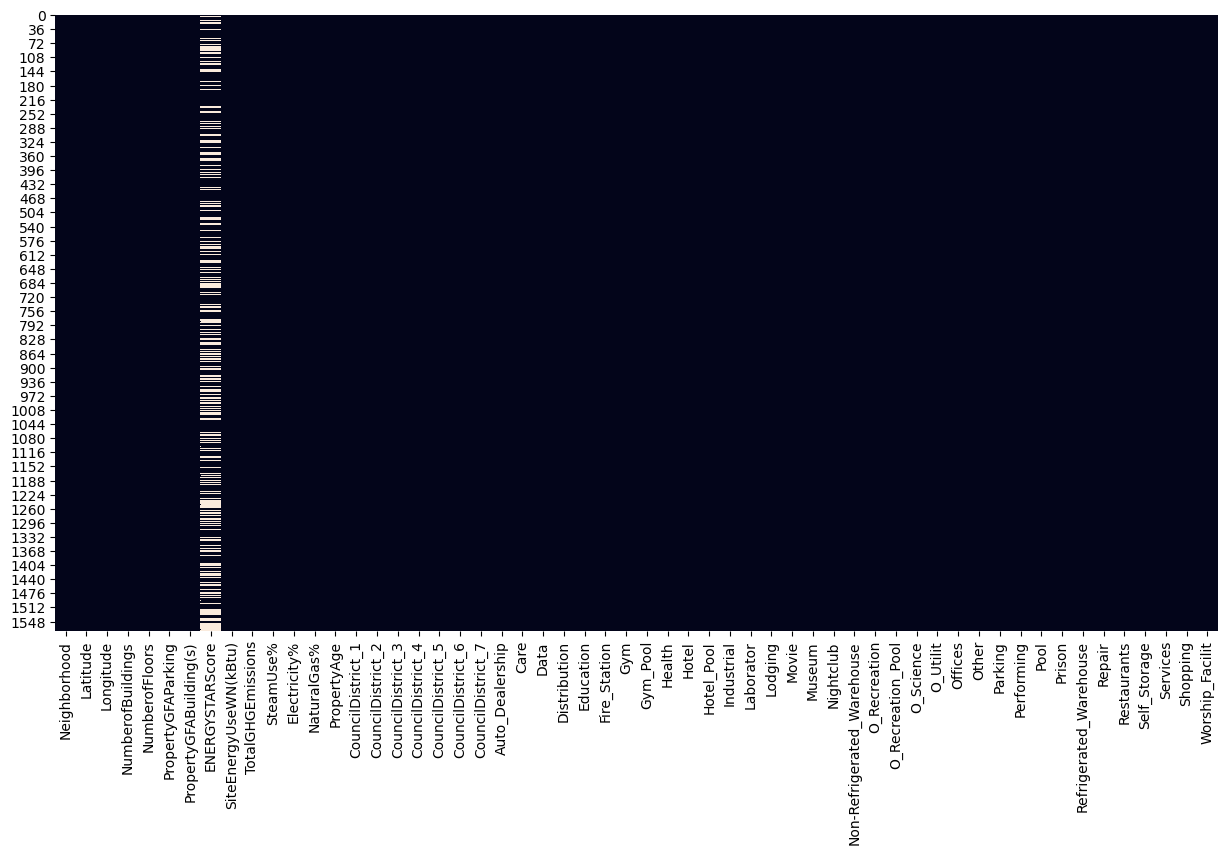

In [138]:
'''
#------------------------------
# Graphique valeurs manquantes
#------------------------------
'''
plt.figure(figsize=(15,8))
sns.heatmap(cleanned_BEB_2016.isnull(), cbar=False, cmap="rocket")
plt.show()
